# Forecasting CO2 emissions

In this notebook we will be doing forecasting on CO2 emissions for every country present in our dataset.

To get the best results we could we used a few different models, and picked out the best one for each country.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import warnings
warnings.simplefilter('ignore')

## Read the data

To begin the project, we explored available databases related to pollution and CO2 emissions. After gathering the data from online sources, we organized it into appropriate folders and integrated it into our code.

-----

In [2]:
data_root = './data'

emmisions_comp_csv = f'{data_root}/co2_emmisions_complicated.csv'
emmisions_sector_csv = f'{data_root}/co2_emmisions_by_sector.csv'

In [3]:
# Reading the data
df_co2 = pd.read_csv(f'{data_root}/co2_emmisions_complicated.csv')

# Filtering the data only for European countries
df_co2_europe = df_co2[df_co2['Region'].str.contains('Europe', case=False, na=False)]

# Add Russia
df_russia = df_co2[df_co2['Name'].str.contains('Russian Federation', case=False, na=False)].copy()
df_russia['Name'] = df_russia['Name'].replace('Russian Federation', 'Russia')

# Add Ukraine
df_ukraine = df_co2[df_co2['Name'].str.contains('Ukraine', case=False, na=False)].copy()

# Add Belarus
df_belarus = df_co2[df_co2['Name'].str.contains('Belarus', case=False, na=False)].copy()

# Add Moldova
df_moldova = df_co2[df_co2['Name'].str.contains('Moldova', case=False, na=False)].copy()
df_moldova['Name'] = df_moldova['Name'].replace('Moldova, Republic of', 'Moldova')

# Combine all
df_co2_europe = pd.concat([df_co2_europe, df_russia, df_ukraine, df_belarus, df_moldova]).drop_duplicates()


row = df_co2_europe[df_co2_europe['Name'] == 'Serbia and Montenegro'].copy()

serbia_row = row.copy()
montenegro_row = row.copy()

serbia_row['Country_code'] = 'SRB'
serbia_row['Name'] = 'Serbia'

montenegro_row['Country_code'] = 'MNE'
montenegro_row['Name'] = 'Montenegro'

year_columns = [col for col in df_co2_europe.columns if col.isdigit()]

# Split the CO2 data by 85% and 15% because Serbia is much bigger than Montenegro by area and by population
serbia_row[year_columns] = row[year_columns] * 0.96
montenegro_row[year_columns] = row[year_columns] * 0.04

# Drop the original Serbia and Montenegro row
df_co2_europe = df_co2_europe[df_co2_europe['Name'] != 'Serbia and Montenegro']

# Append the two new rows
df_co2_europe = pd.concat([df_co2_europe, serbia_row, montenegro_row], ignore_index=True)

In [4]:
df_co2 = df_co2_europe.melt(
    id_vars=['Region', 'Country_code', 'Name', 'Substance'],
    var_name='Year',
    value_name='CO2_emissions'
)

df_co2['Year'] = df_co2['Year'].astype(int)

After we filtered the data, we picked some features that we use to train the model and get better results.
- Yearly features: connected to the year we created years in start, pre/post period of Kyoto Protocol and Paris Agreement.
- CO2 yearly lag: we use a shift to get the previous 1/2/3 years.
- Yearly rolling features: using a rolling window to calcualte the mean and standard deviation of the window.

In [5]:
# Building Features 
def add_year_features(df, year_min=None):
    # Date/Year features
    if year_min is None:
        year_min = df['year'].min()
    
    df['years_since_start'] = df['year'] - year_min
    df['years_since_start_squared'] = df['years_since_start'] ** 2
    df['is_kyoto'] = (df['year'] >= 2005).astype(int)  # Example: Kyoto Protocol era
    df['is_post_paris'] = (df['year'] >= 2015).astype(int)  # Paris Agreement era
    return df


def add_lag_features(df):
    # Year lag
    df['lag_1'] = df['CO2_emissions'].shift(1)
    df['lag_2'] = df['CO2_emissions'].shift(2)
    df['lag_3'] = df['CO2_emissions'].shift(3)
    return df


def add_rolling_features(df):
    # Rolling Windows
    df['rolling_mean_3'] = df['CO2_emissions'].rolling(window=3).mean()
    df['rolling_std_3']  = df['CO2_emissions'].rolling(window=3).std()
    return df

# Define feature sets
year_features = ['year', 'years_since_start', 'years_since_start_squared', 'is_kyoto', 'is_post_paris']
lag_features = ['lag_1', 'lag_2', 'lag_3']
rolling_features = ['rolling_mean_3', 'rolling_std_3']

features = year_features + lag_features + rolling_features

We created an evaluation function that splits the data we have in 70% 30% for training and evaluation, then we gave a set of models that are trained and evaluated and the function returns the best model by the error metric defined in the "eval_metric" variable. 

In [6]:
def eval_and_select_model(df, algorithms, features, eval_metric, target='CO2_emissions'):
    """ Function for evaluation and selection of the best model """
    eval_list = []

    for algo in algorithms:
        X = df[features]
        y = df[target]

        if algo == 'sarima':
            # Only use y, because SARIMA is univariate
            y_train, y_test = train_test_split(y, test_size=0.3, shuffle=False)

            # Fit SARIMA model
            try:
                model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,12))
                result = model.fit(disp=False)
                y_pred = result.forecast(steps=len(y_test))
            except:
                y_pred = [np.nan] * len(y_test)
            
        else:
            if algo in ['knn', 'elasticnet', 'lasso', 'ridge']:
                X = X.fillna(0)
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
                
            model = algorithms[algo]   

            # Fit and predict
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Evaluate if y_pred was generated
        if y_pred is not None and len(y_pred) == len(y_test):
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            eval_list.append({
                'algorithm': algo,
                'mae': mae,
                'mse': mse,
                'rmse': rmse,
                'r2': r2
            })
    
    df_eval = pd.DataFrame(eval_list).sort_values(by=eval_metric)
    return df_eval.iloc[0]['algorithm'], df_eval
    

Function that gets the best model and predicts the CO2 emission year by year (in order to calcualte the lag and rolling features). The resulting dataframe contains the CO2 emission predictions.

In [7]:
def predict_year_by_year(df, algo, features, algorithms, year_from, year_to, target='CO2_emissions'):
    predictions = []
    df_all = df.copy().sort_values('year').reset_index(drop=True)
    min_year = df['year'].min()

    for year in range(year_from, year_to + 1):
        new_row = df_all.iloc[[-1]].copy()
        new_row['year'] = year
        new_row[target] = np.nan
        df_all = pd.concat([df_all, new_row], ignore_index=True).sort_values('year').reset_index(drop=True)

        df_all = add_year_features(df_all, min_year)
        df_all = add_lag_features(df_all)
        df_all = add_rolling_features(df_all)

        train_df = df_all[df_all[target].notna()]
        y_train = train_df[target]

        if algo == 'sarima':
            try:
                model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
                result = model.fit(disp=False)
                y_pred = result.forecast(steps=1).iloc[0]
            except:
                y_pred = np.nan
        else:
            X_train = train_df[features]
            if algo in ['knn', 'elasticnet', 'lasso', 'ridge']:
                X_train = X_train.fillna(0)

            model = algorithms[algo]
            model.fit(X_train, y_train)

            X_pred = df_all[df_all['year'] == year][features]
            if algo in ['knn', 'elasticnet', 'lasso', 'ridge']:
                X_pred = X_pred.fillna(0)

            y_pred = model.predict(X_pred)[0]

        # Insert prediction
        df_all.loc[df_all['year'] == year, target] = y_pred
        predictions.append({'year': year, f'{target}': y_pred})
        
    return pd.DataFrame(predictions)

Here is the main pipeline. Firstly some main parameters are defined for the evaluation and prediction functions. 

For the algorithms we selected:
* RandomForrest
* XGBoost
* KNNNeighbors and
* Sarima.

['Albania', 'Austria', 'Belgium', 'Bulgaria', 'Bosnia and Herzegovina', 'Switzerland', 'Cyprus', 'Czech Republic', 'Germany', 'Denmark', 'Spain', 'Estonia', 'Finland', 'France', 'United Kingdom', 'Greece', 'Croatia', 'Hungary', 'Ireland', 'Iceland', 'Italy', 'Lithuania', 'Luxembourg', 'Latvia', 'North Macedonia', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Sweden', 'Russia', 'Ukraine', 'Belarus', 'Moldova', 'Serbia', 'Montenegro']
Forecasting Albania
Picked: rf
  algorithm          mae           mse         rmse         r2
0        rf   257.267663  1.193542e+05   345.476827  -0.029097
2       knn   272.471251  1.241742e+05   352.383602  -0.070656
1   xgboost   510.841724  3.629239e+05   602.431661  -2.129205
3    sarima  1324.655686  2.573098e+06  1604.087949 -21.185783


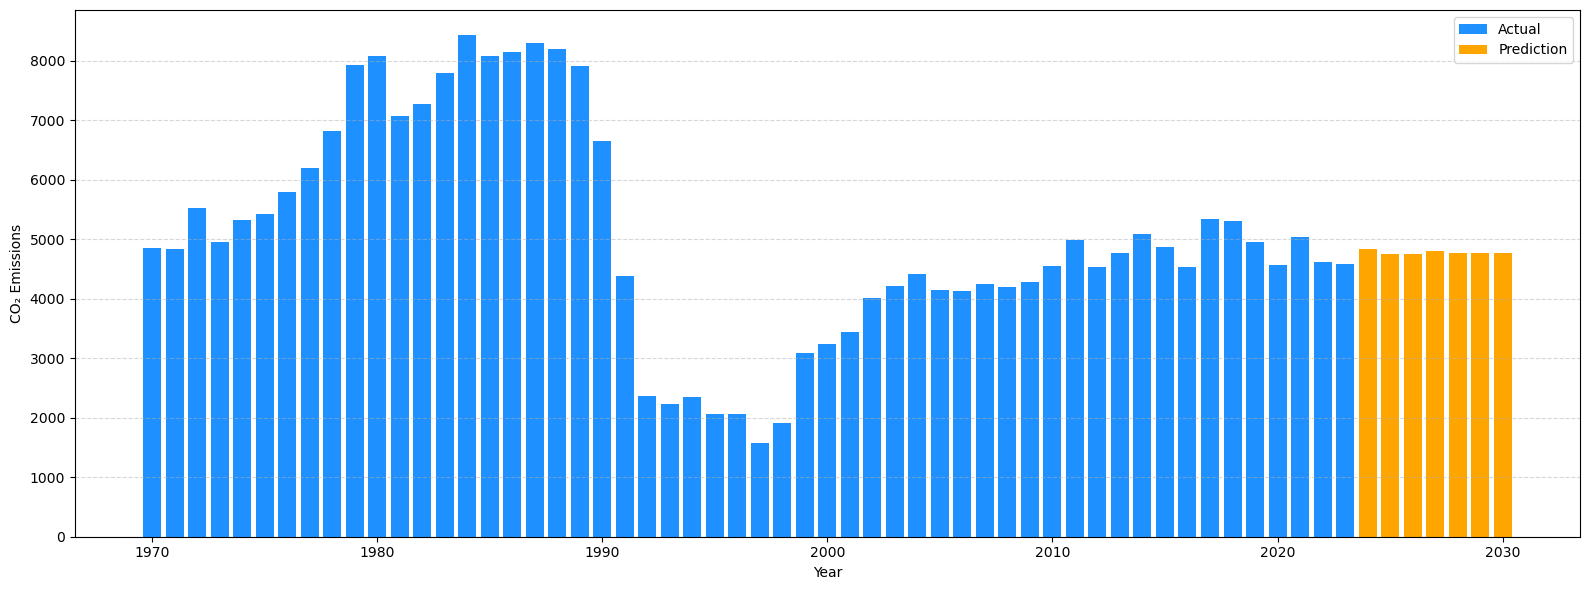

----------------------------------------------------------------
Forecasting Austria
Picked: knn
  algorithm           mae           mse          rmse         r2
2       knn   2828.033736  1.361446e+07   3689.777382   0.308856
0        rf   7477.290330  6.486213e+07   8053.703074  -2.292757
1   xgboost   8612.757965  8.560836e+07   9252.478630  -3.345949
3    sarima  23879.277003  6.942629e+08  26348.869535 -34.244589


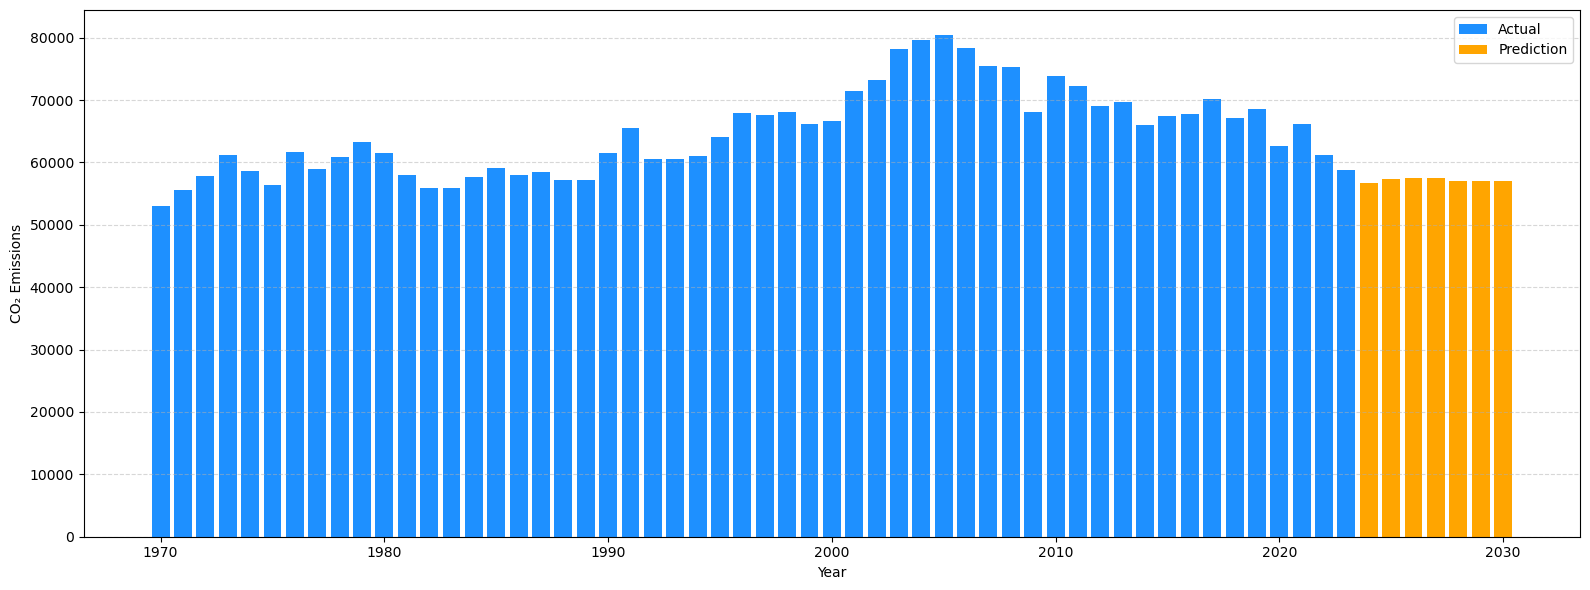

----------------------------------------------------------------
Forecasting Belgium
Picked: knn
  algorithm           mae           mse          rmse        r2
2       knn  11252.380222  1.679363e+08  12959.024123 -1.582789
3    sarima  14274.288670  2.532194e+08  15912.868686 -2.894406
0        rf  14716.744452  2.801703e+08  16738.289665 -3.308900
1   xgboost  18147.199364  4.018499e+08  20046.195234 -5.180280


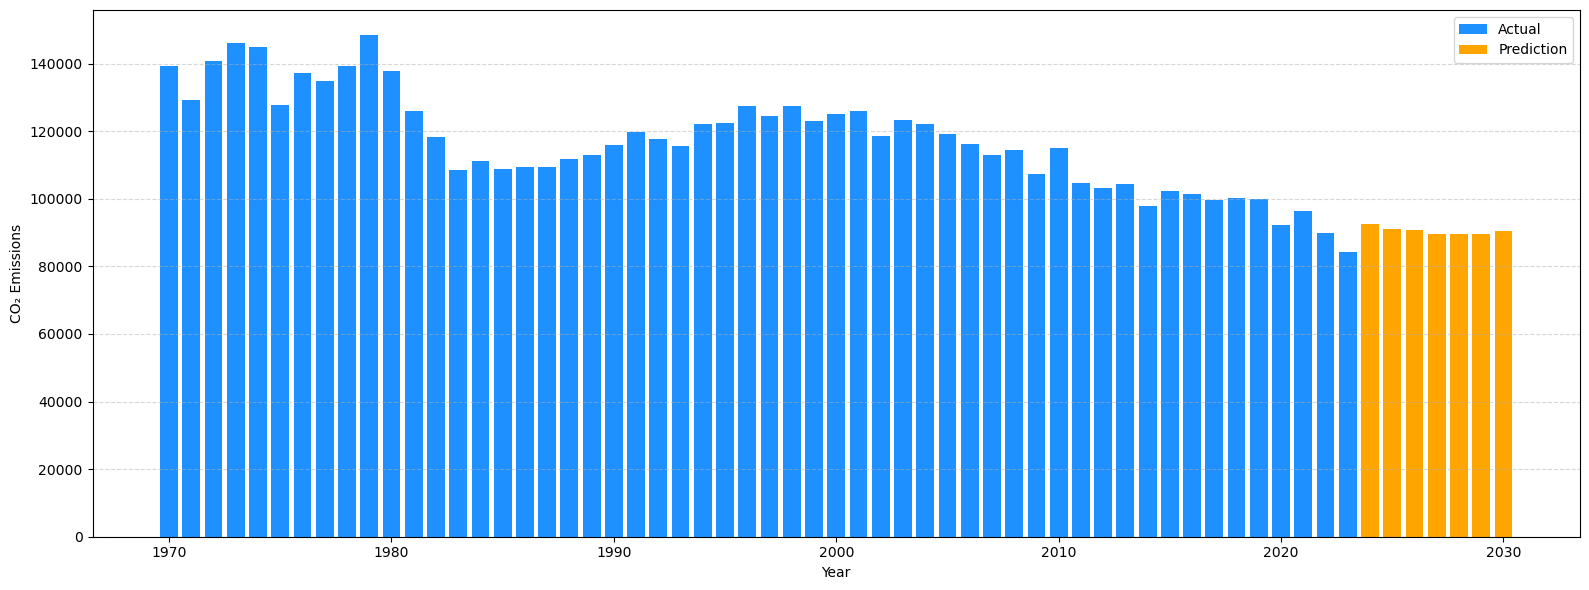

----------------------------------------------------------------
Forecasting Bulgaria
Picked: knn
  algorithm          mae           mse         rmse        r2
2       knn  4832.570963  3.306987e+07  5750.641264 -0.508491
0        rf  5270.577278  3.803490e+07  6167.243790 -0.734972
3    sarima  4893.007769  4.006454e+07  6329.655361 -0.827555
1   xgboost  5683.483020  4.396977e+07  6630.970768 -1.005693


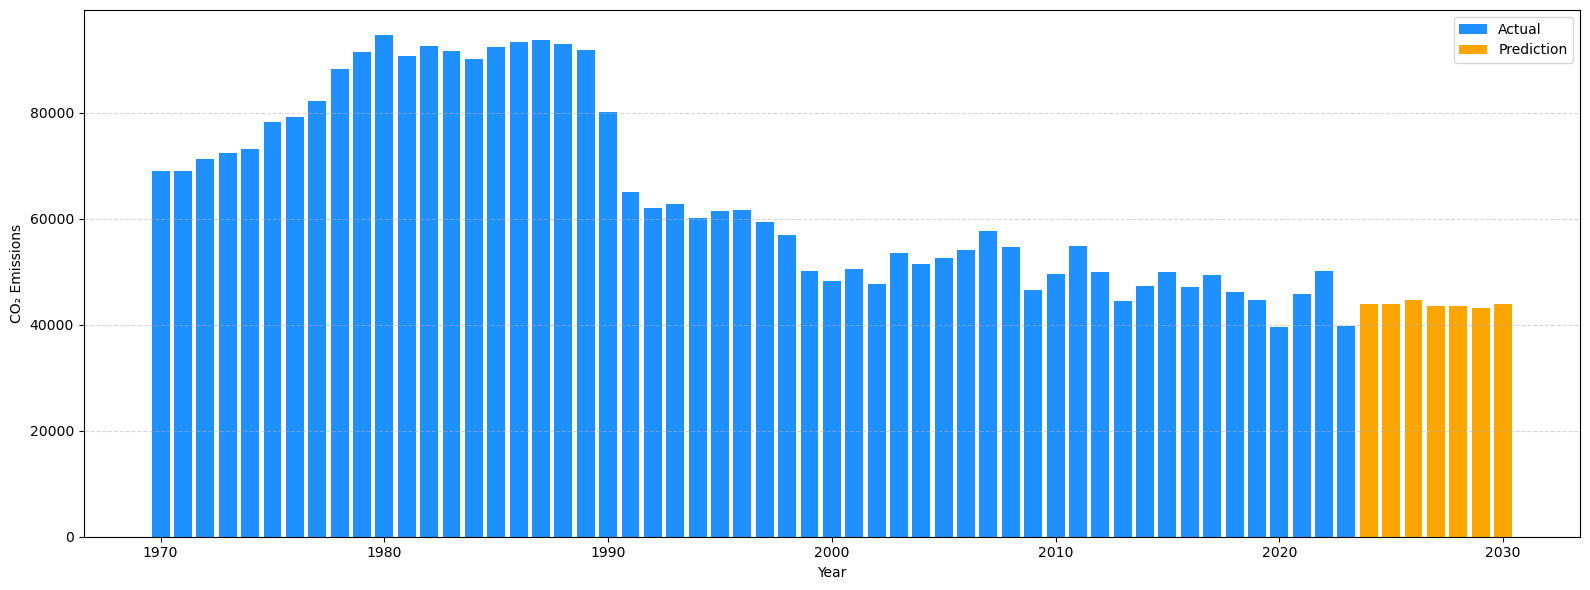

----------------------------------------------------------------
Forecasting Bosnia and Herzegovina
Picked: rf
  algorithm          mae           mse         rmse         r2
0        rf  1766.853260  3.958559e+06  1989.612858  -1.249731
1   xgboost  2343.768216  6.731659e+06  2594.544124  -2.825741
2       knn  2322.071616  7.091254e+06  2662.940786  -3.030106
3    sarima  4909.689162  3.438208e+07  5863.623070 -18.540044


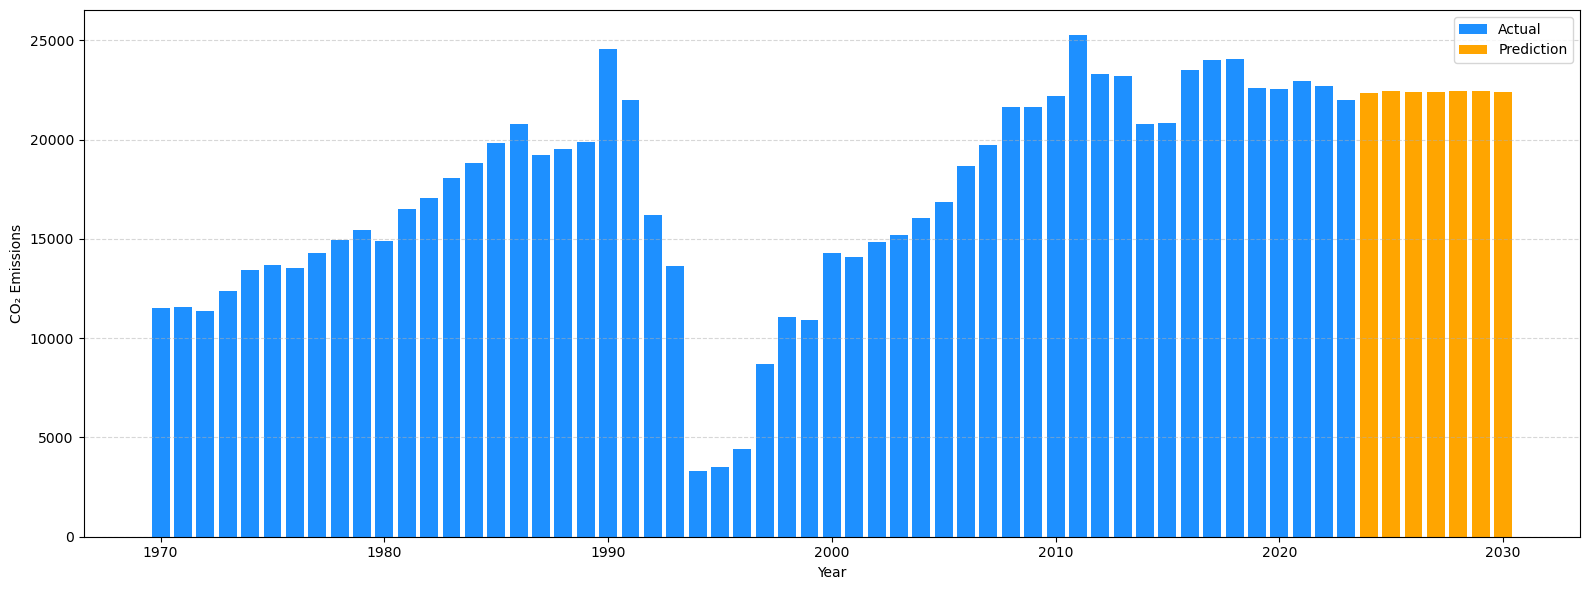

----------------------------------------------------------------
Forecasting Switzerland
Picked: knn
  algorithm          mae           mse          rmse        r2
2       knn  3001.953243  1.506505e+07   3881.372625 -0.052911
0        rf  3918.099563  2.507019e+07   5007.014478 -0.752180
1   xgboost  3727.896873  2.622814e+07   5121.342070 -0.833111
3    sarima  8829.189762  1.080747e+08  10395.899024 -6.553448


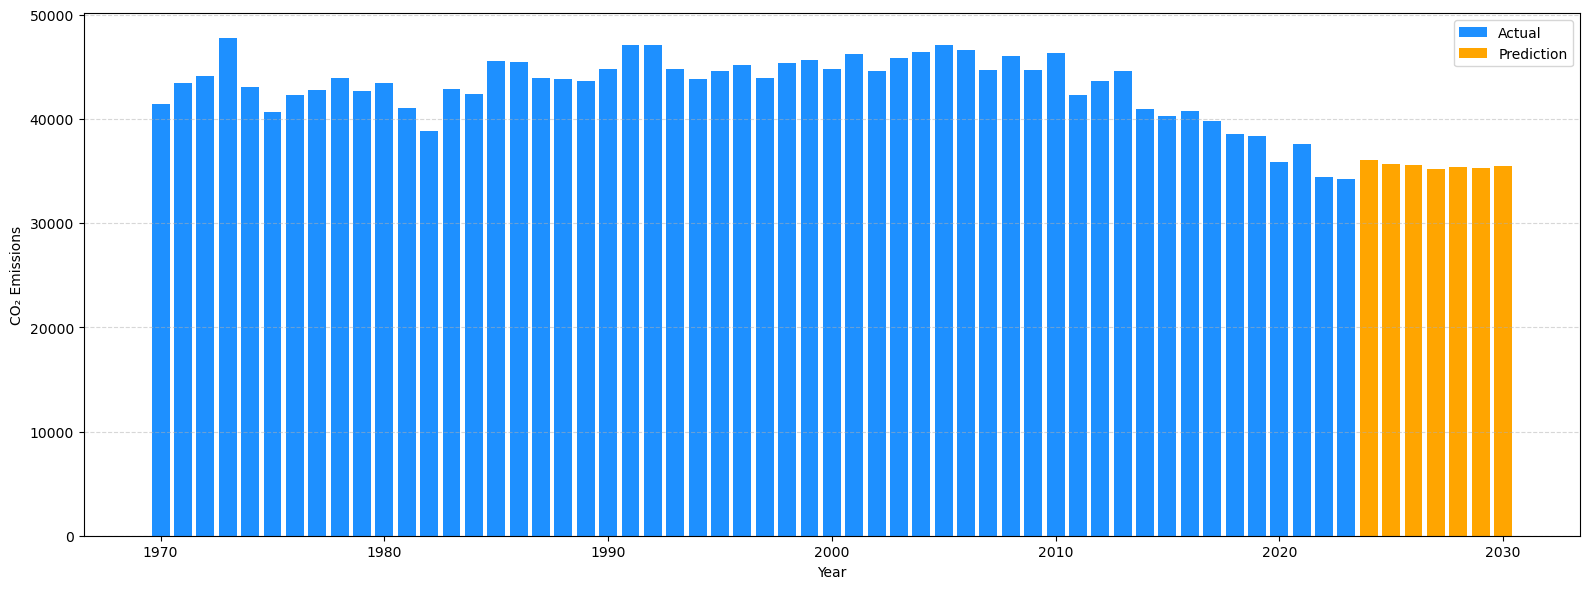

----------------------------------------------------------------
Forecasting Cyprus
Picked: knn
  algorithm          mae           mse         rmse         r2
2       knn   449.727607  3.044639e+05   551.782492   0.064747
0        rf   515.925675  3.484052e+05   590.258614  -0.070231
1   xgboost   766.422196  7.320168e+05   855.579823  -1.248610
3    sarima  2453.916564  7.792134e+06  2791.439382 -22.935883


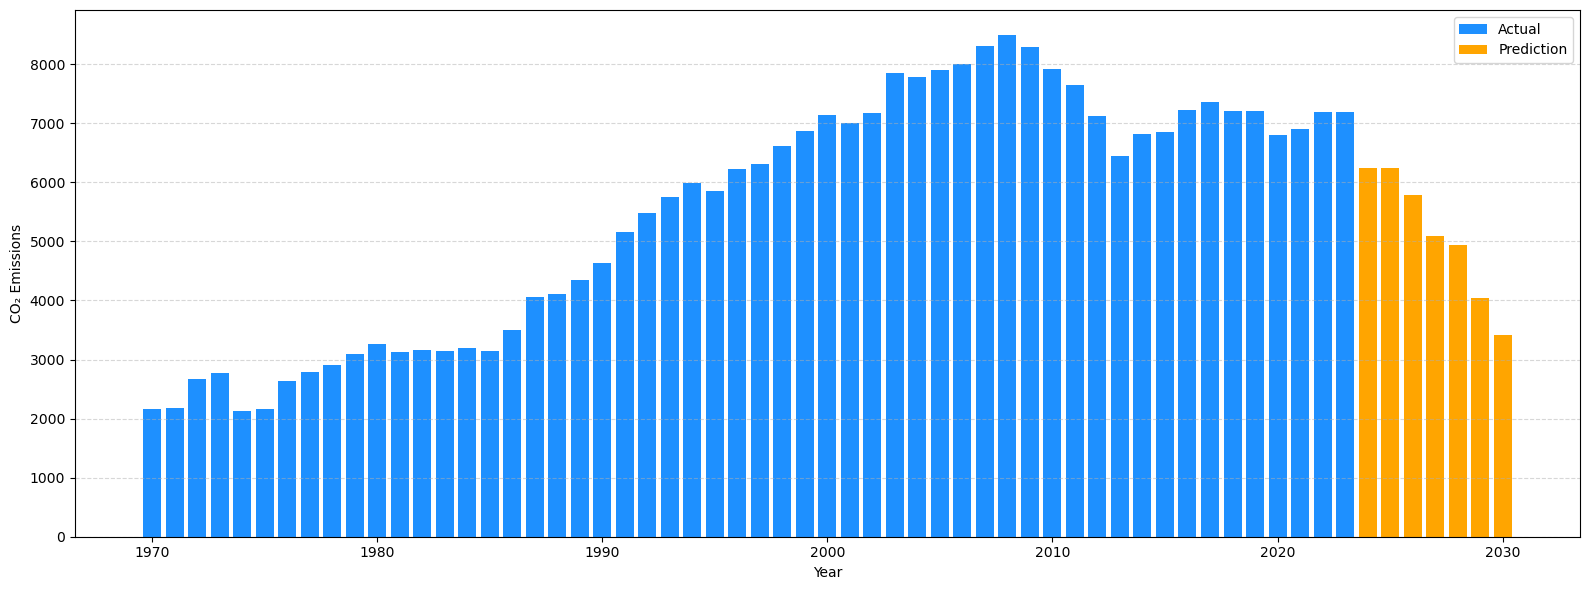

----------------------------------------------------------------
Forecasting Czech Republic
Picked: rf
  algorithm           mae           mse          rmse        r2
0        rf  18742.226542  4.468587e+08  21139.032838 -2.867942
3    sarima  18679.811632  4.683903e+08  21642.325686 -3.054316
2       knn  20508.941784  5.338346e+08  23104.859882 -3.620792
1   xgboost  21710.109053  5.962830e+08  24418.905652 -4.161336


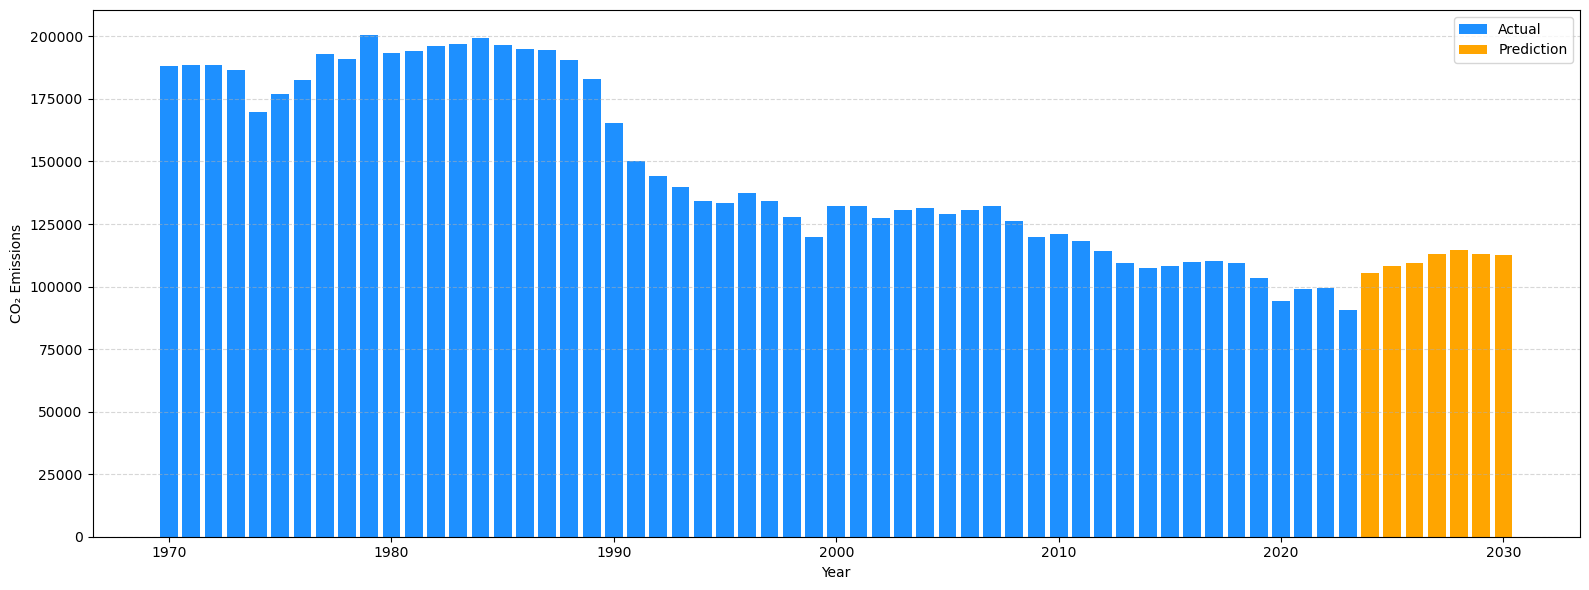

----------------------------------------------------------------
Forecasting Germany
Picked: sarima
  algorithm            mae           mse           rmse        r2
3    sarima   80762.757333  1.138854e+10  106717.084042 -1.261720
1   xgboost   92694.062829  1.362604e+10  116730.623525 -1.706079
0        rf  100820.081305  1.518781e+10  123238.835889 -2.016241
2       knn  110002.108400  1.713581e+10  130903.807823 -2.403106


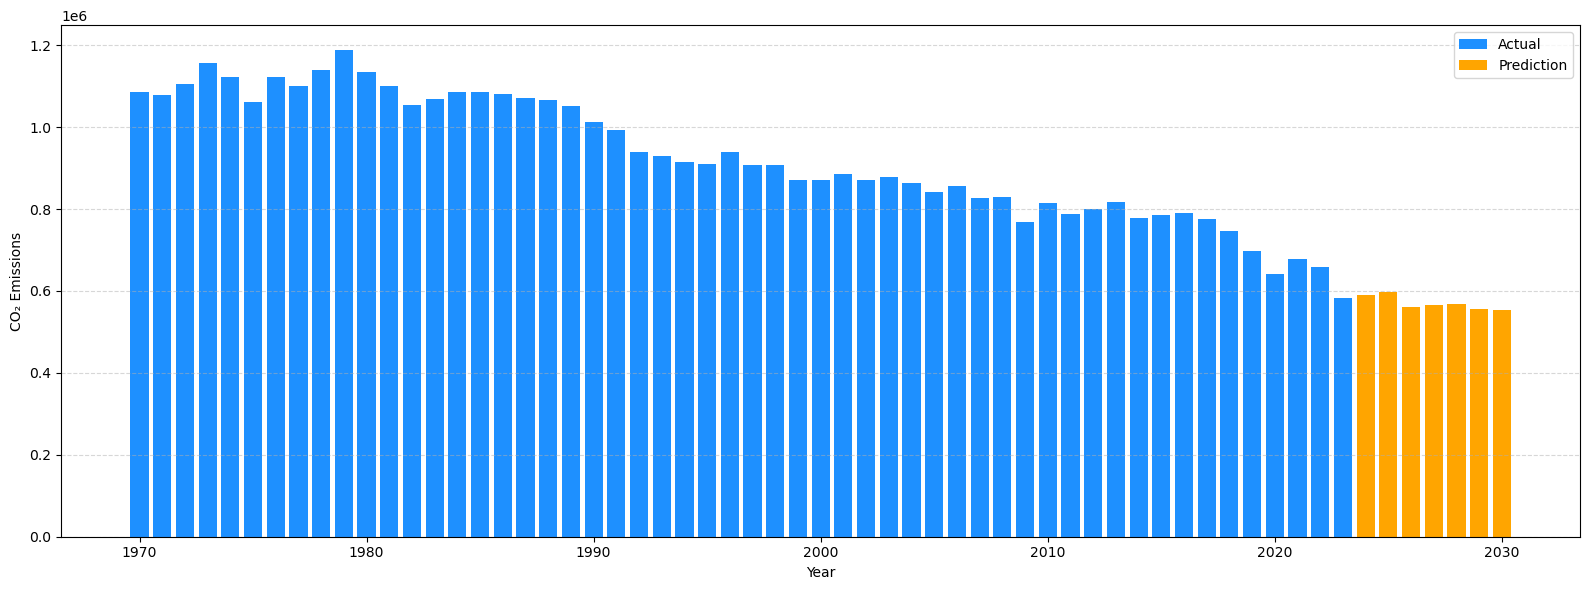

----------------------------------------------------------------
Forecasting Denmark
Picked: knn
  algorithm           mae           mse          rmse        r2
2       knn  20260.433135  4.872241e+08  22073.153579 -5.958050
0        rf  20344.388112  4.914681e+08  22169.078817 -6.018658
3    sarima  21724.853356  5.880924e+08  24250.615793 -7.398550
1   xgboost  22898.121986  6.102613e+08  24703.467094 -7.715144


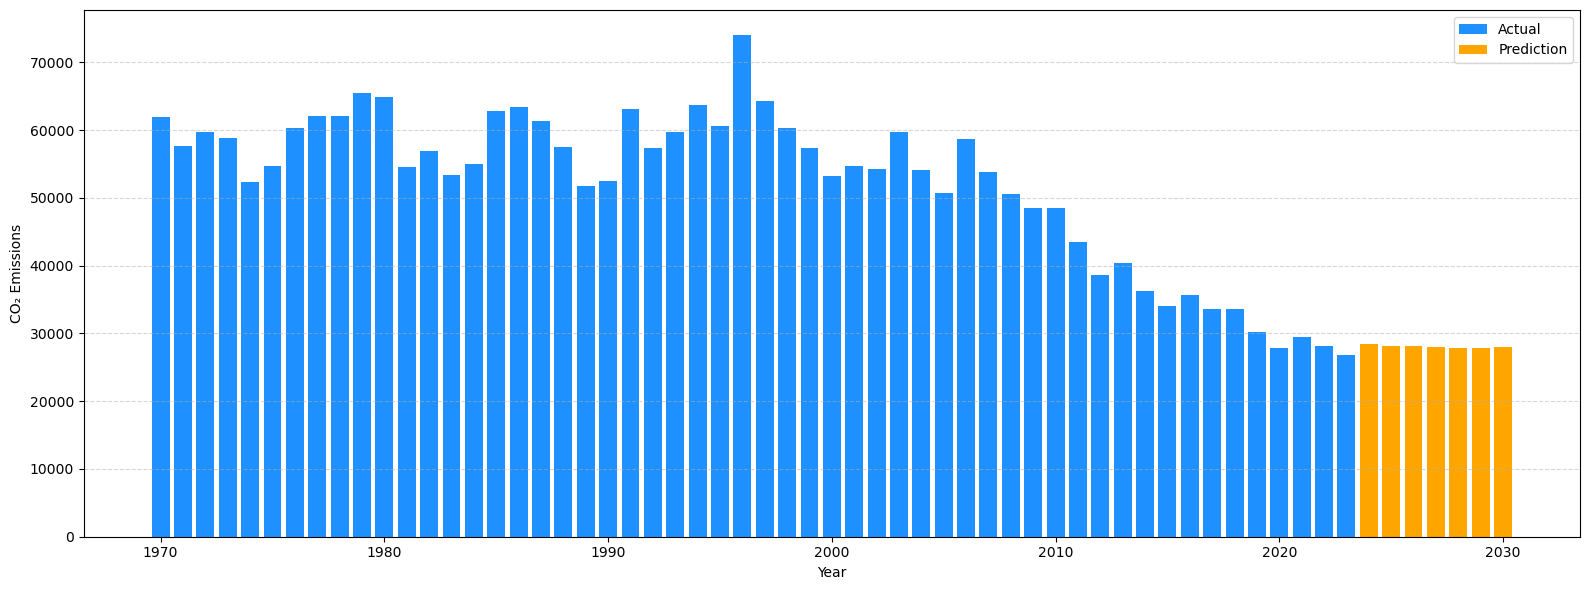

----------------------------------------------------------------
Forecasting Spain
Picked: knn
  algorithm            mae           mse           rmse         r2
2       knn   27161.550639  1.018166e+09   31908.705729   0.347351
0        rf   54389.914296  3.346102e+09   57845.503998  -1.144869
1   xgboost   90669.968591  9.447619e+09   97198.862173  -5.055972
3    sarima  161664.746071  3.255550e+10  180431.422539 -19.868239


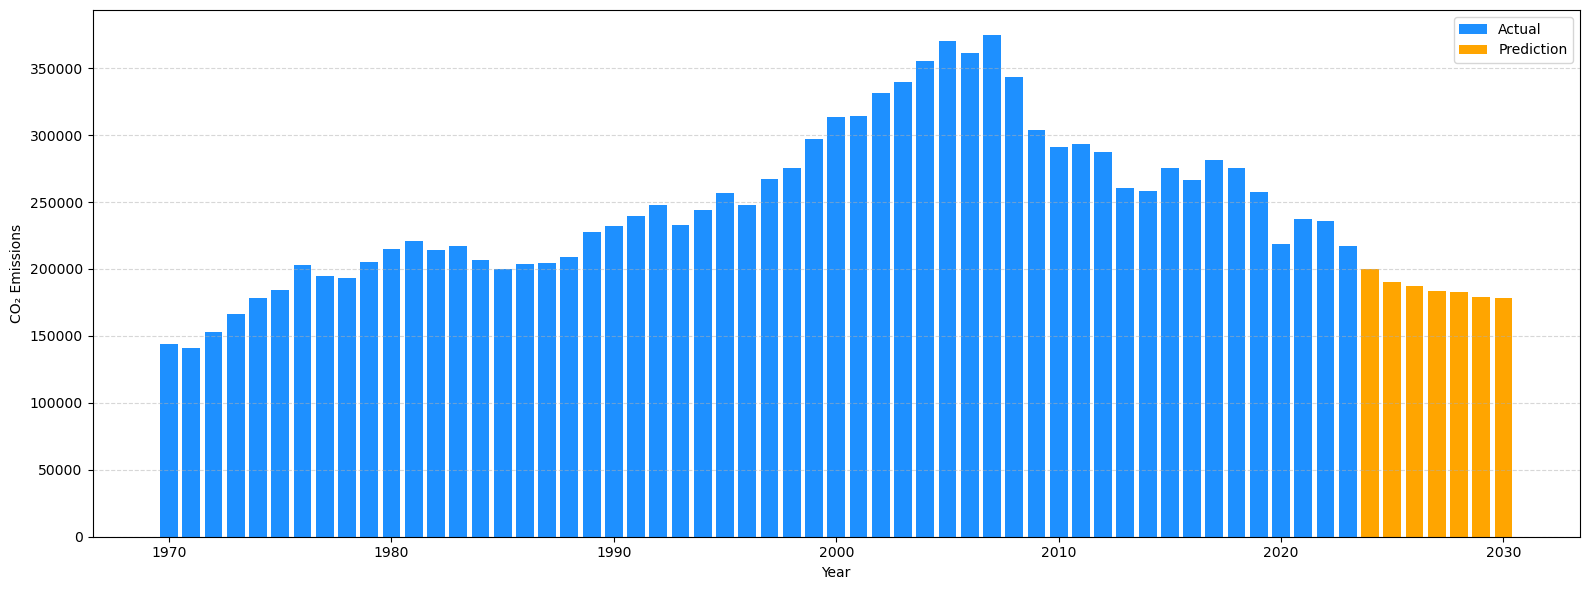

----------------------------------------------------------------
Forecasting Estonia
Picked: knn
  algorithm          mae           mse         rmse        r2
2       knn  3143.300135  1.465789e+07  3828.562421  0.134450
0        rf  3180.080876  1.506834e+07  3881.795732  0.110213
1   xgboost  3552.826278  1.697169e+07  4119.671703 -0.002181
3    sarima  5839.146234  4.498939e+07  6707.412865 -1.656628


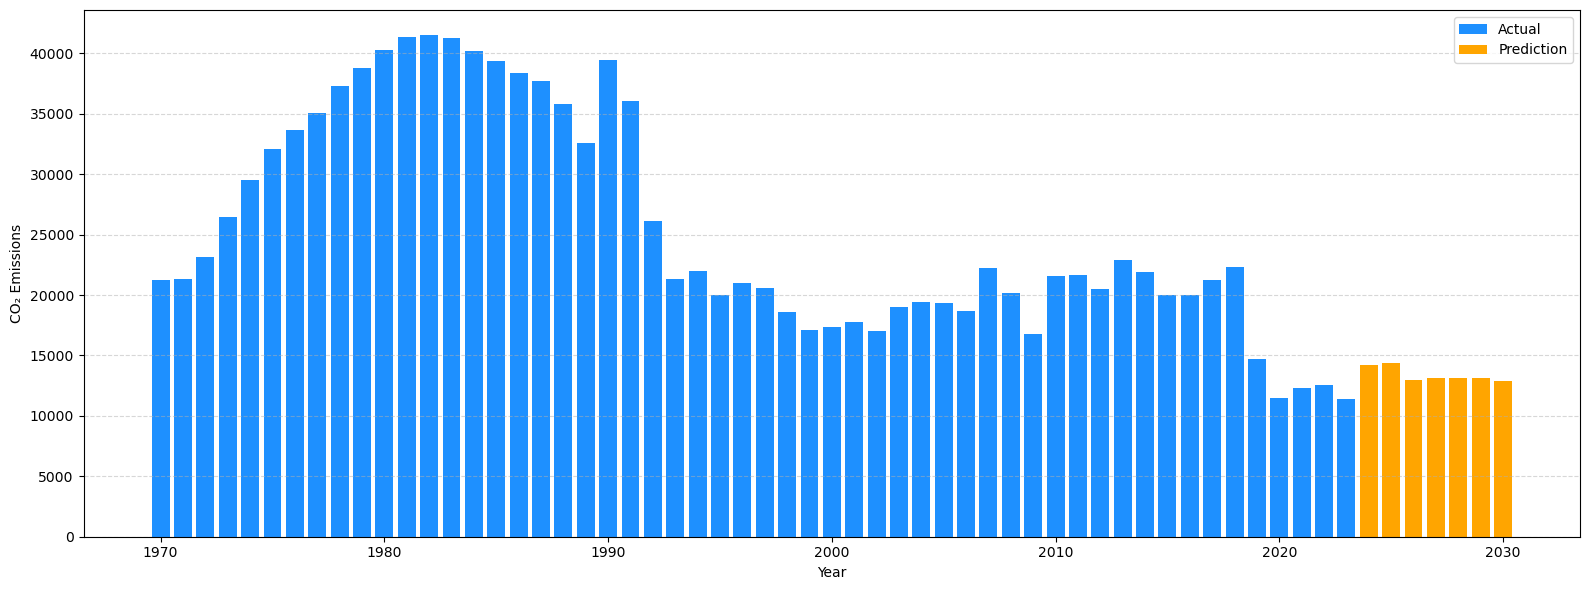

----------------------------------------------------------------
Forecasting Finland
Picked: knn
  algorithm           mae           mse          rmse        r2
2       knn   5777.829836  4.622103e+07   6798.605365  0.511538
1   xgboost   7085.465582  7.566811e+07   8698.742010  0.200342
0        rf  11284.969846  1.651310e+08  12850.330599 -0.745098
3    sarima  27728.682591  1.002628e+09  31664.302861 -9.595735


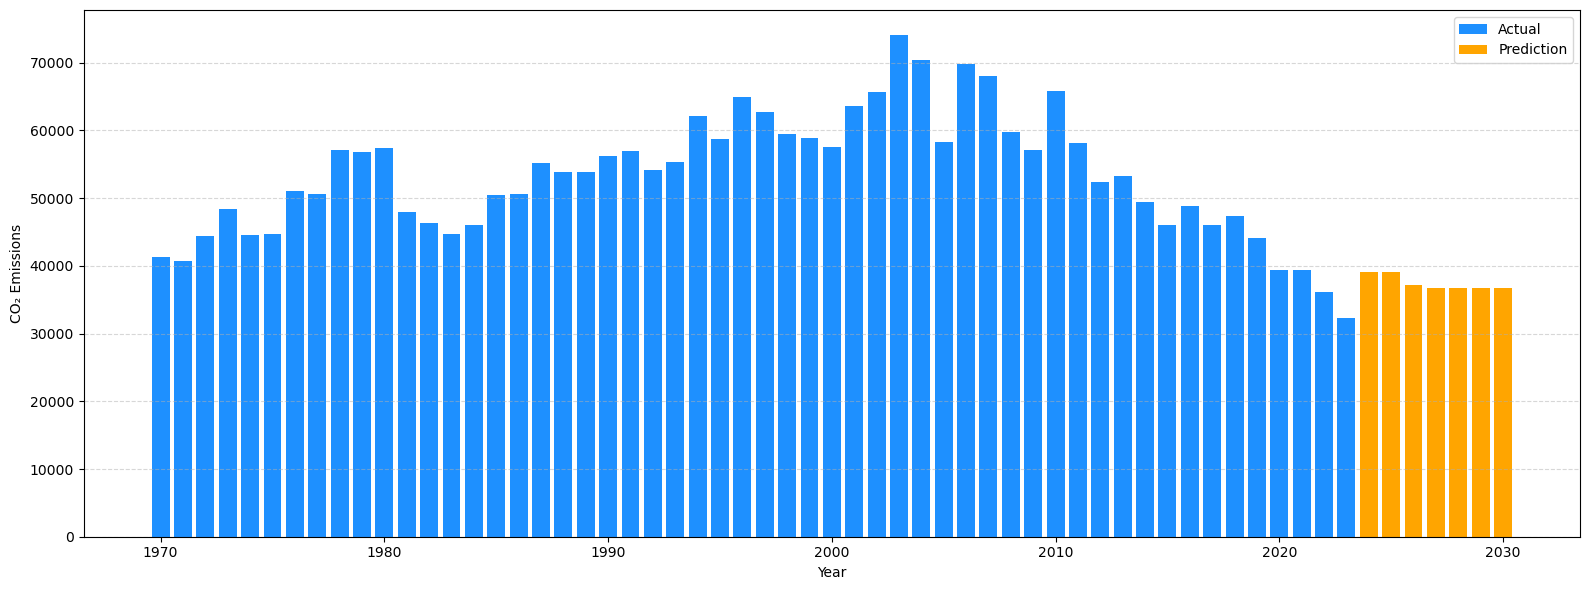

----------------------------------------------------------------
Forecasting France
Picked: knn
  algorithm           mae           mse          rmse        r2
2       knn  45209.011439  2.973008e+09  54525.299551 -2.074572
0        rf  49461.635681  3.550562e+09  59586.588440 -2.671855
1   xgboost  53041.723350  3.975813e+09  63054.044507 -3.111634
3    sarima  81513.217543  8.182689e+09  90458.214647 -7.462224


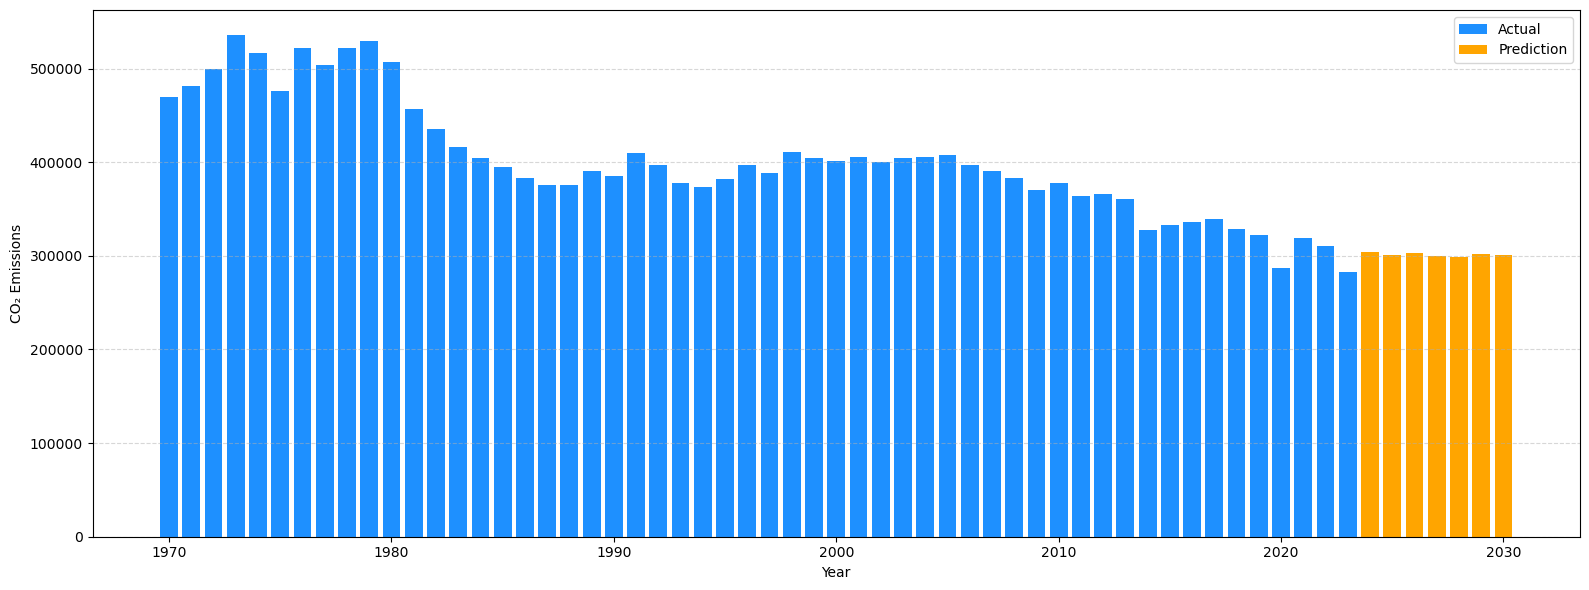

----------------------------------------------------------------
Forecasting United Kingdom
Picked: knn
  algorithm            mae           mse           rmse        r2
2       knn  134034.448342  2.322738e+10  152405.315105 -3.123347
0        rf  138807.084664  2.489731e+10  157788.813574 -3.419794
3    sarima  149490.690380  2.945668e+10  171629.496418 -4.229179
1   xgboost  152723.785771  2.950500e+10  171770.187632 -4.237755


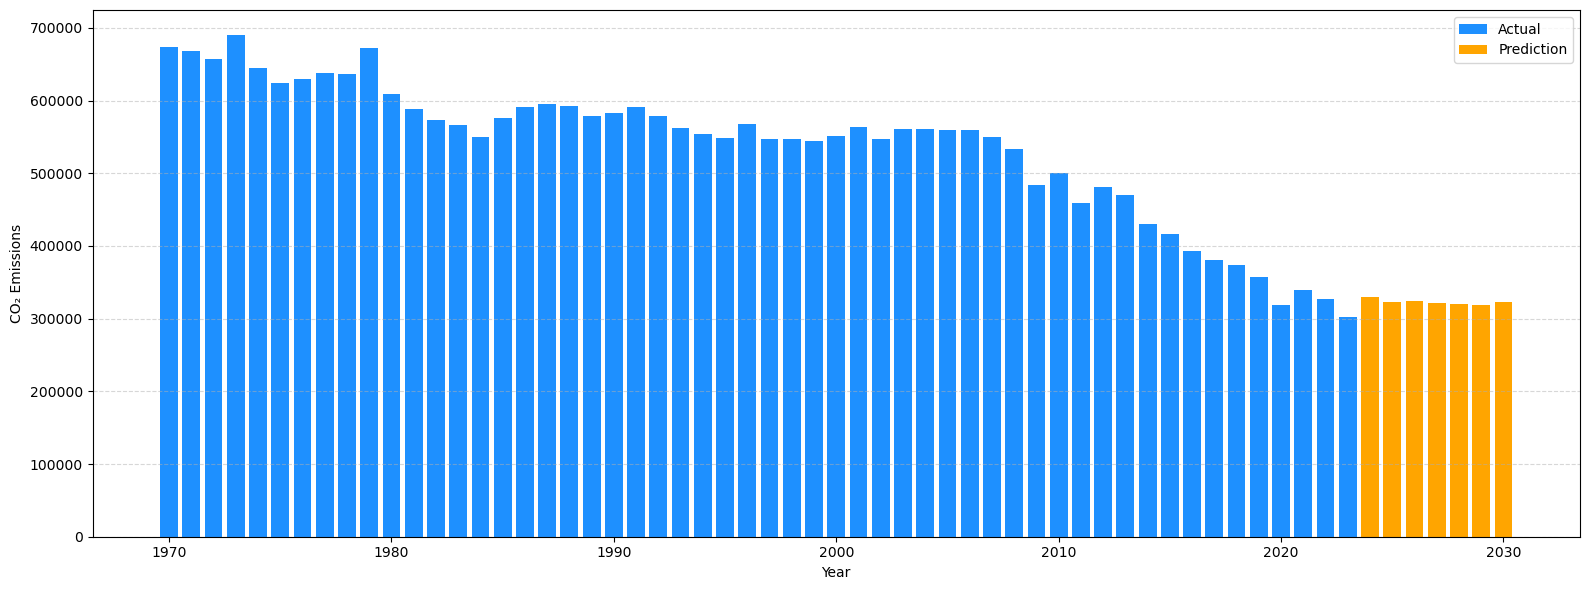

----------------------------------------------------------------
Forecasting Greece
Picked: knn
  algorithm           mae           mse          rmse        r2
2       knn   8208.874688  8.386675e+07   9157.879247  0.699723
0        rf  19228.886706  4.510395e+08  21237.691313 -0.614906
1   xgboost  28536.594640  1.060298e+09  32562.217072 -2.796301
3    sarima  46095.360915  2.759657e+09  52532.437559 -8.880703


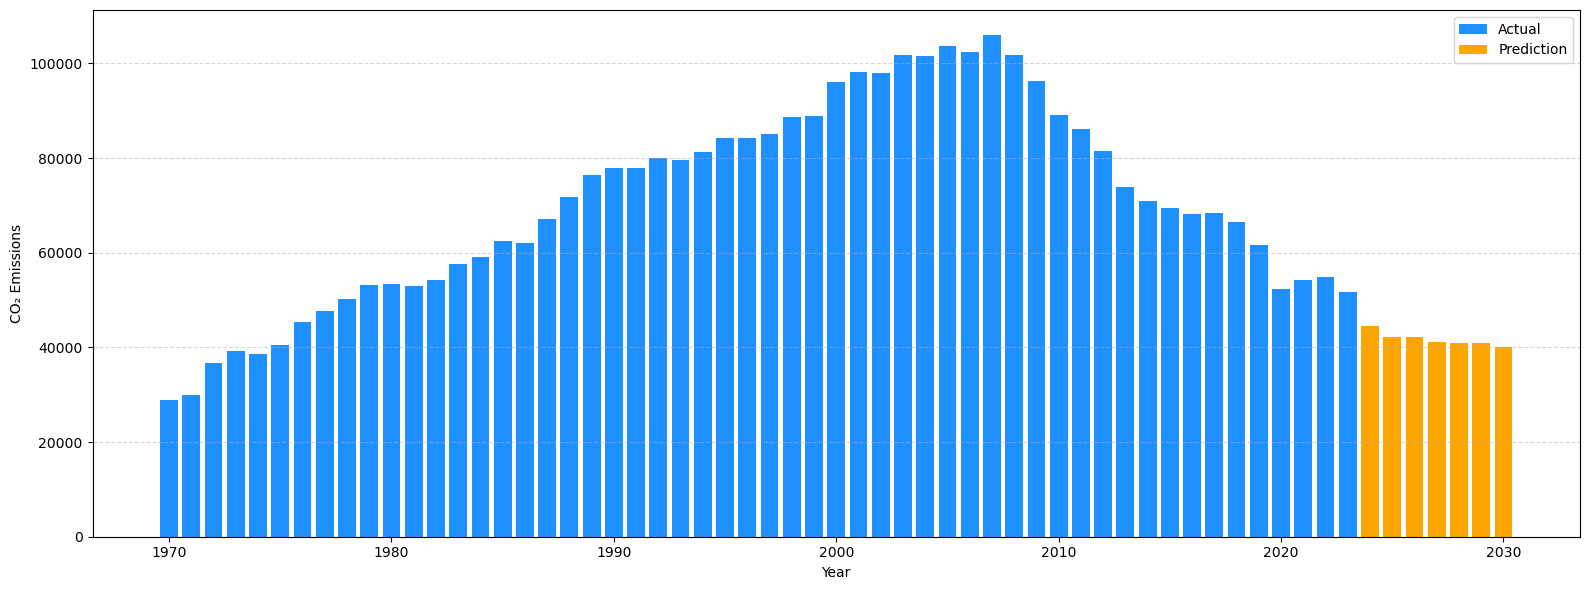

----------------------------------------------------------------
Forecasting Croatia
Picked: rf
  algorithm          mae           mse         rmse         r2
0        rf  1464.286071  2.573124e+06  1604.096000   0.432678
1   xgboost  1600.952639  2.973413e+06  1724.358648   0.344423
2       knn  1446.392881  3.061341e+06  1749.668795   0.325036
3    sarima  7214.883770  6.502218e+07  8063.633429 -13.336079


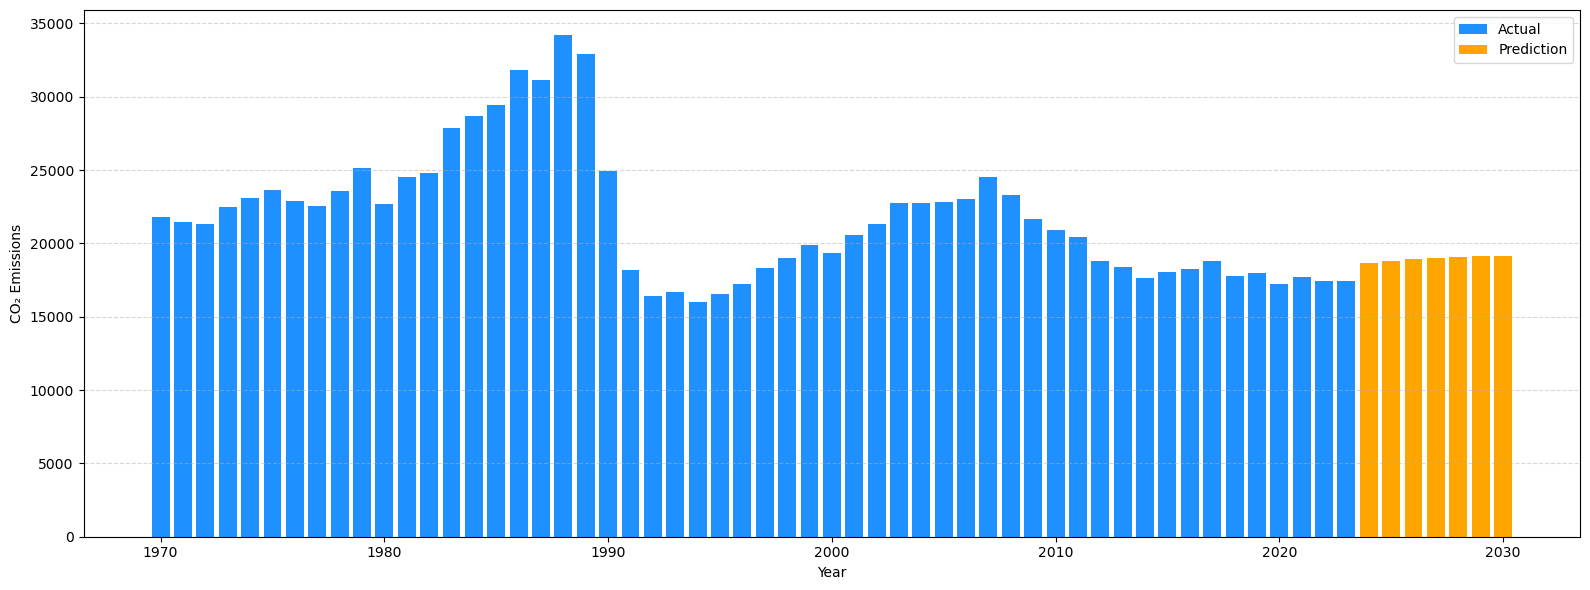

----------------------------------------------------------------
Forecasting Hungary
Picked: knn
  algorithm           mae           mse          rmse        r2
2       knn  11165.103420  1.404551e+08  11851.373400 -7.802794
0        rf  11207.807450  1.423038e+08  11929.115699 -7.918662
3    sarima  11306.458679  1.437968e+08  11991.528620 -8.012230
1   xgboost  12267.635365  1.698415e+08  13032.324337 -9.644541


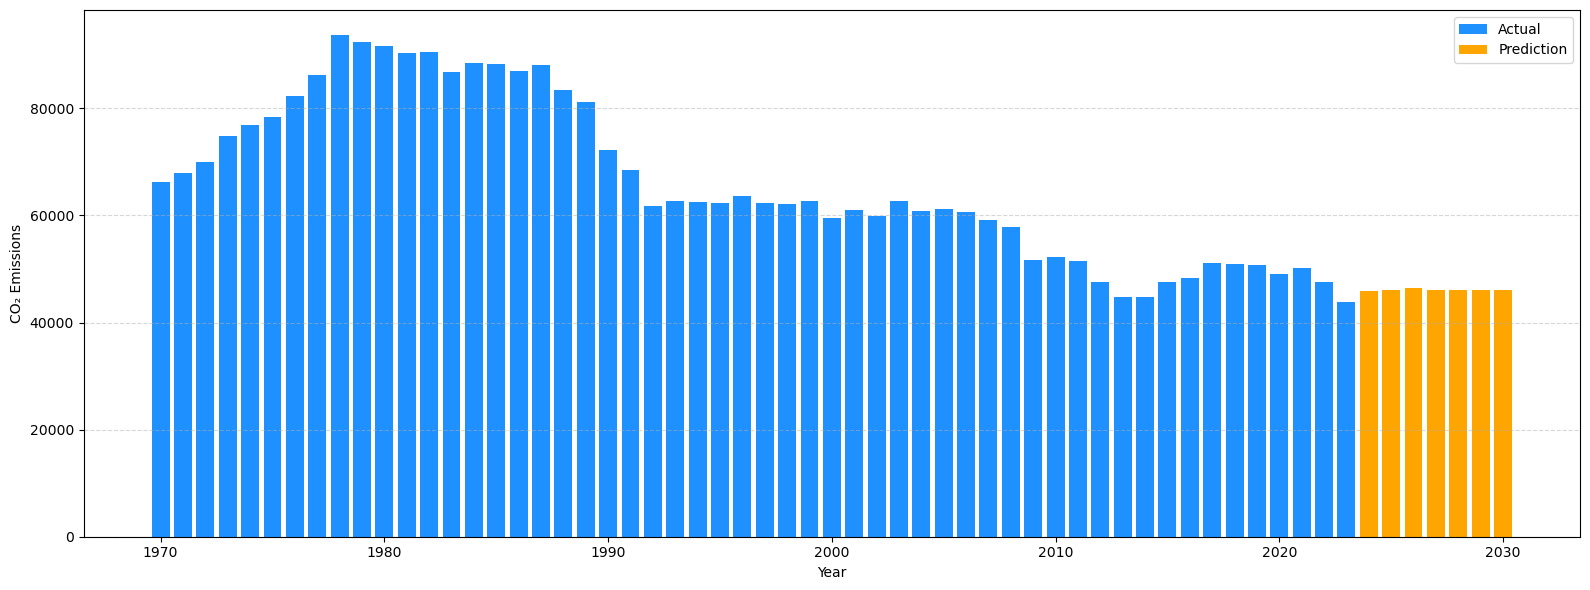

----------------------------------------------------------------
Forecasting Ireland
Picked: knn
  algorithm           mae           mse          rmse         r2
2       knn   2775.252769  1.240113e+07   3521.524474   0.164933
0        rf   5814.091783  3.992492e+07   6318.616827  -1.688464
1   xgboost   9224.321930  1.005334e+08  10026.636173  -5.769719
3    sarima  18768.797143  4.243141e+08  20598.886247 -27.572458


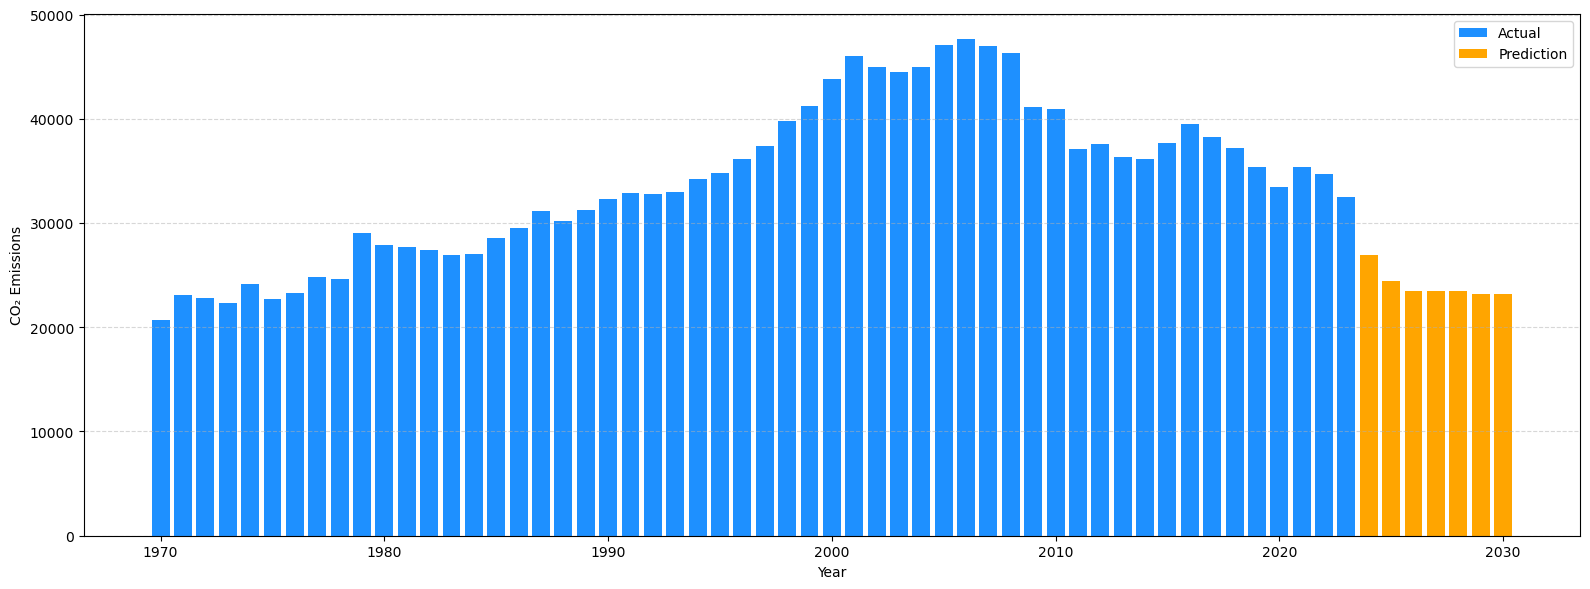

----------------------------------------------------------------
Forecasting Iceland
Picked: xgboost
  algorithm         mae            mse        rmse        r2
1   xgboost  265.701144  106644.016157  326.563954 -0.681819
0        rf  281.160943  121508.461607  348.580639 -0.916237
2       knn  306.638547  143791.022688  379.197867 -1.267642
3    sarima  421.072731  249156.495283  499.155783 -2.929298


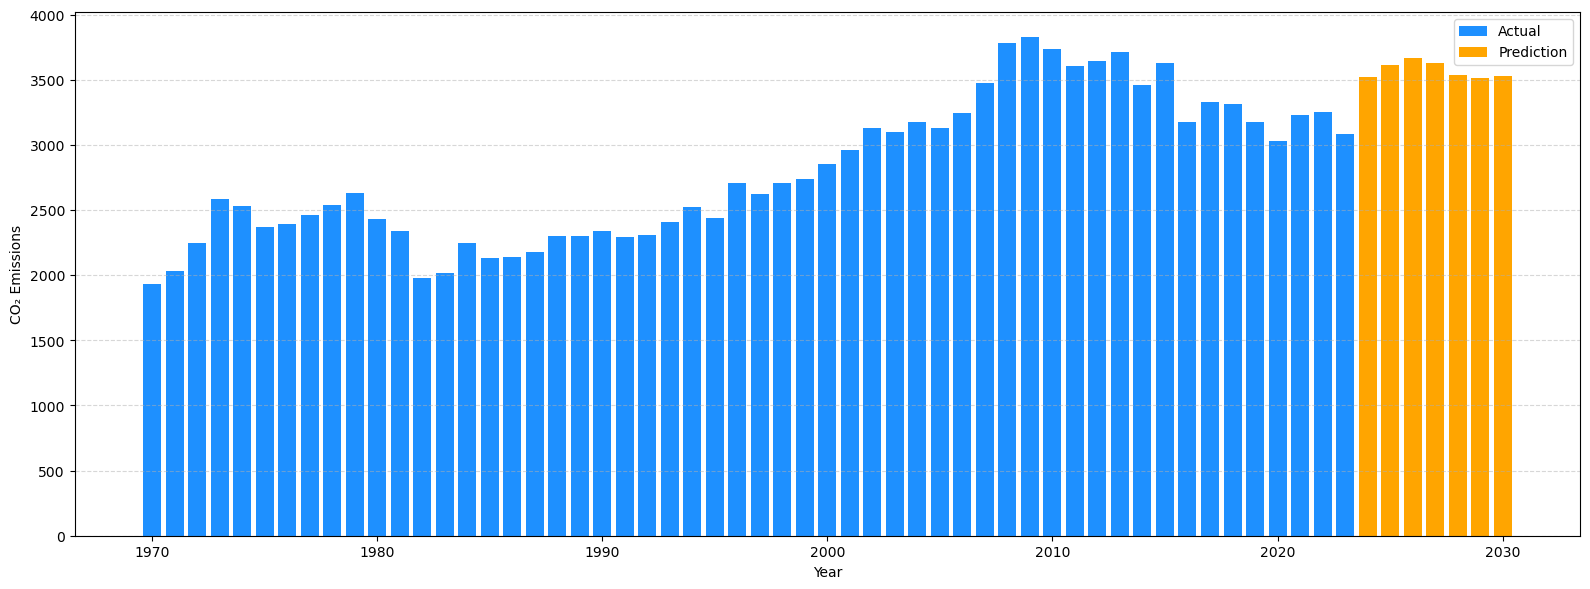

----------------------------------------------------------------
Forecasting Italy
Picked: knn
  algorithm            mae           mse           rmse         r2
2       knn   35680.904598  1.632903e+09   40409.188431   0.389747
0        rf   67500.422720  5.234141e+09   72347.366247  -0.956119
1   xgboost  107026.280262  1.351386e+10  116249.127588  -4.050440
3    sarima  176408.360279  3.733067e+10  193211.454899 -12.951328


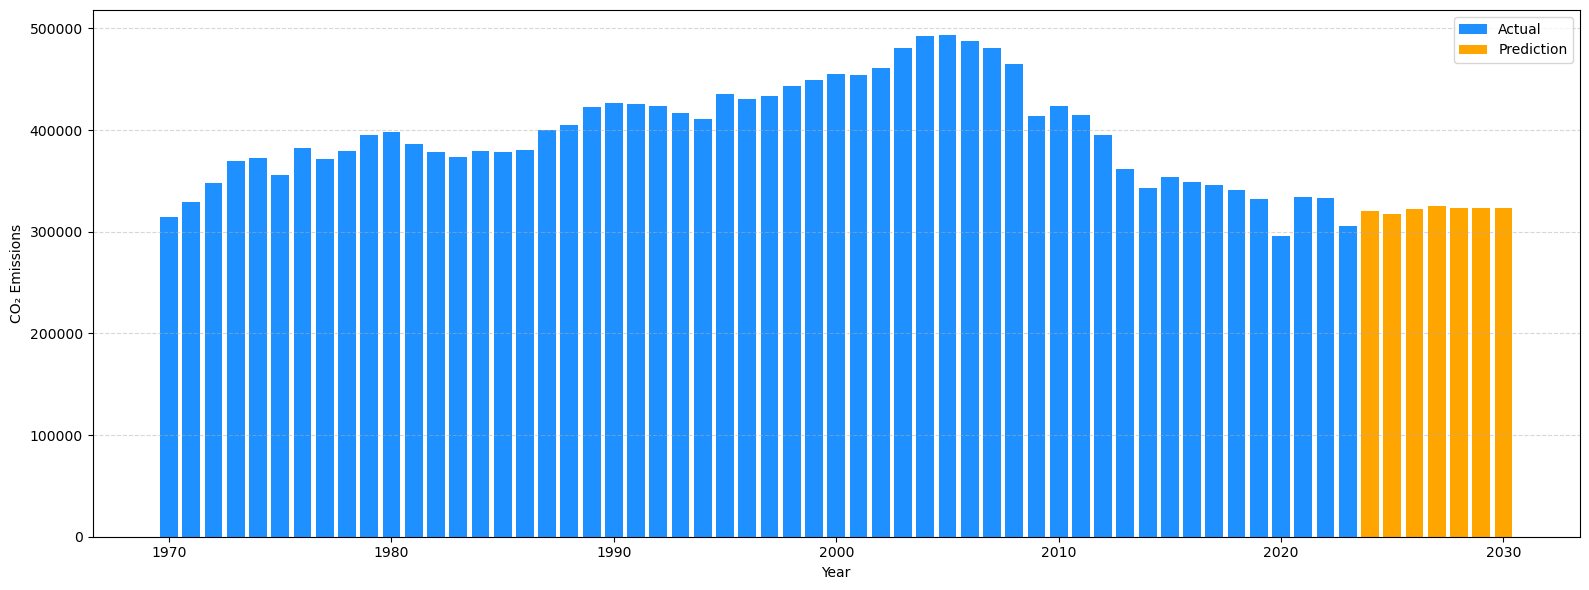

----------------------------------------------------------------
Forecasting Lithuania
Picked: knn
  algorithm          mae           mse         rmse          r2
2       knn   534.444702  4.437346e+05   666.134046    0.238605
0        rf   543.301379  4.808985e+05   693.468440    0.174836
1   xgboost   563.726175  5.649339e+05   751.620872    0.030641
3    sarima  7410.085921  7.403759e+07  8604.510034 -126.039641


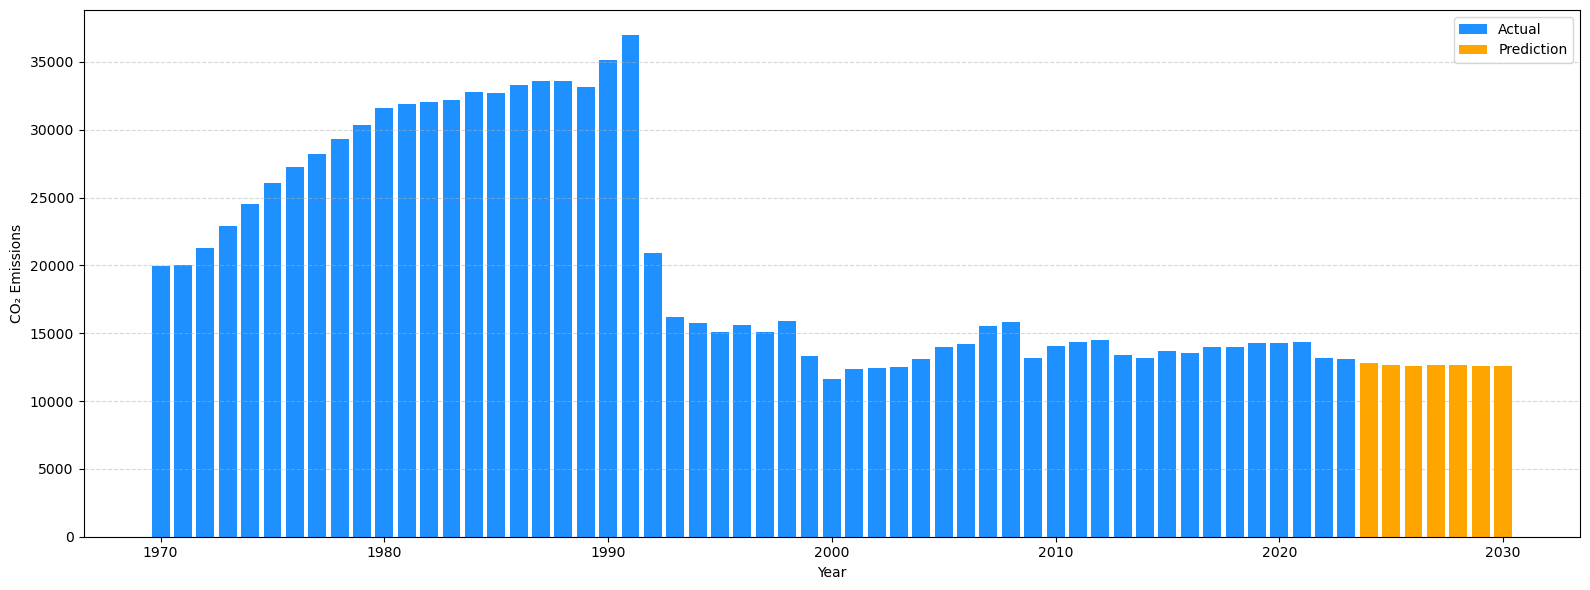

----------------------------------------------------------------
Forecasting Luxembourg
Picked: knn
  algorithm          mae           mse         rmse        r2
2       knn   753.570709  9.568201e+05   978.171824  0.471371
0        rf   774.763875  1.000151e+06  1000.075361  0.447431
1   xgboost  1226.644907  2.138521e+06  1462.368269 -0.181501
3    sarima  1329.257134  2.722217e+06  1649.914327 -0.503985


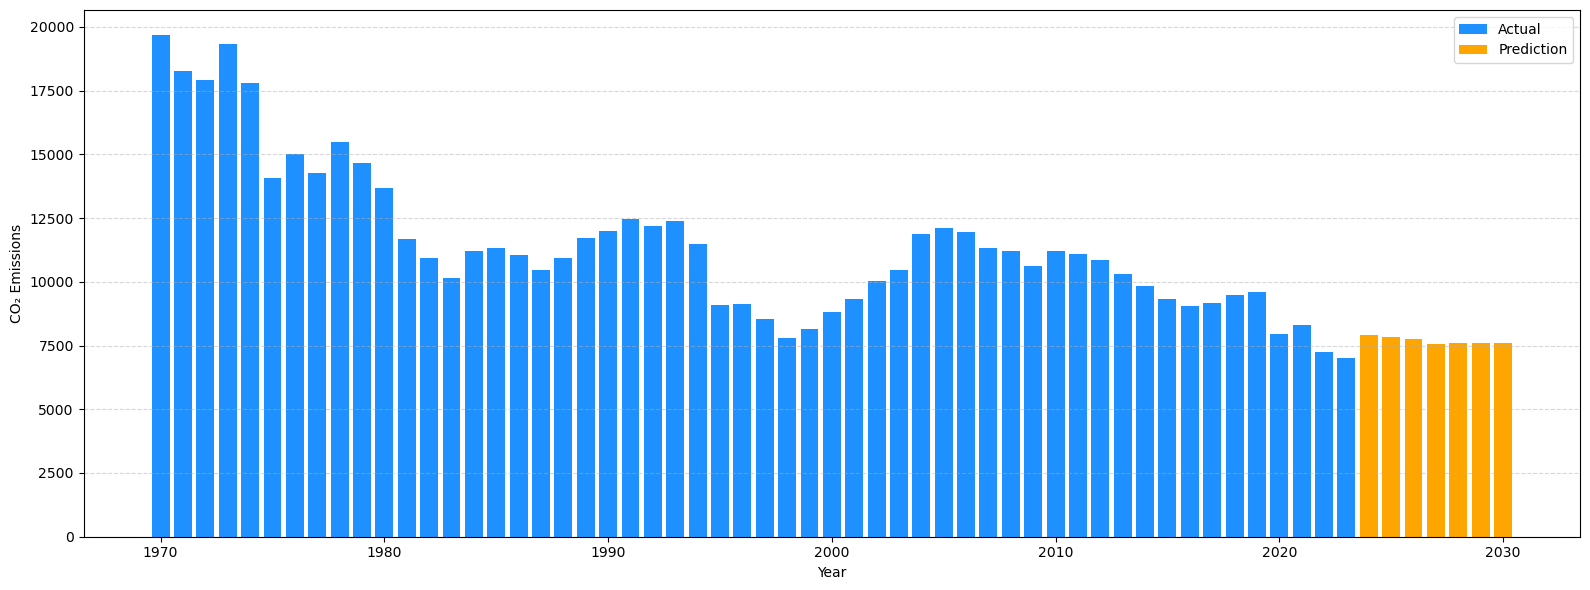

----------------------------------------------------------------
Forecasting Latvia
Picked: rf
  algorithm          mae           mse         rmse        r2
0        rf   540.373749  4.287450e+05   654.786213 -0.067714
2       knn   539.301039  4.513362e+05   671.815587 -0.123973
1   xgboost   750.913891  7.550477e+05   868.934794 -0.880313
3    sarima  1684.259512  3.861761e+06  1965.136298 -8.617035


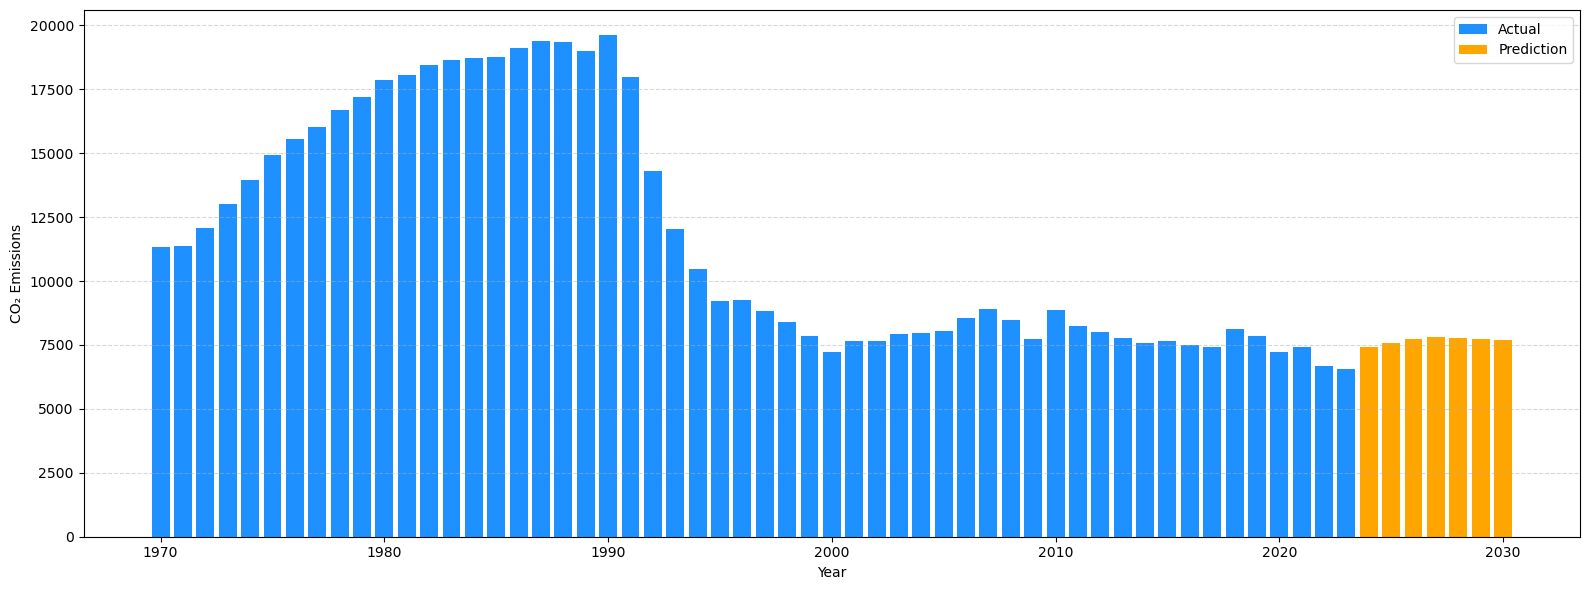

----------------------------------------------------------------
Forecasting North Macedonia
Picked: rf
  algorithm          mae           mse         rmse        r2
0        rf   738.783775  7.561167e+05   869.549688  0.120674
1   xgboost   805.752842  9.452934e+05   972.261980 -0.099329
2       knn   908.545611  1.099568e+06  1048.602915 -0.278742
3    sarima  1616.165950  3.433227e+06  1852.896871 -2.992670


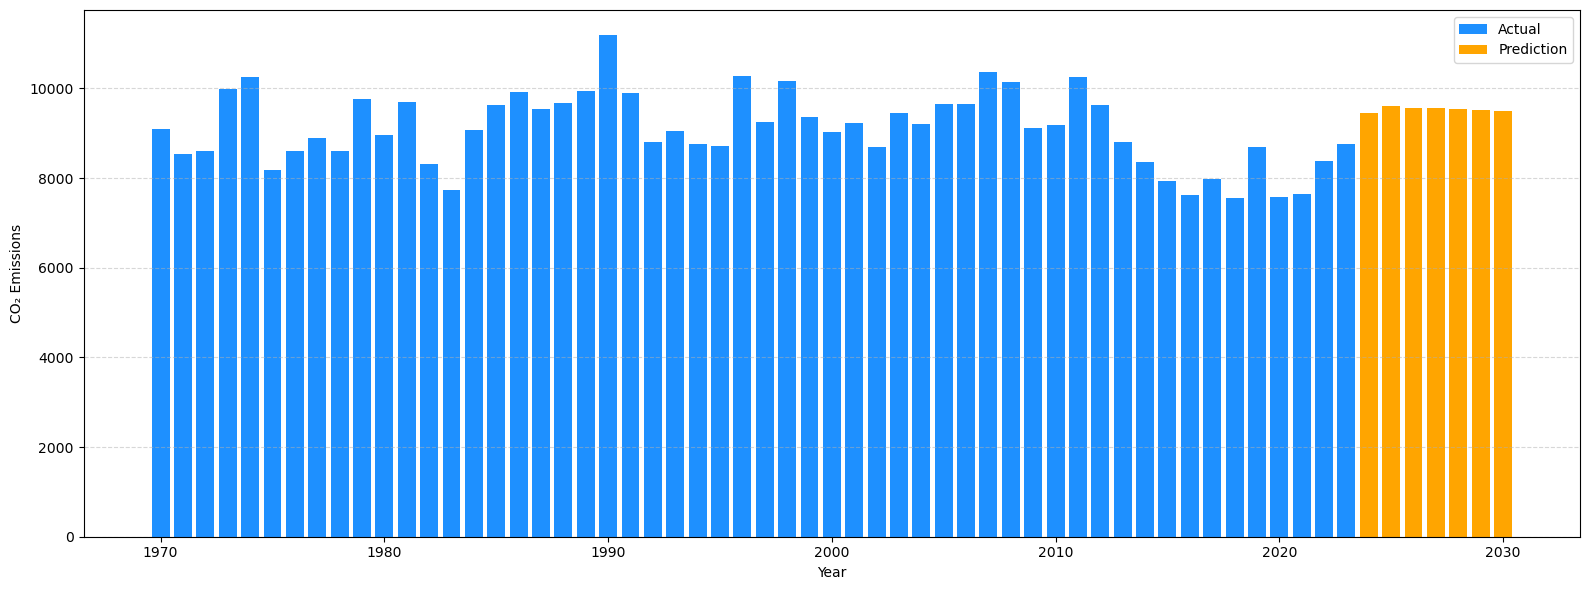

----------------------------------------------------------------
Forecasting Malta
Picked: rf
  algorithm          mae           mse         rmse         r2
0        rf   340.687523  1.743884e+05   417.598390   0.292866
1   xgboost   400.224254  2.422087e+05   492.147046   0.017858
2       knn   494.945011  3.756793e+05   612.926854  -0.523357
3    sarima  1448.990598  2.818088e+06  1678.716044 -10.427175


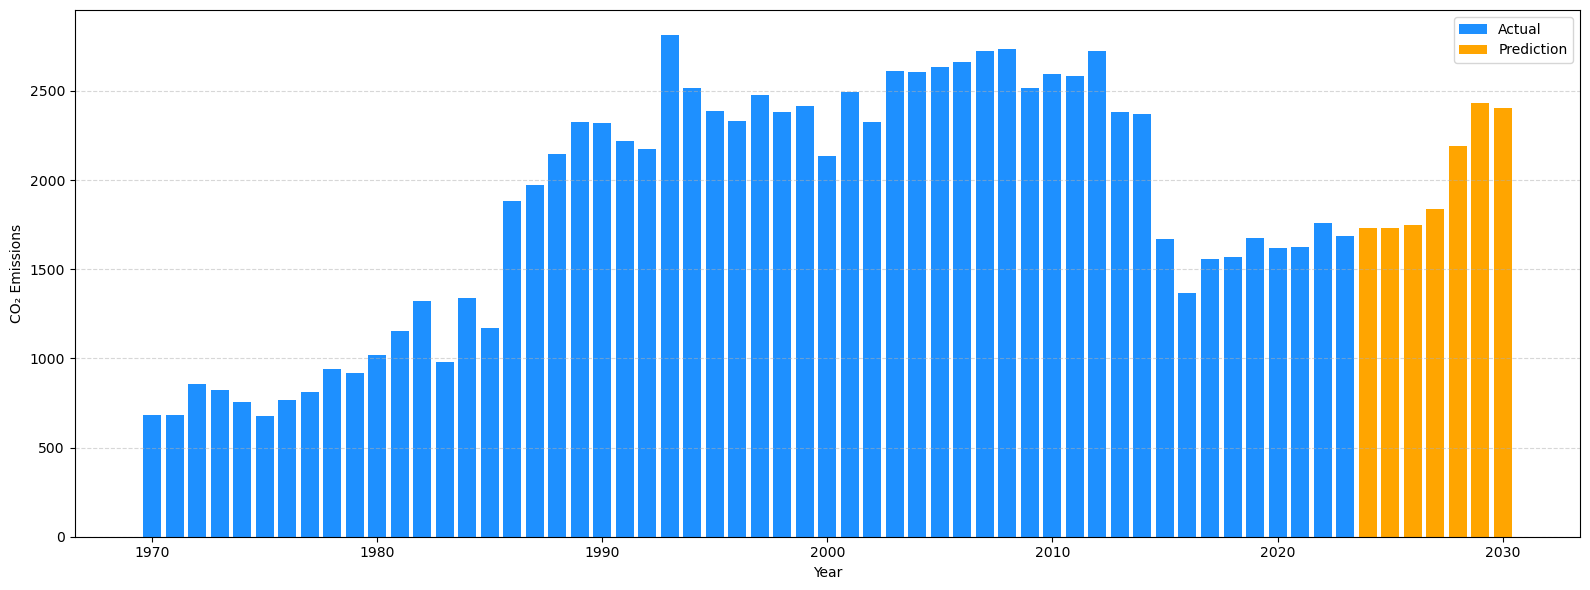

----------------------------------------------------------------
Forecasting Netherlands
Picked: knn
  algorithm           mae           mse          rmse        r2
2       knn   8906.359140  1.241246e+08  11141.121367  0.564896
0        rf  12836.049869  3.071077e+08  17524.489776 -0.076529
1   xgboost  16759.562396  5.460879e+08  23368.523314 -0.914245
3    sarima  24561.991742  9.718111e+08  31173.884852 -2.406566


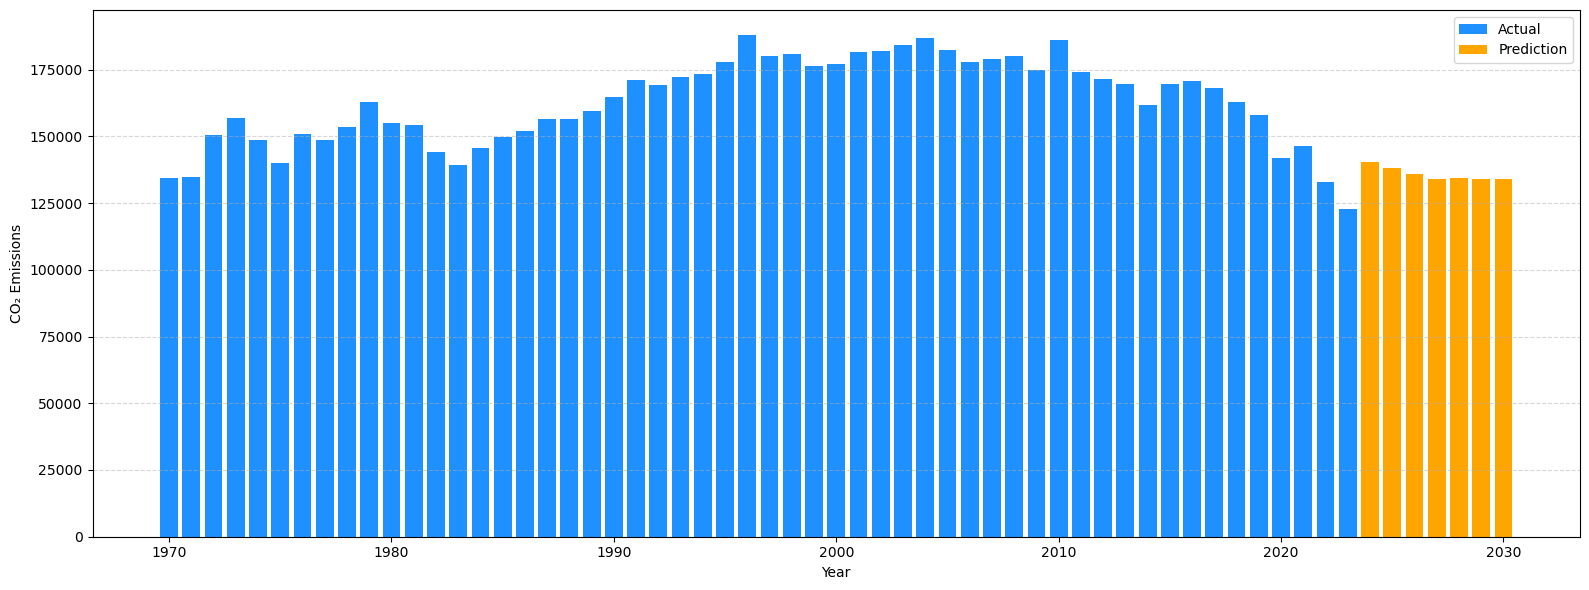

----------------------------------------------------------------
Forecasting Norway
Picked: rf
  algorithm          mae           mse         rmse         r2
0        rf  1961.814372  5.211681e+06  2282.910641  -2.347919
1   xgboost  2053.997478  5.750207e+06  2397.958918  -2.693861
2       knn  2786.417755  9.129194e+06  3021.455568  -4.864480
3    sarima  2943.010853  1.909621e+07  4369.920982 -11.267166


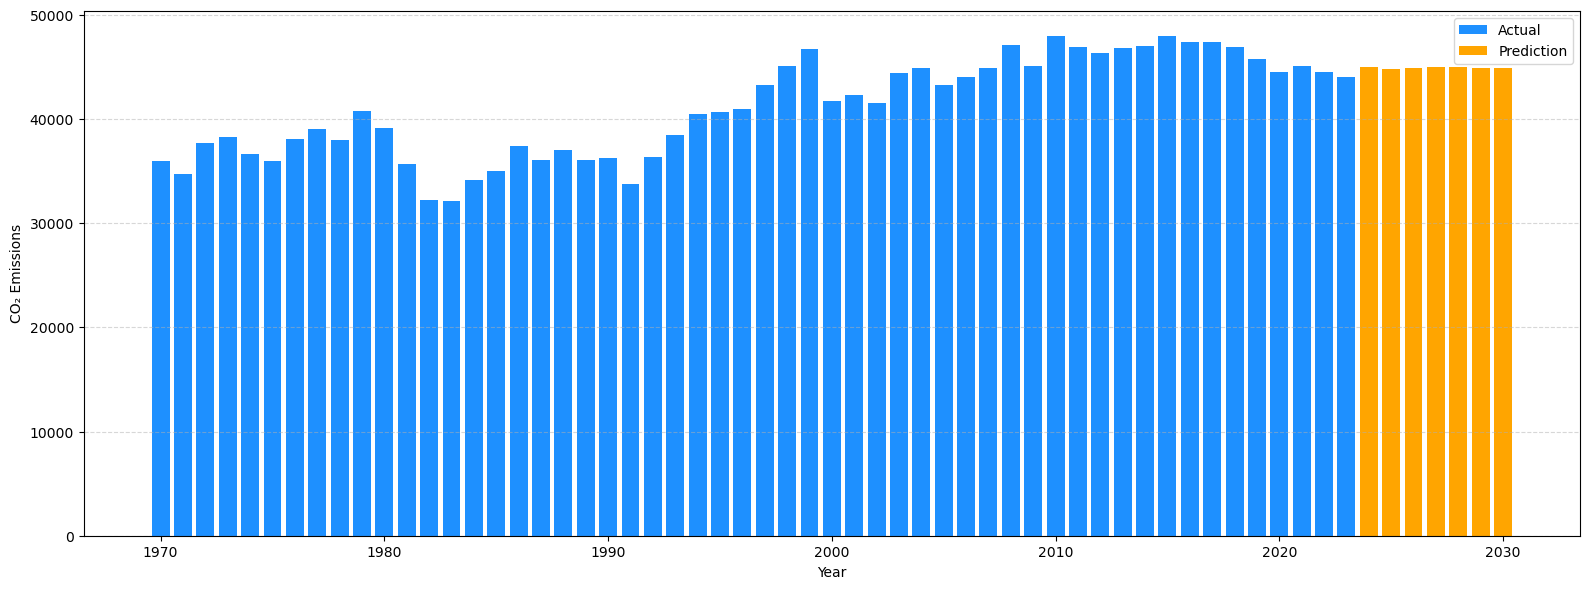

----------------------------------------------------------------
Forecasting Poland
Picked: rf
  algorithm           mae           mse          rmse        r2
0        rf   9932.529707  1.777256e+08  13331.375477 -0.175185
2       knn  10180.080345  1.868277e+08  13668.494242 -0.235371
3    sarima  15126.683527  3.579448e+08  18919.428382 -1.366858
1   xgboost  15591.340785  4.168729e+08  20417.465959 -1.756512


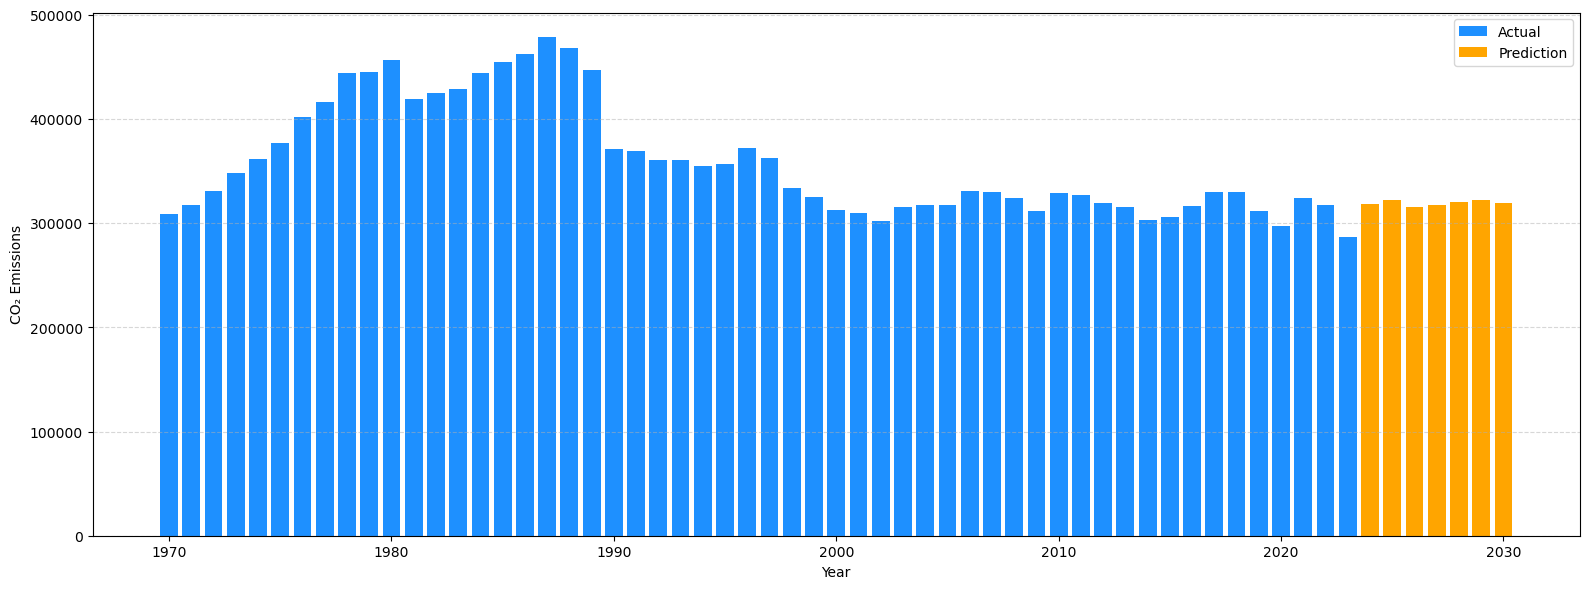

----------------------------------------------------------------
Forecasting Portugal
Picked: knn
  algorithm           mae           mse          rmse         r2
2       knn   6350.481428  5.224573e+07   7228.120764  -0.033869
0        rf   9983.044354  1.212211e+08  11010.045645  -1.398793
1   xgboost  13223.060473  2.119835e+08  14559.654333  -3.194852
3    sarima  27591.621656  9.617929e+08  31012.785342 -18.032510


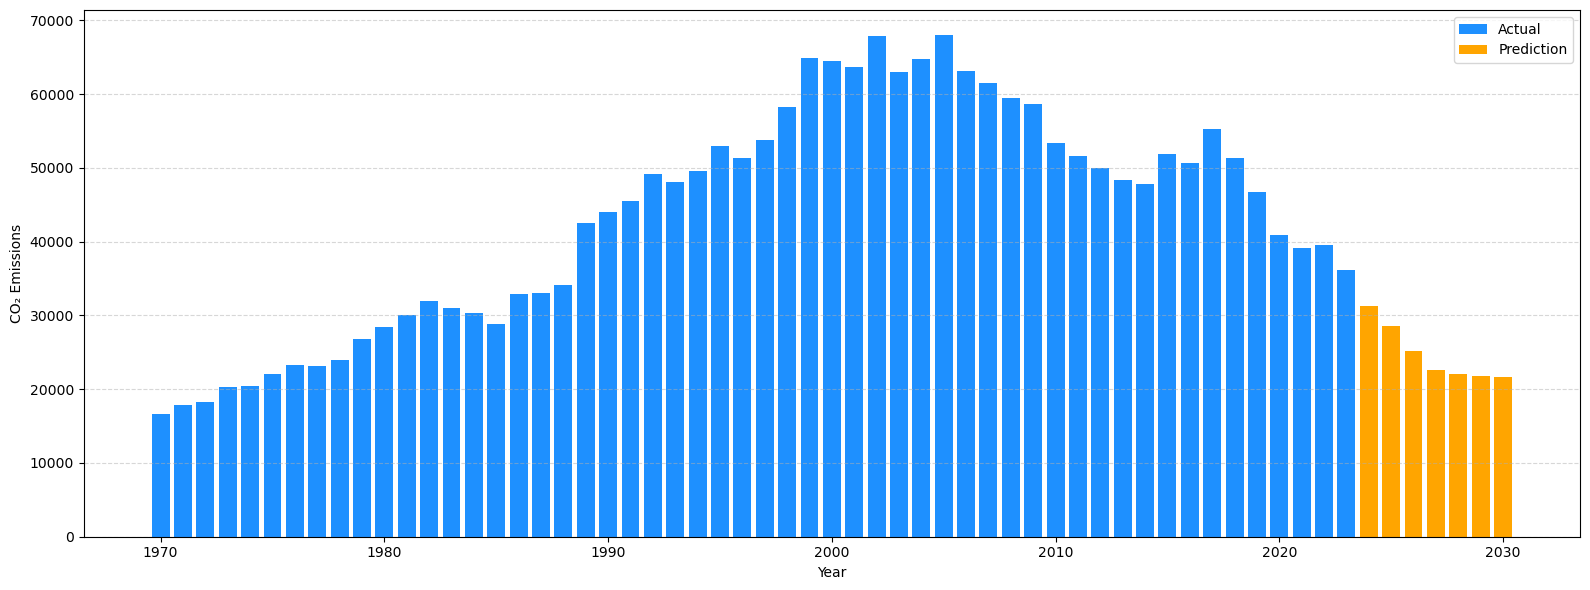

----------------------------------------------------------------
Forecasting Romania
Picked: rf
  algorithm           mae           mse          rmse        r2
0        rf  20723.359661  4.920309e+08  22181.768669 -4.725198
2       knn  21577.413695  5.415581e+08  23271.401150 -5.301490
3    sarima  24470.699846  6.842256e+08  26157.705466 -6.961547
1   xgboost  25963.134840  7.640180e+08  27640.875372 -7.890000


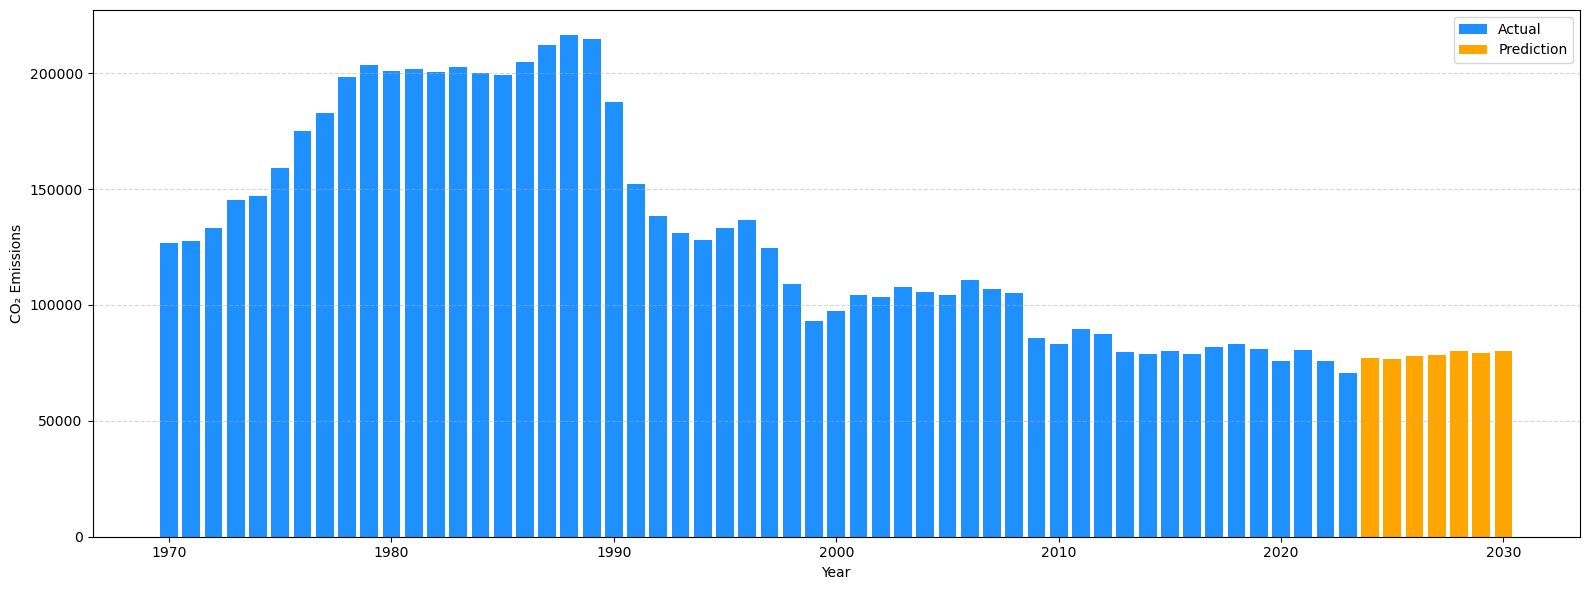

----------------------------------------------------------------
Forecasting Slovakia
Picked: sarima
  algorithm          mae           mse         rmse        r2
3    sarima  4447.957691  2.430521e+07  4930.031016 -3.414755
1   xgboost  5326.487970  3.387320e+07  5820.068847 -5.152669
2       knn  5443.195017  3.513382e+07  5927.378844 -5.381646
0        rf  5590.310741  3.688064e+07  6072.942995 -5.698935


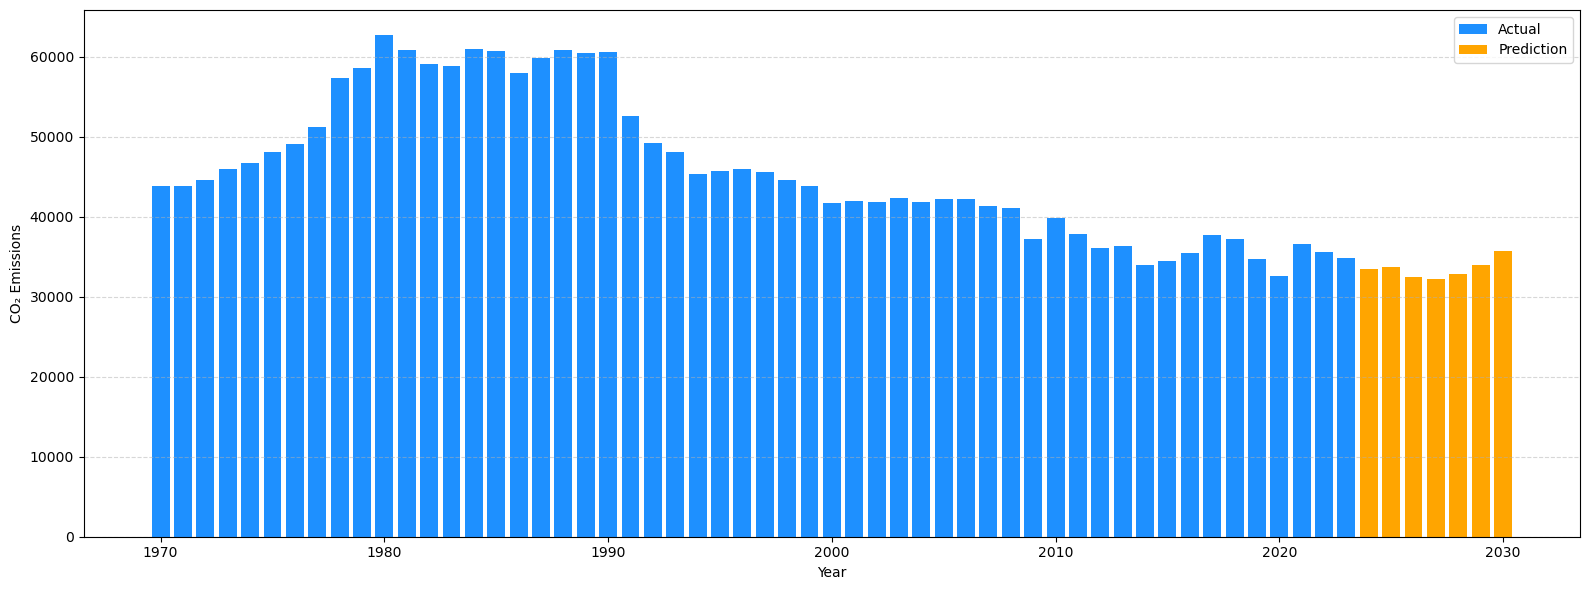

----------------------------------------------------------------
Forecasting Slovenia
Picked: knn
  algorithm          mae           mse         rmse         r2
2       knn   803.452995  1.035713e+06  1017.699895   0.649223
0        rf  1576.028537  3.181303e+06  1783.620741  -0.077450
1   xgboost  1996.488067  5.848703e+06  2418.409177  -0.980851
3    sarima  5933.085776  4.425791e+07  6652.661734 -13.989359


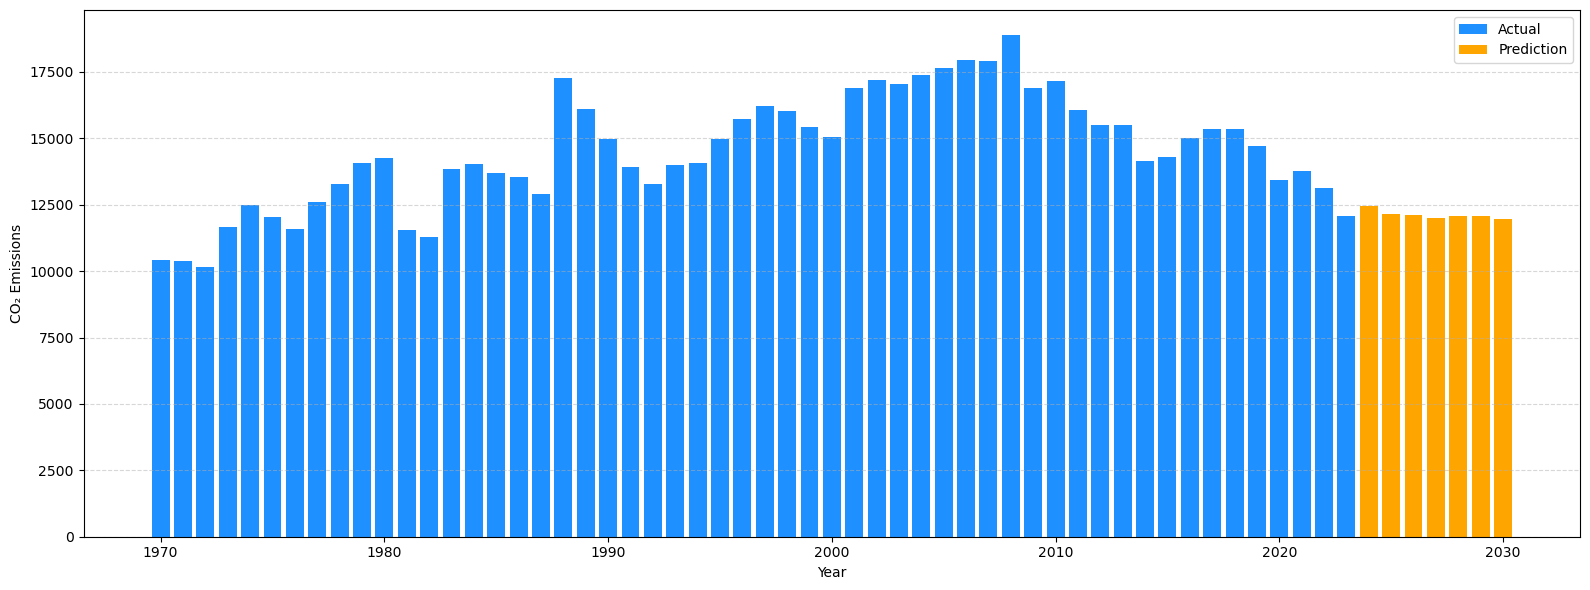

----------------------------------------------------------------
Forecasting Sweden
Picked: sarima
  algorithm           mae           mse          rmse        r2
3    sarima   7998.616693  8.036904e+07   8964.878364 -1.796963
0        rf  12464.126567  1.842297e+08  13573.124078 -5.411468
1   xgboost  12647.028274  1.897538e+08  13775.114466 -5.603714
2       knn  14126.734457  2.292795e+08  15141.979536 -6.979270


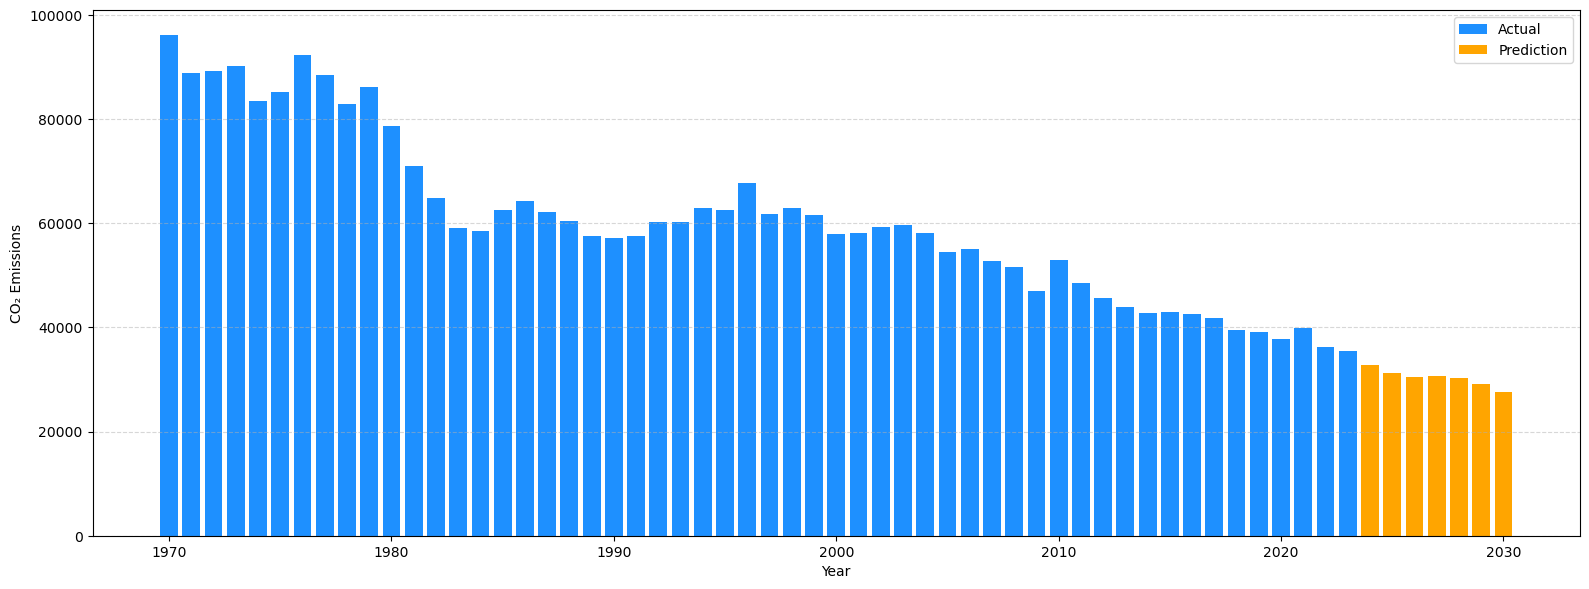

----------------------------------------------------------------
Forecasting Russia
Picked: knn
  algorithm           mae           mse           rmse        r2
2       knn  48037.112682  3.522143e+09   59347.647381  0.683912
0        rf  50892.275630  3.841012e+09   61975.896386  0.655296
3    sarima  63994.998137  6.019275e+09   77583.985630  0.459812
1   xgboost  72643.683412  1.025609e+10  101272.375513  0.079587


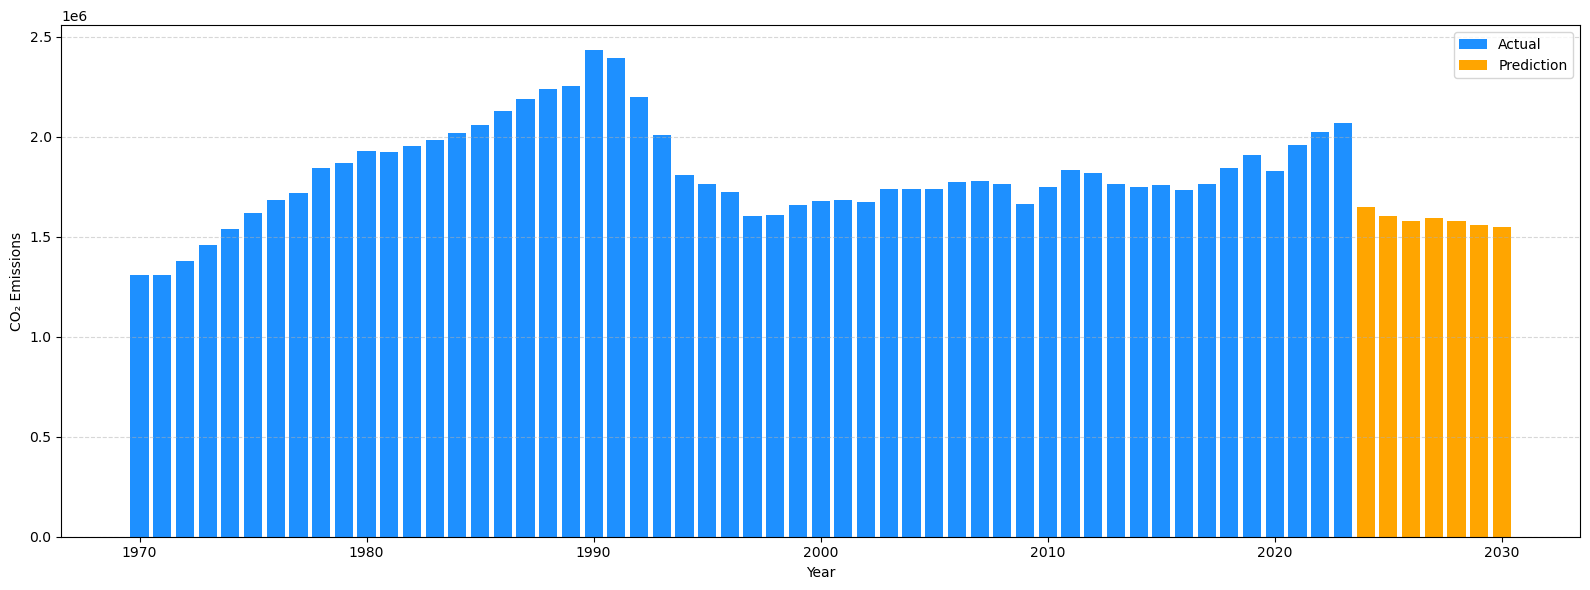

----------------------------------------------------------------
Forecasting Ukraine
Picked: sarima
  algorithm            mae           mse           rmse        r2
3    sarima   58713.187489  4.860709e+09   69718.784819  0.008810
0        rf  114033.224691  1.797853e+10  134084.033069 -2.666158
2       knn  113159.998972  1.800022e+10  134164.890158 -2.670581
1   xgboost  124024.954509  2.057918e+10  143454.469582 -3.196481


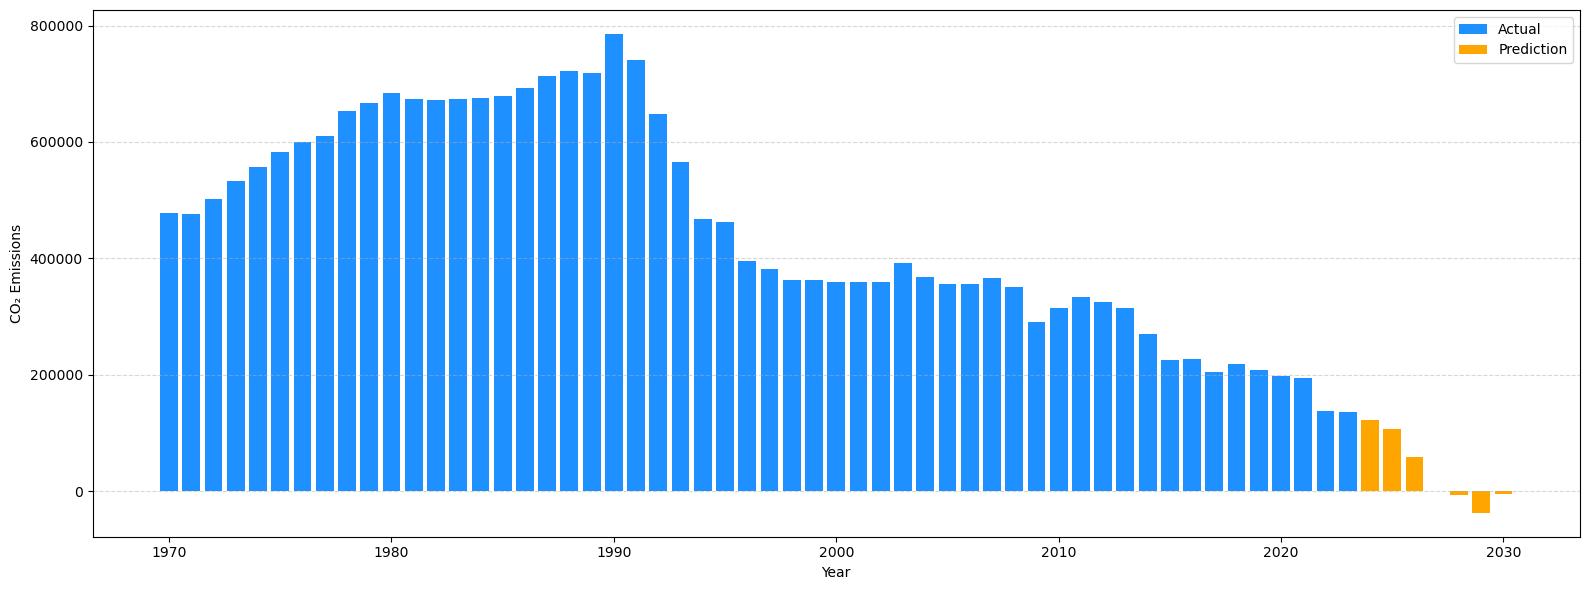

----------------------------------------------------------------
Forecasting Belarus
Picked: rf
  algorithm           mae           mse          rmse         r2
0        rf   1761.898348  4.632027e+06   2152.214462   0.528934
1   xgboost   1954.177449  4.972454e+06   2229.900061   0.494313
2       knn   1997.087253  6.032944e+06   2456.205256   0.386464
3    sarima  10609.474056  1.769415e+08  13301.937609 -16.994543


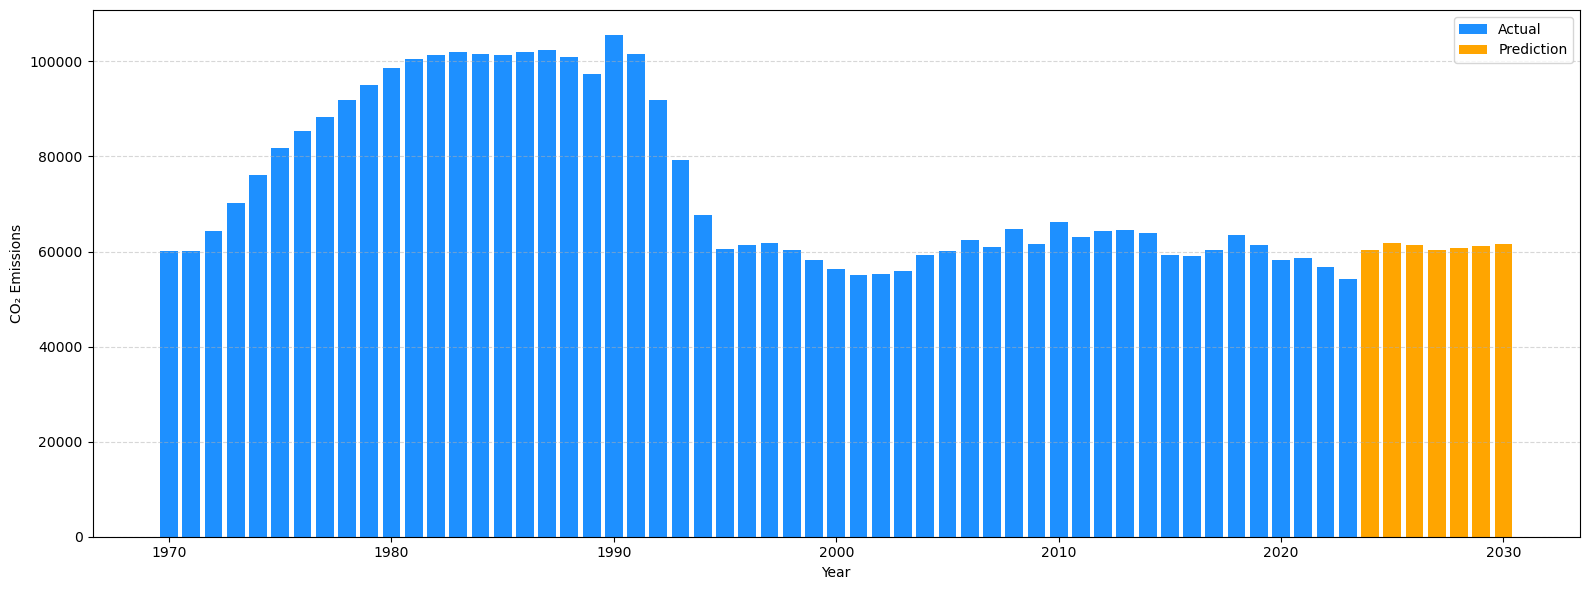

----------------------------------------------------------------
Forecasting Moldova
Picked: xgboost
  algorithm          mae           mse         rmse        r2
1   xgboost   599.131127  6.260950e+05   791.261655 -0.476848
0        rf   629.829863  6.655722e+05   815.826066 -0.569968
2       knn   799.906528  1.015795e+06  1007.866350 -1.396081
3    sarima  1283.864476  2.243383e+06  1497.792726 -4.291747


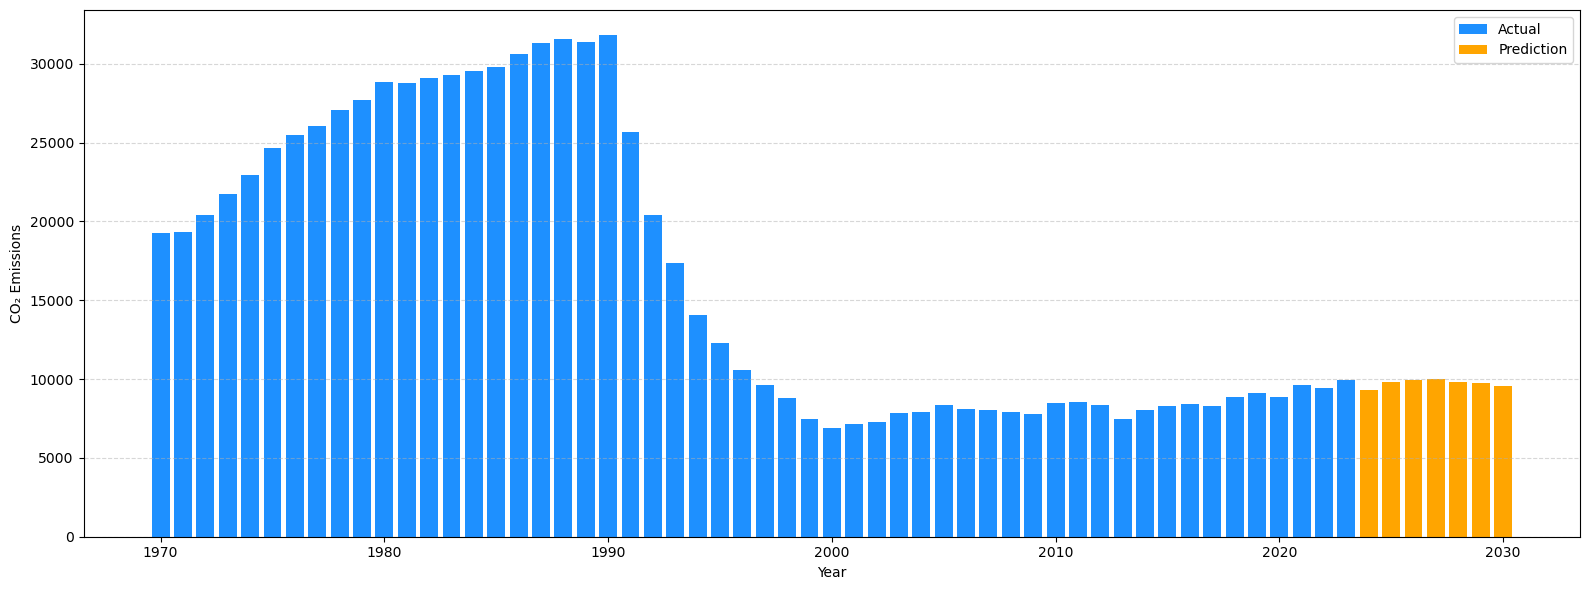

----------------------------------------------------------------
Forecasting Serbia
Picked: rf
  algorithm           mae           mse          rmse         r2
0        rf   2612.461907  8.732650e+06   2955.105771   0.046007
1   xgboost   2629.748798  1.012578e+07   3182.103323  -0.106185
2       knn   4224.861750  2.242130e+07   4735.113281  -1.449400
3    sarima  20271.100993  4.954821e+08  22259.426620 -53.128621


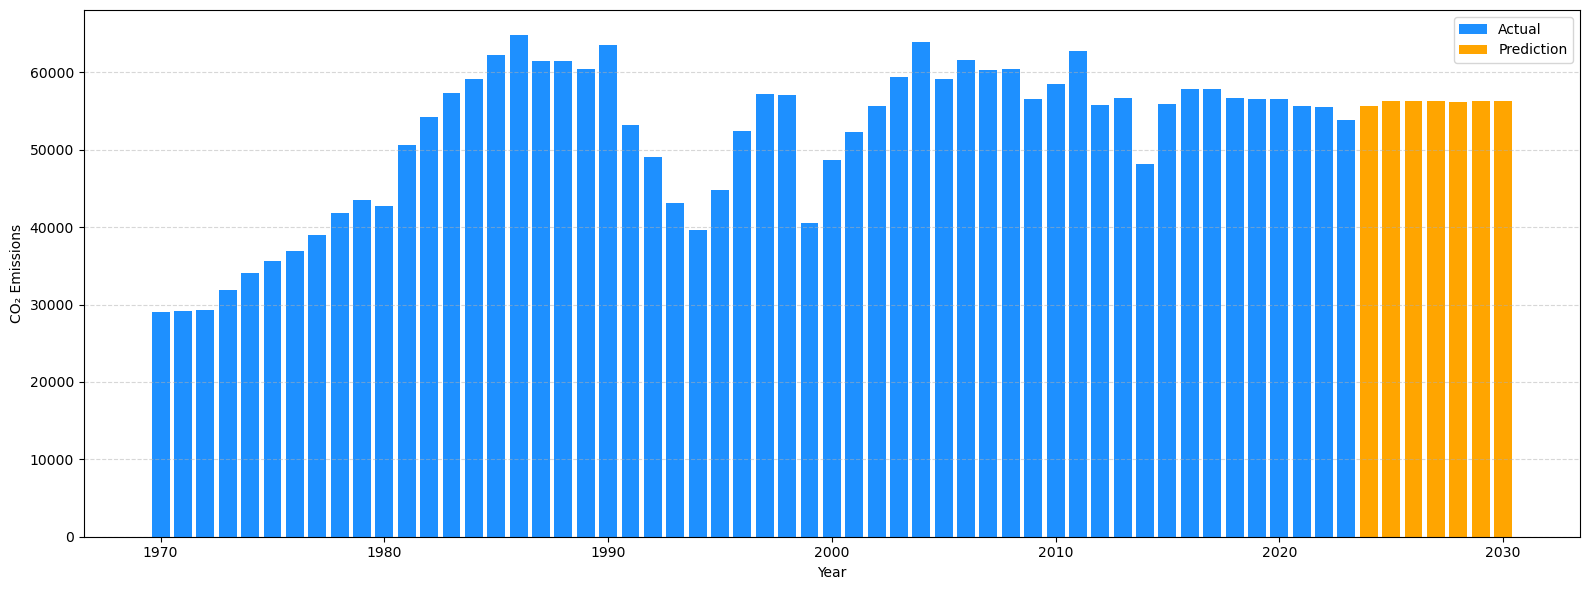

----------------------------------------------------------------
Forecasting Montenegro
Picked: rf
  algorithm         mae           mse         rmse         r2
0        rf  110.197326  1.456128e+04   120.670136   0.083735
1   xgboost  109.579348  1.758043e+04   132.591213  -0.106244
2       knn  137.947875  2.692382e+04   164.084807  -0.694175
3    sarima  963.215092  1.107820e+06  1052.530415 -68.709314


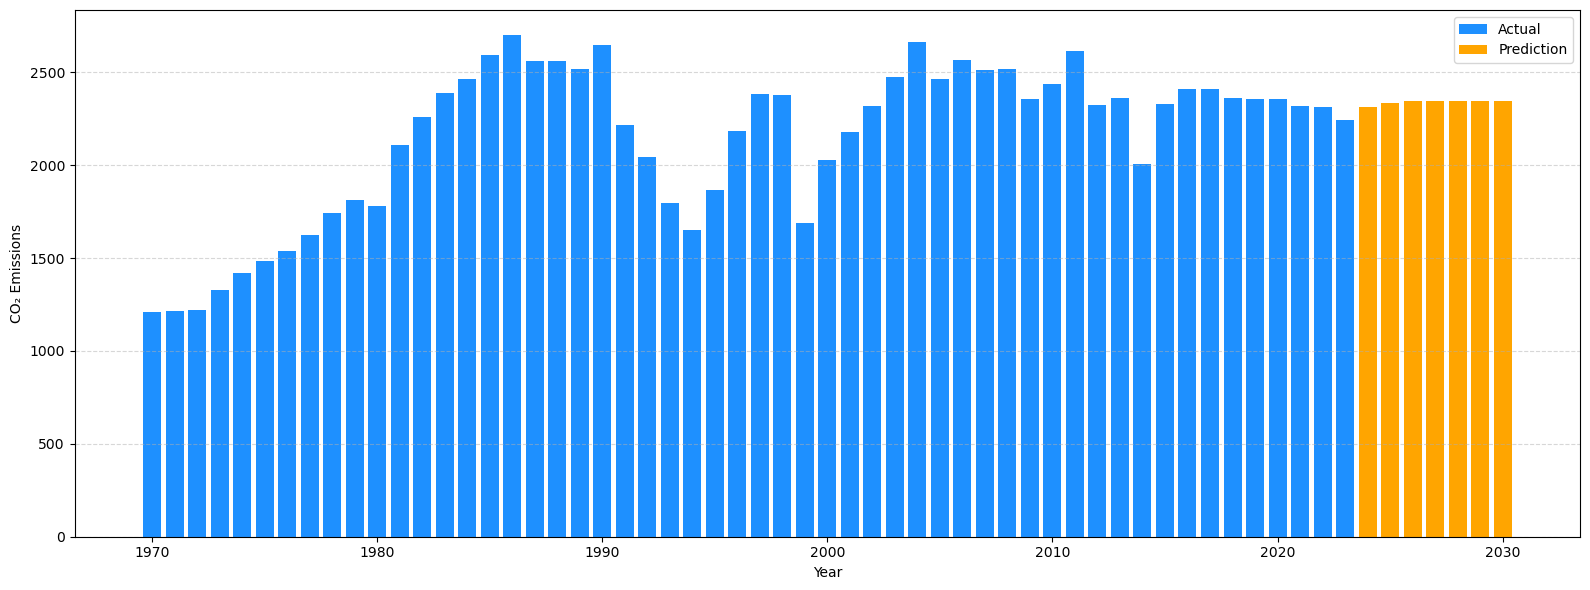

----------------------------------------------------------------


In [8]:
init_cols = ['Name', 'Year', 'CO2_emissions']

year_from = 2024
year_to = 2030
eval_metric = 'rmse'  # 'mae' | 'mse' | 'rmse' | 'r2'
plot_forecasts = True

algorithms = {
    'rf': RandomForestRegressor(random_state=42),
    'xgboost': XGBRegressor(random_state=42, verbosity=0),
    'knn': KNeighborsRegressor(),
    'sarima': 'SARIMA',
    # 'elasticnet': ElasticNet(),
    # 'lasso': Lasso(),
    # 'ridge': Ridge()
}

df_forecasts_all = pd.DataFrame()

countries_list = list(df_co2['Name'].unique())
countries_list
print(countries_list)

for country in countries_list:
    print(f'Forecasting {country}')
    df = df_co2[df_co2['Name'] == country][init_cols].copy()
    df.rename(columns={'Year': 'year'}, inplace=True)
    
    # add features
    df = add_year_features(df)
    df = add_lag_features(df)
    df = add_rolling_features(df)
    
    m, df_eval = eval_and_select_model(df, algorithms, features, eval_metric, target='CO2_emissions')
    print(f'Picked: {m}')
    print(f'{df_eval}')

    year_add = []
    if 'year' not in features: year_add = ['year']
    
    X = df[['CO2_emissions'] + year_add + features]

    # print(X)
    df_forecast = predict_year_by_year(X, m, features, algorithms, year_from, year_to)
    df_forecast['Name'] = country
    
    df_forecasts_all = pd.concat([df_forecasts_all, df_forecast], ignore_index=True)

    if plot_forecasts:
        plt.figure(figsize=(16, 6))
        plt.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)
        plt.bar(df['year'], df['CO2_emissions'], label='Actual', color='dodgerblue')
        plt.bar(df_forecast['year'], df_forecast['CO2_emissions'], label='Prediction', color='orange')
    
        plt.xlabel("Year")
        plt.ylabel("CO₂ Emissions")
        plt.legend()
        plt.tight_layout()
        plt.show()

    print('-'*64)

We can see that the models predict decently for some countries while for others they basically just use the mean of the CO2 emissions. They predict like a straight line. 

This can be further improved by adding different features for each countries and using them to train and evaluate the models.

---------

## Only SARIMA

Predictions for each country, using only the Sarima algorithm.

Forecasting Albania
Picked: sarima


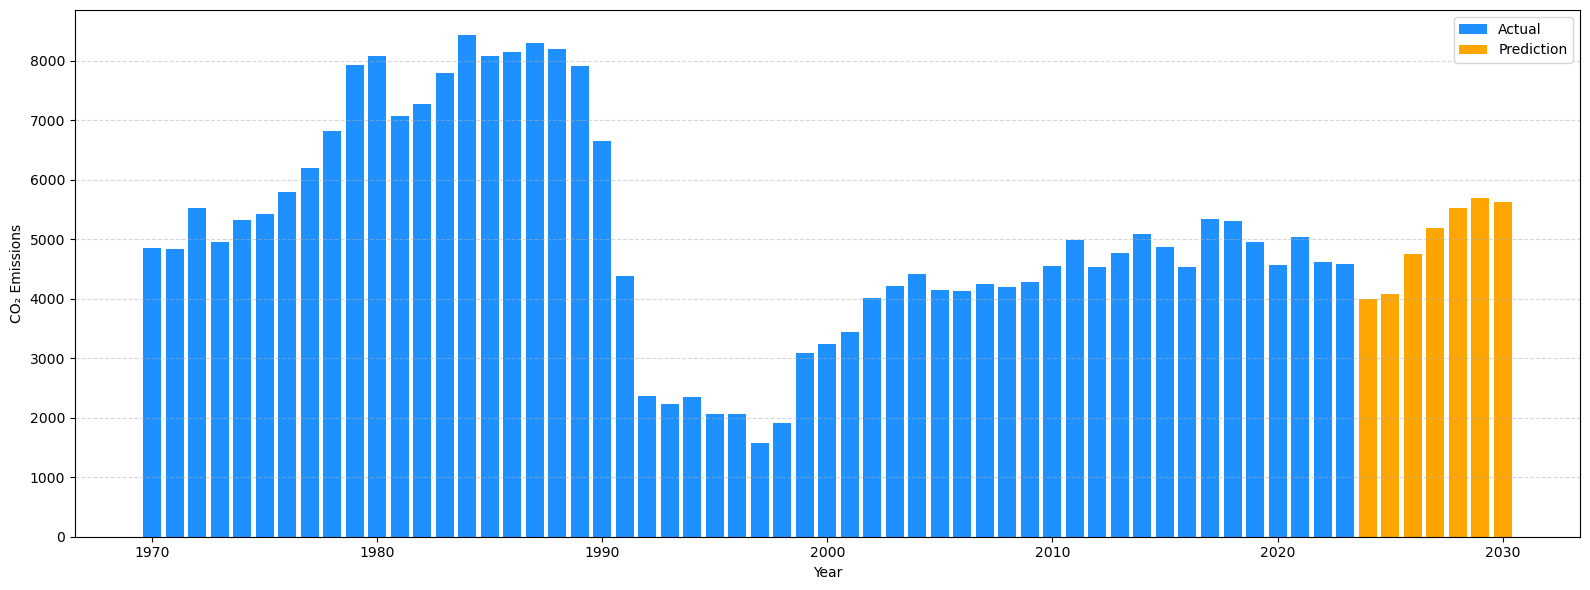

Forecasting Austria
Picked: sarima


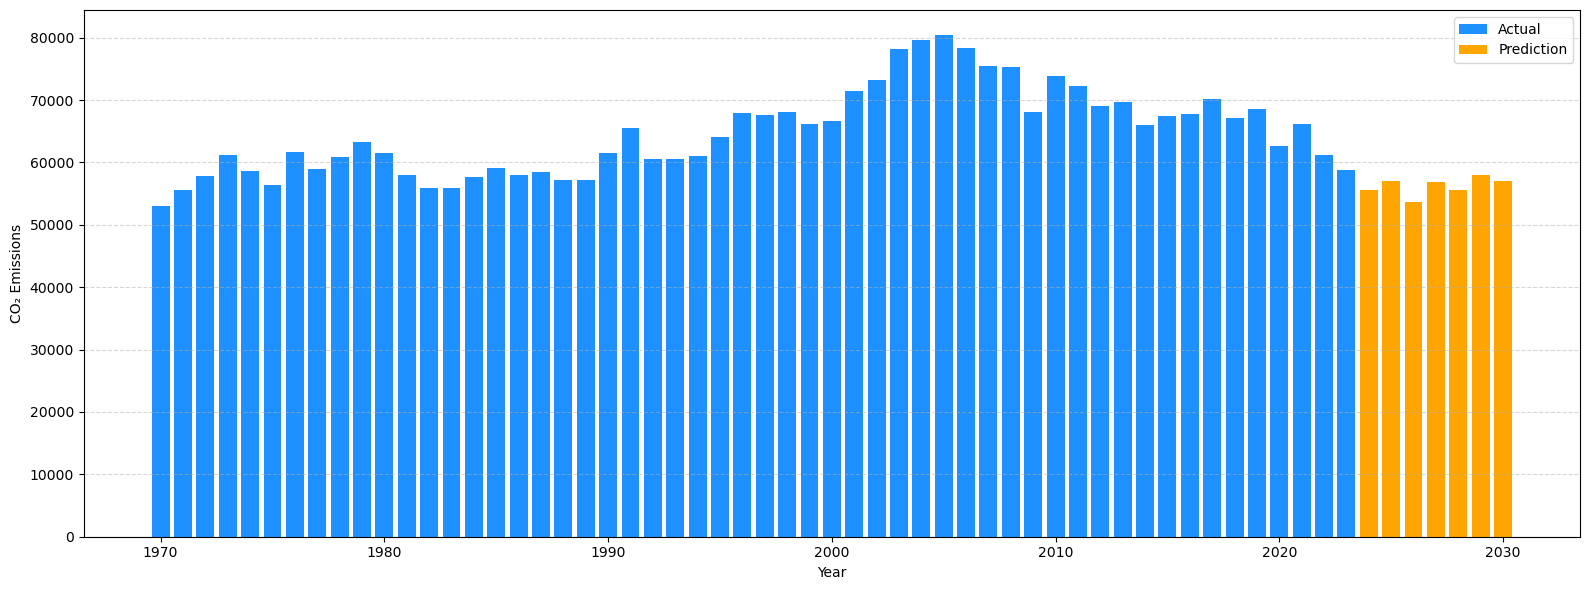

Forecasting Belgium
Picked: sarima


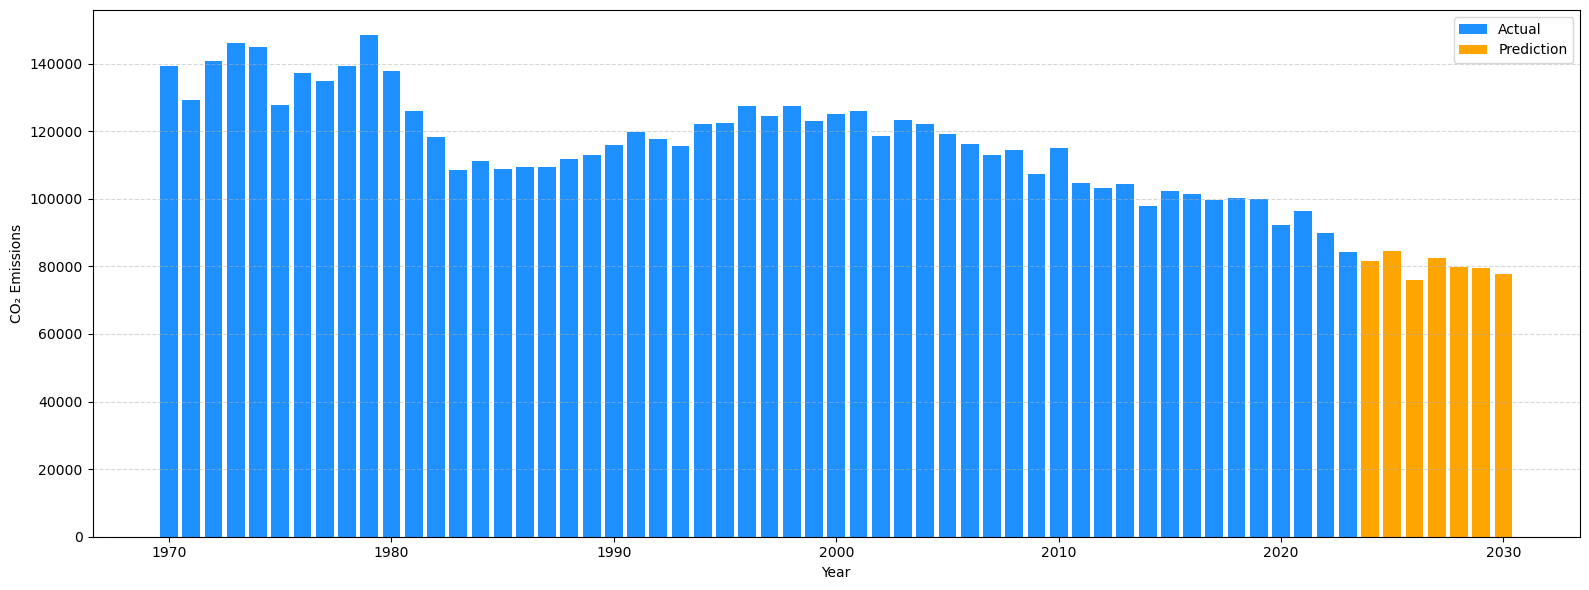

Forecasting Bulgaria
Picked: sarima


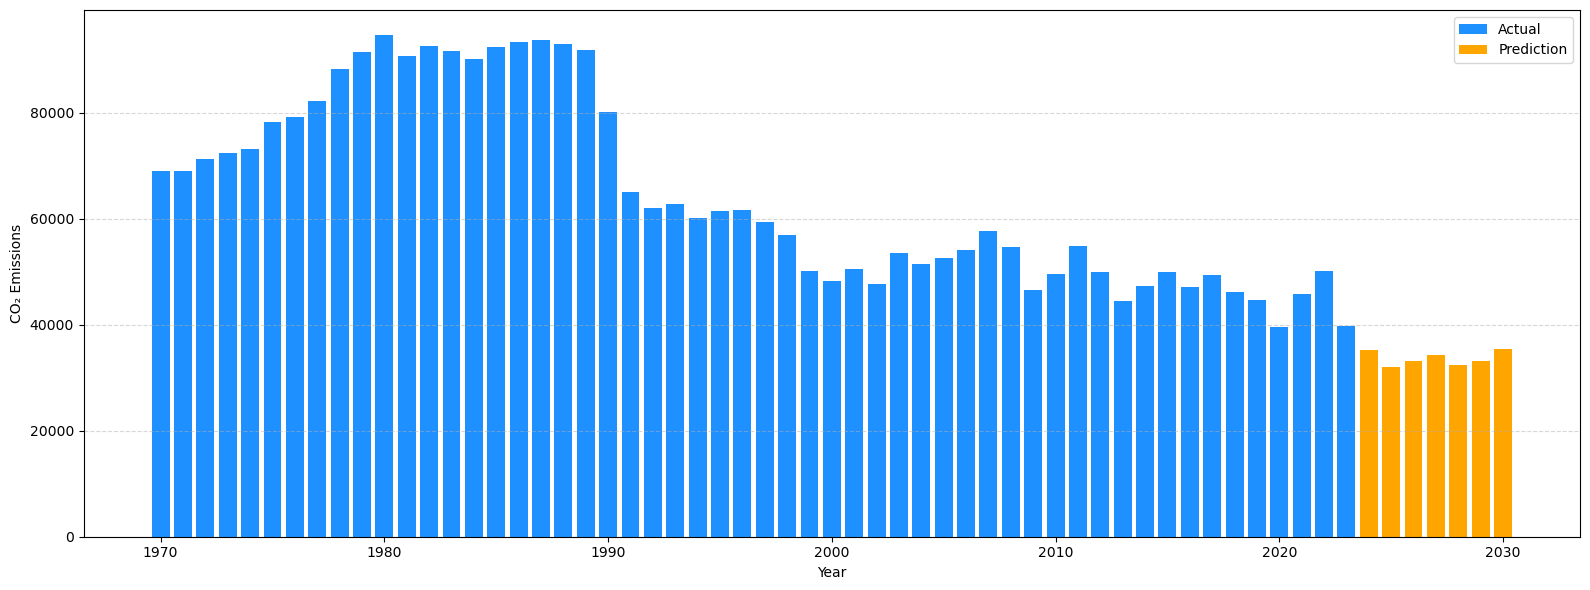

Forecasting Bosnia and Herzegovina
Picked: sarima


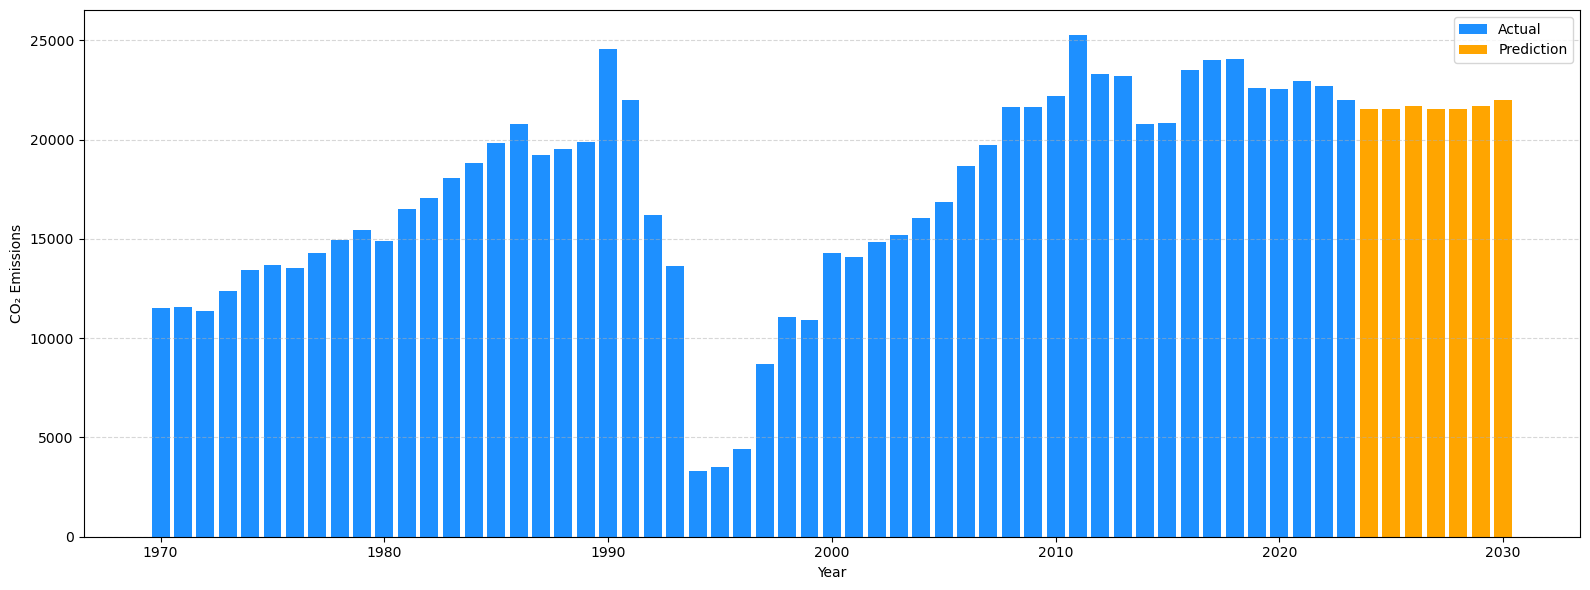

Forecasting Switzerland
Picked: sarima


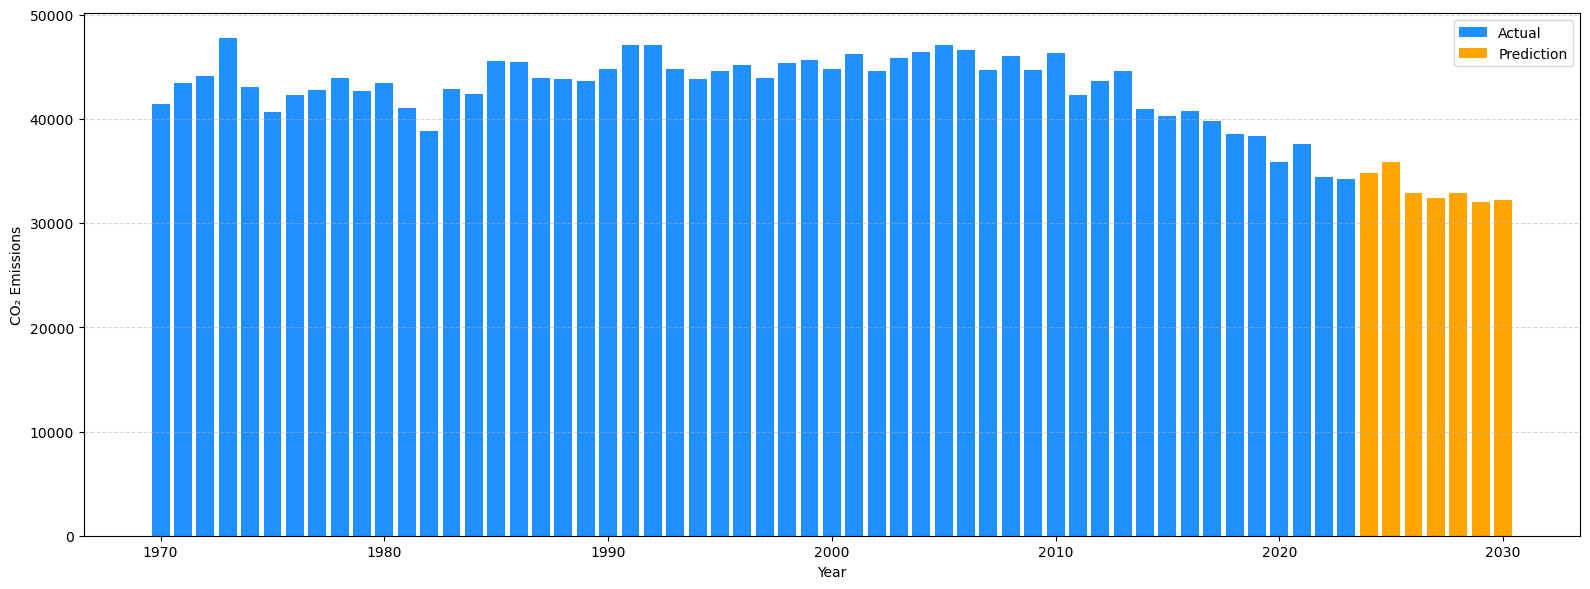

Forecasting Cyprus
Picked: sarima


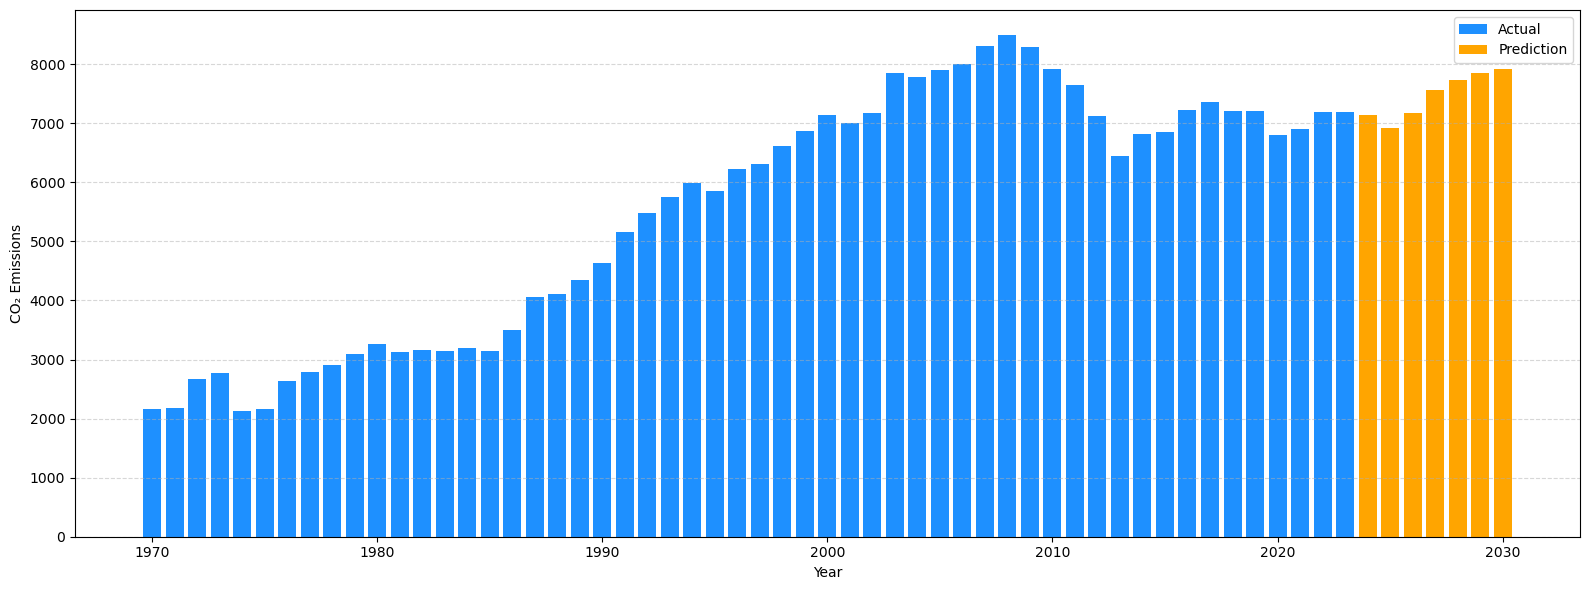

Forecasting Czech Republic
Picked: sarima


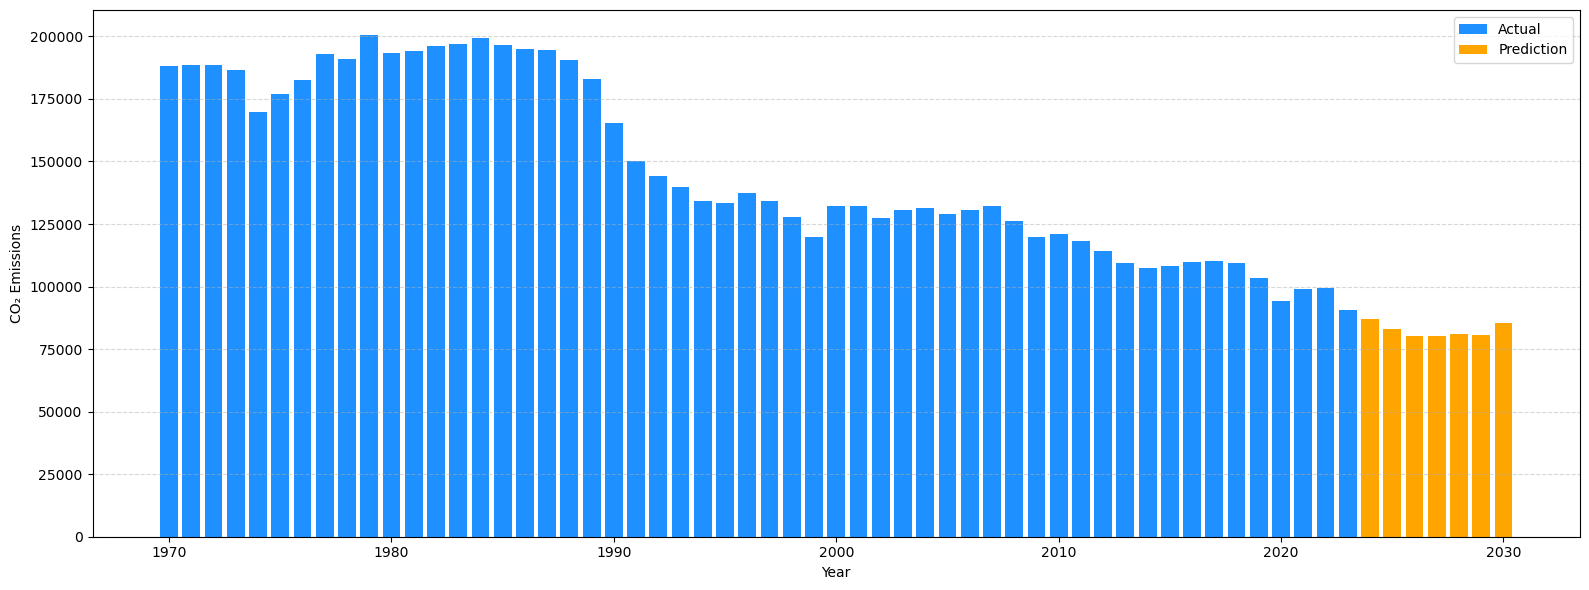

Forecasting Germany
Picked: sarima


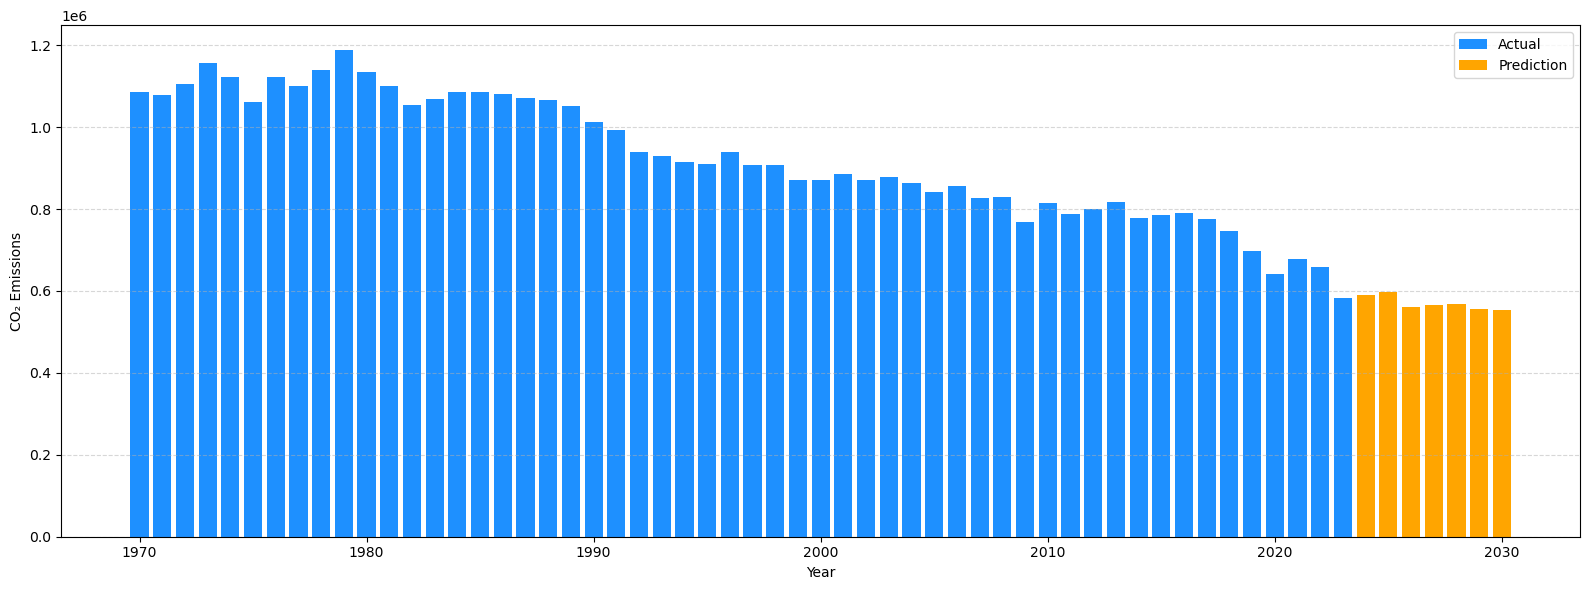

Forecasting Denmark
Picked: sarima


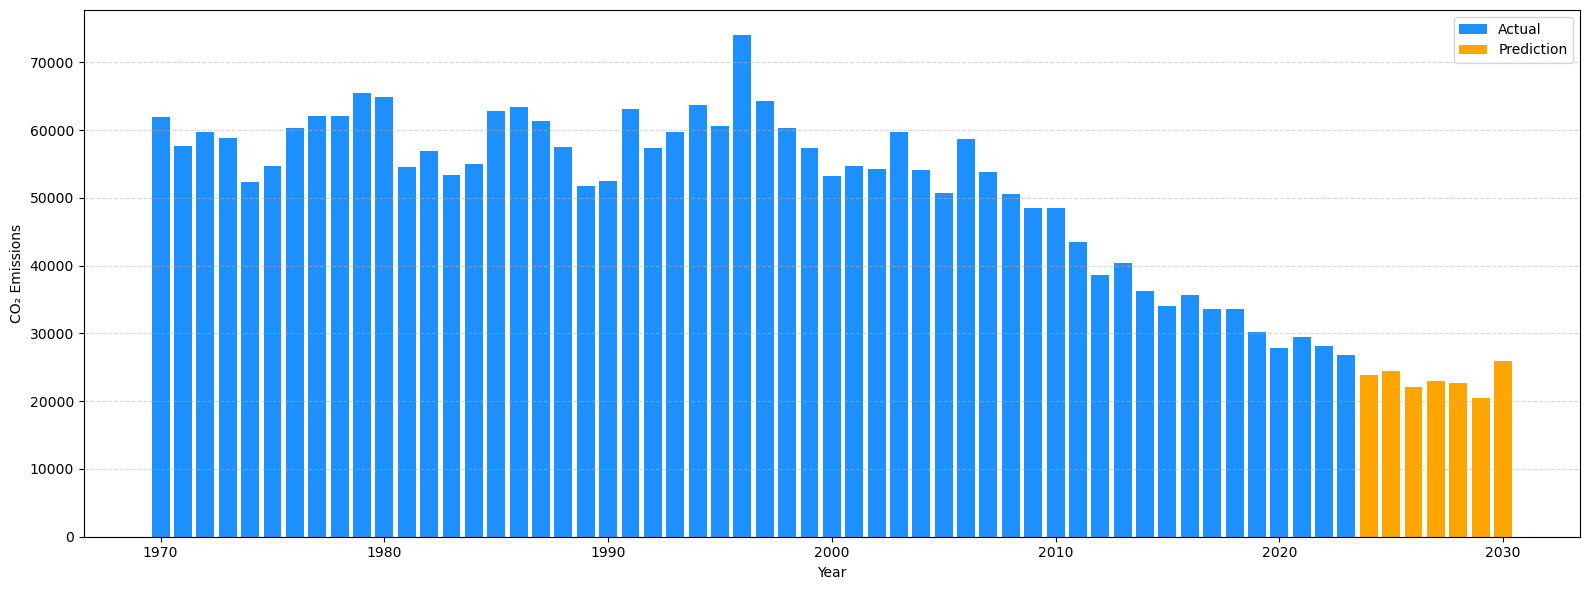

Forecasting Spain
Picked: sarima


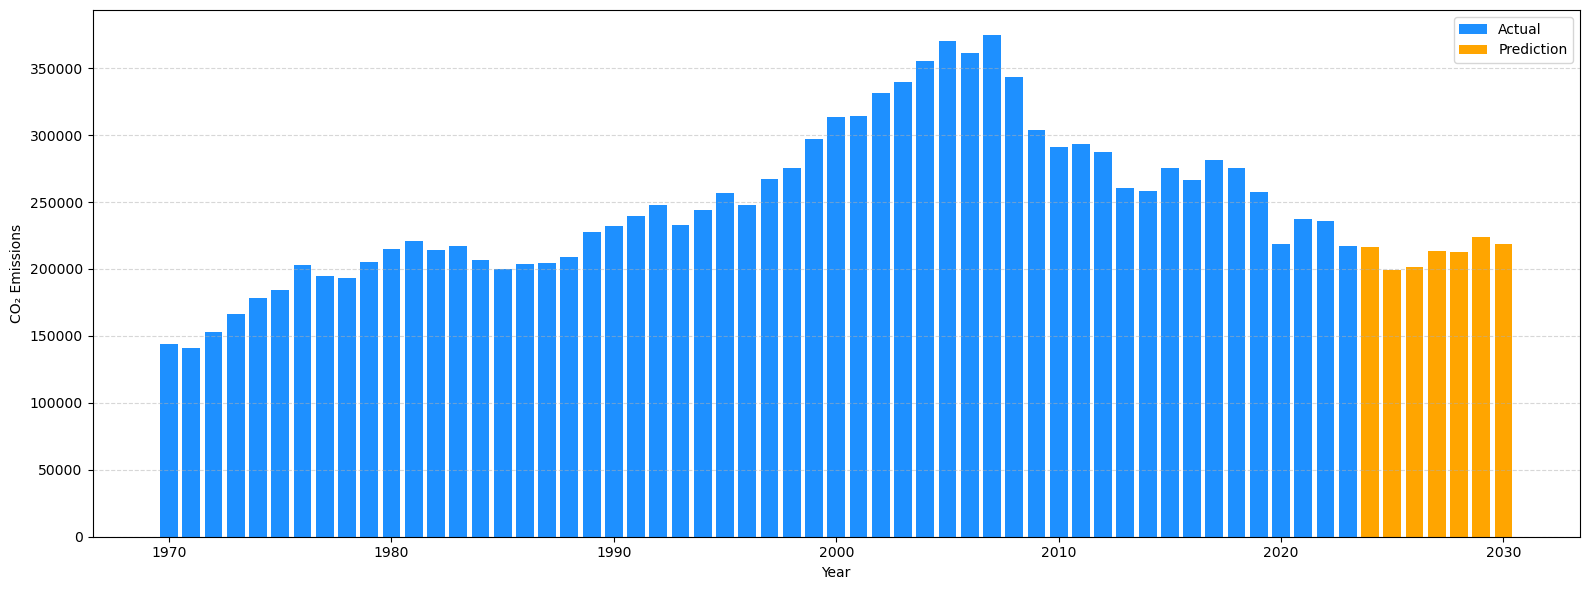

Forecasting Estonia
Picked: sarima


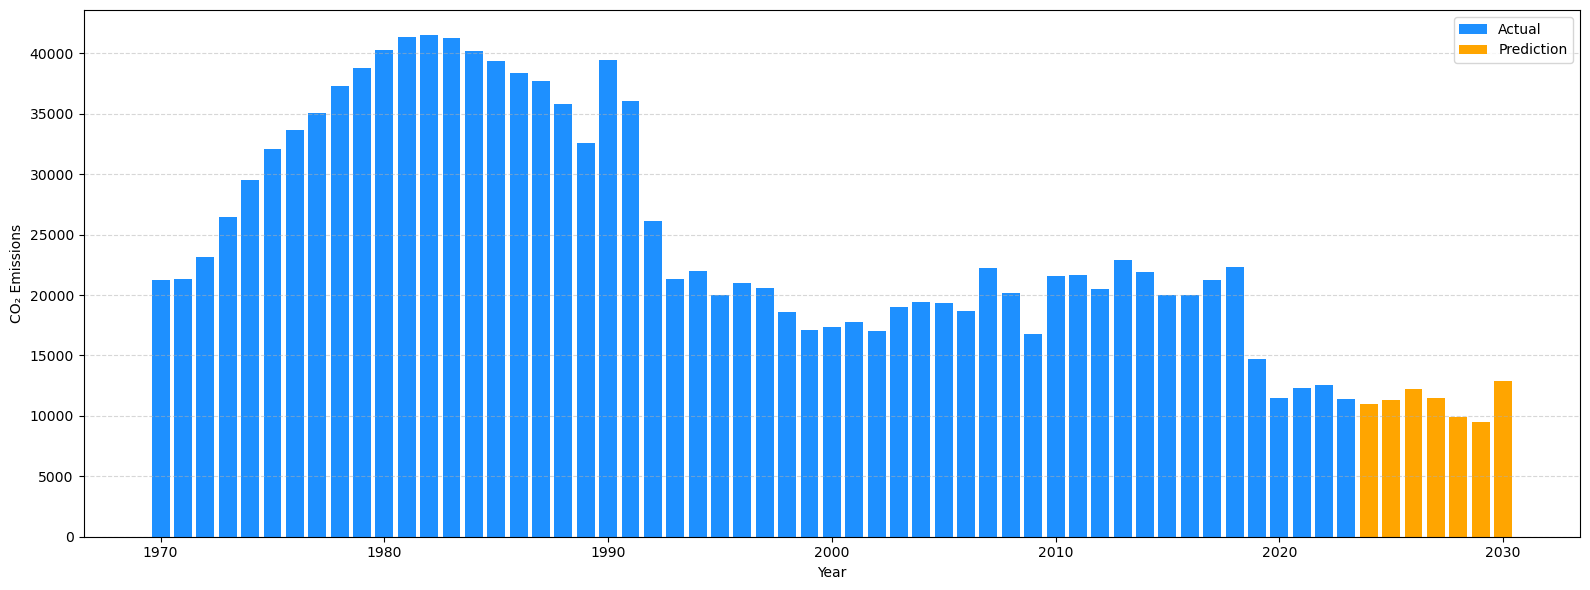

Forecasting Finland
Picked: sarima


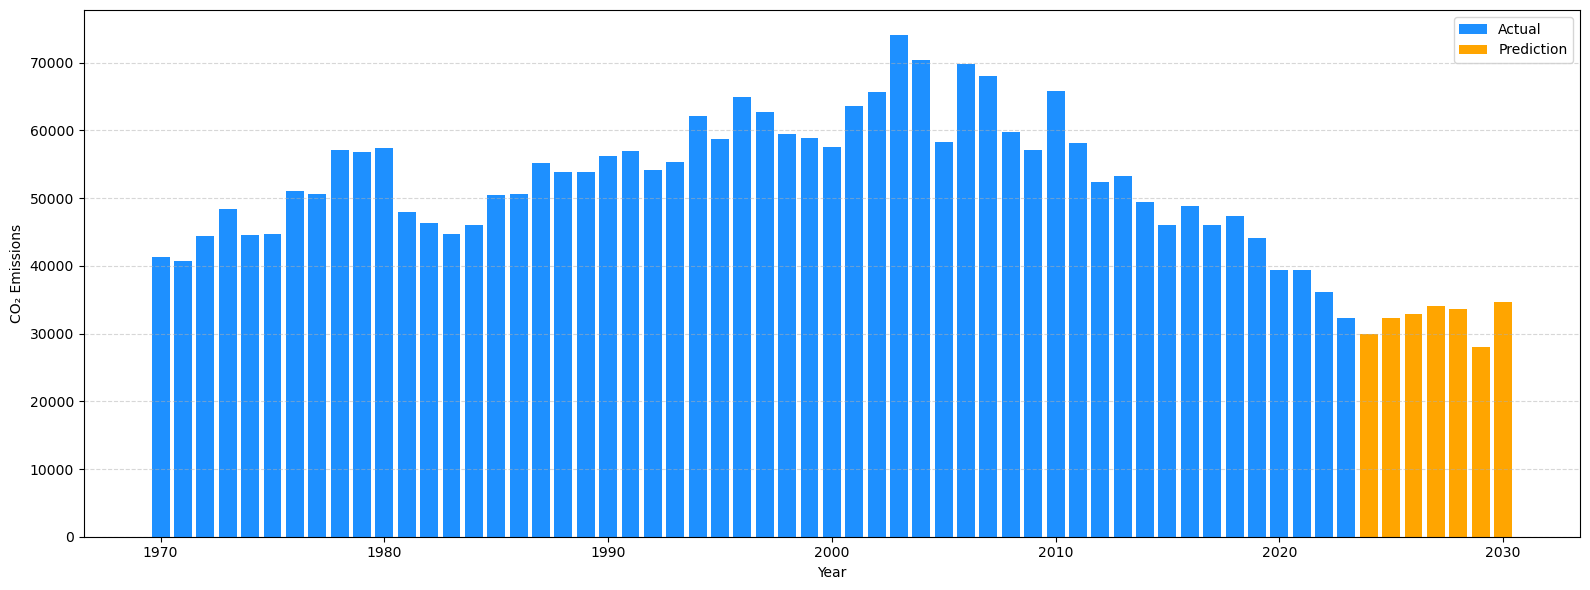

Forecasting France
Picked: sarima


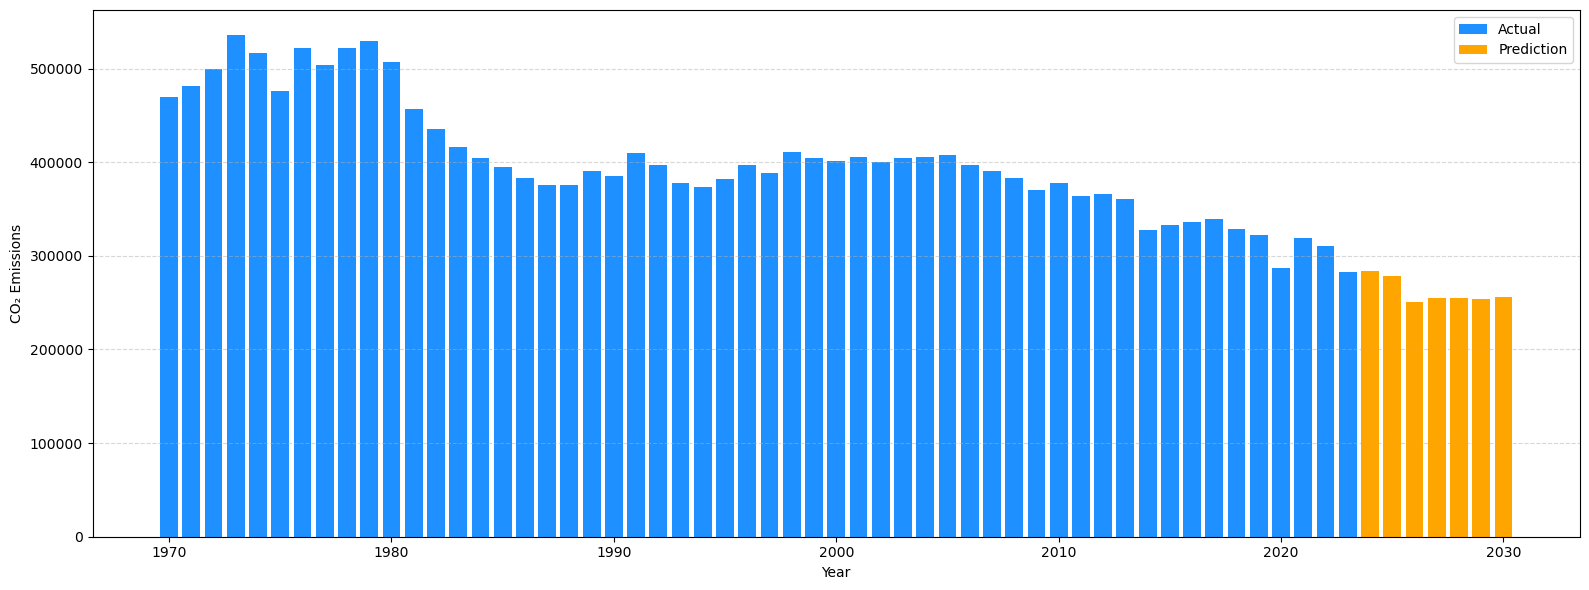

Forecasting United Kingdom
Picked: sarima


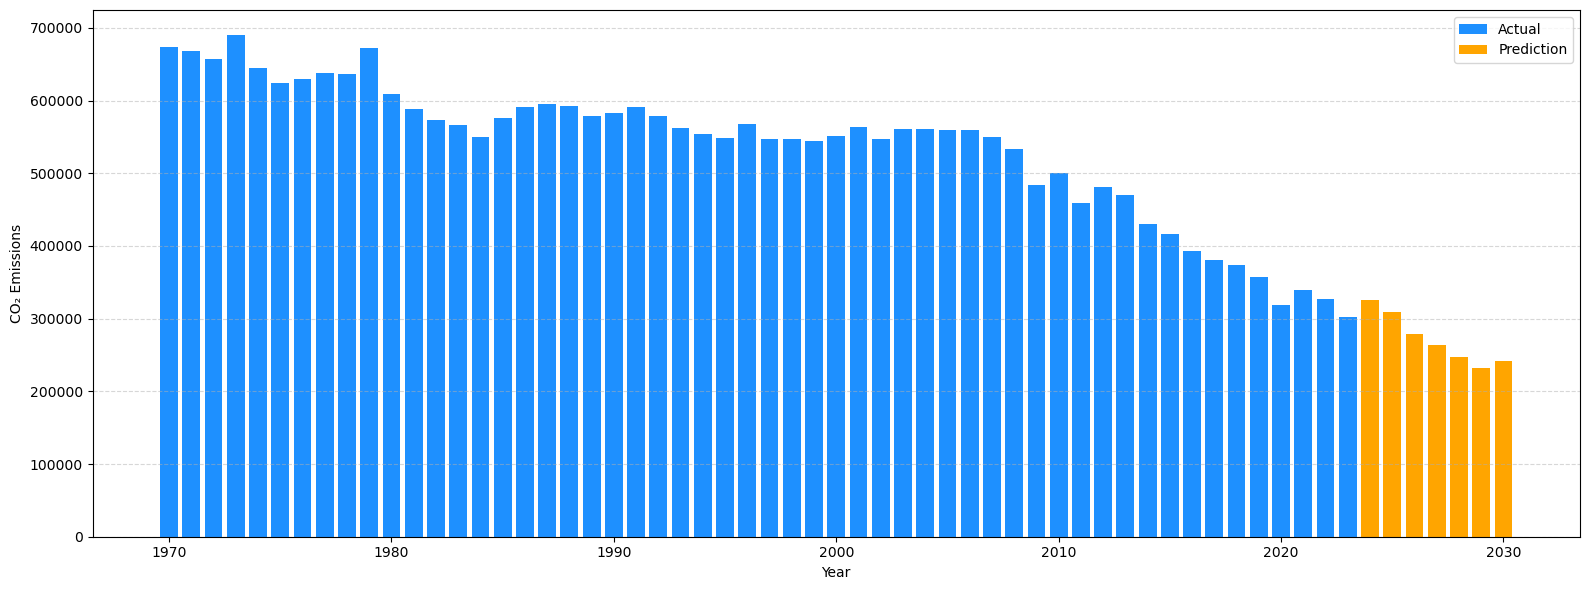

Forecasting Greece
Picked: sarima


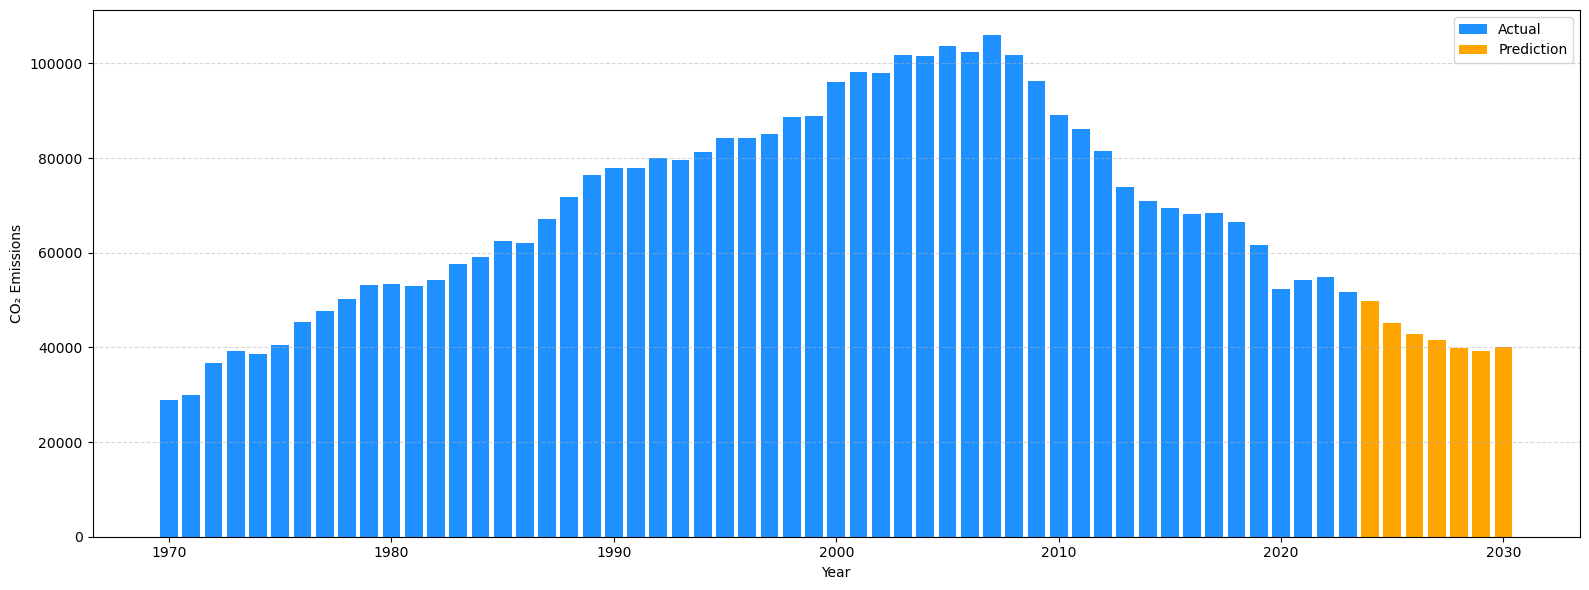

Forecasting Croatia
Picked: sarima


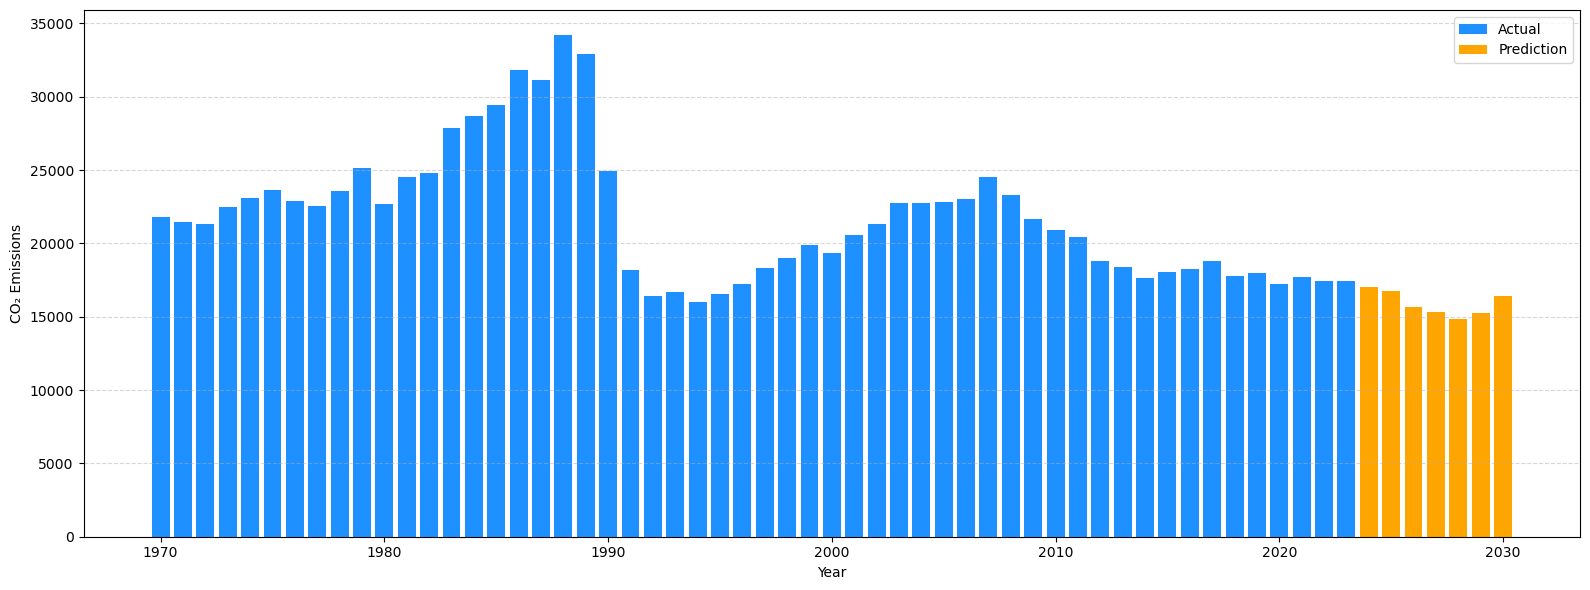

Forecasting Hungary
Picked: sarima


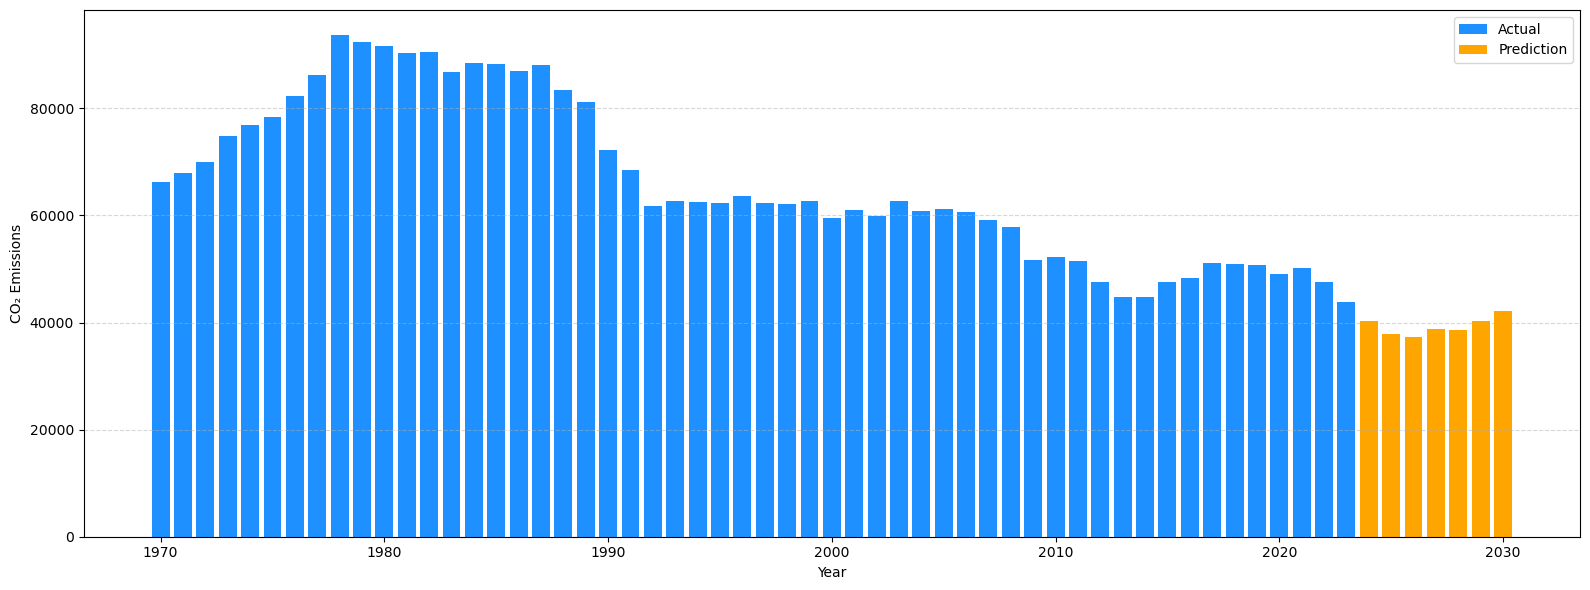

Forecasting Ireland
Picked: sarima


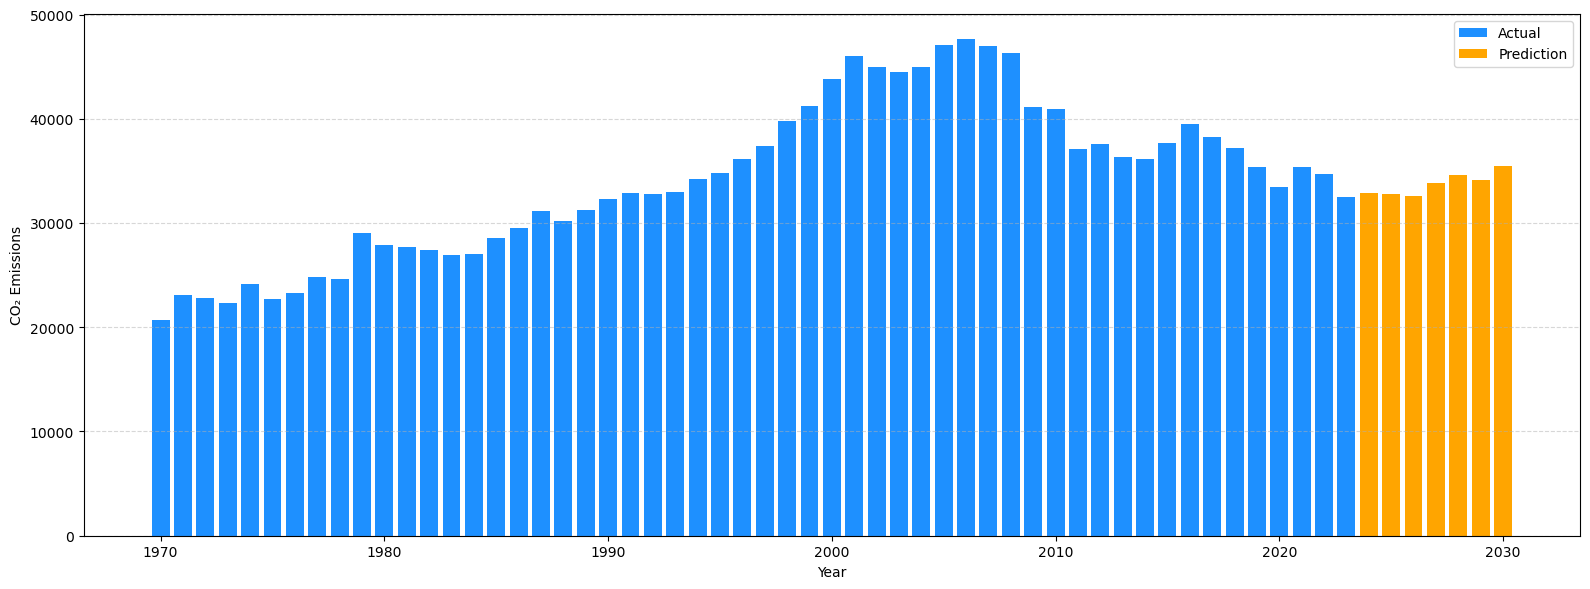

Forecasting Iceland
Picked: sarima


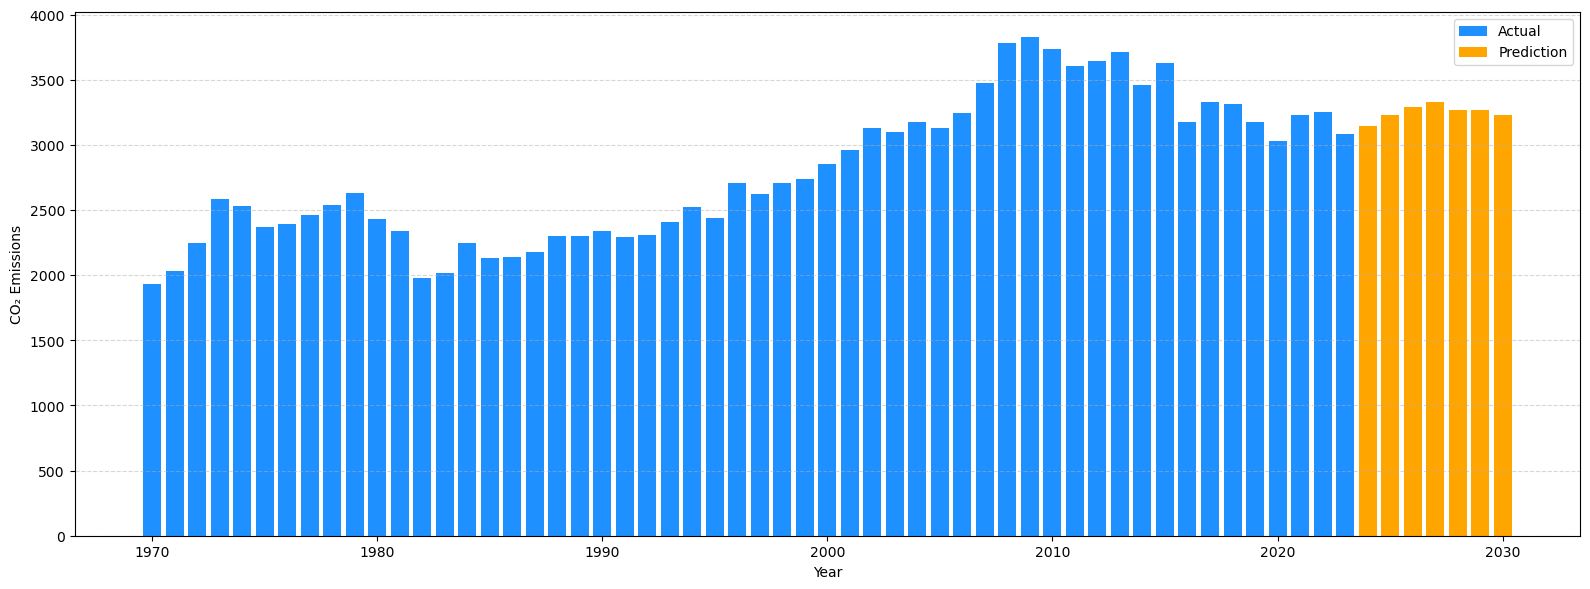

Forecasting Italy
Picked: sarima


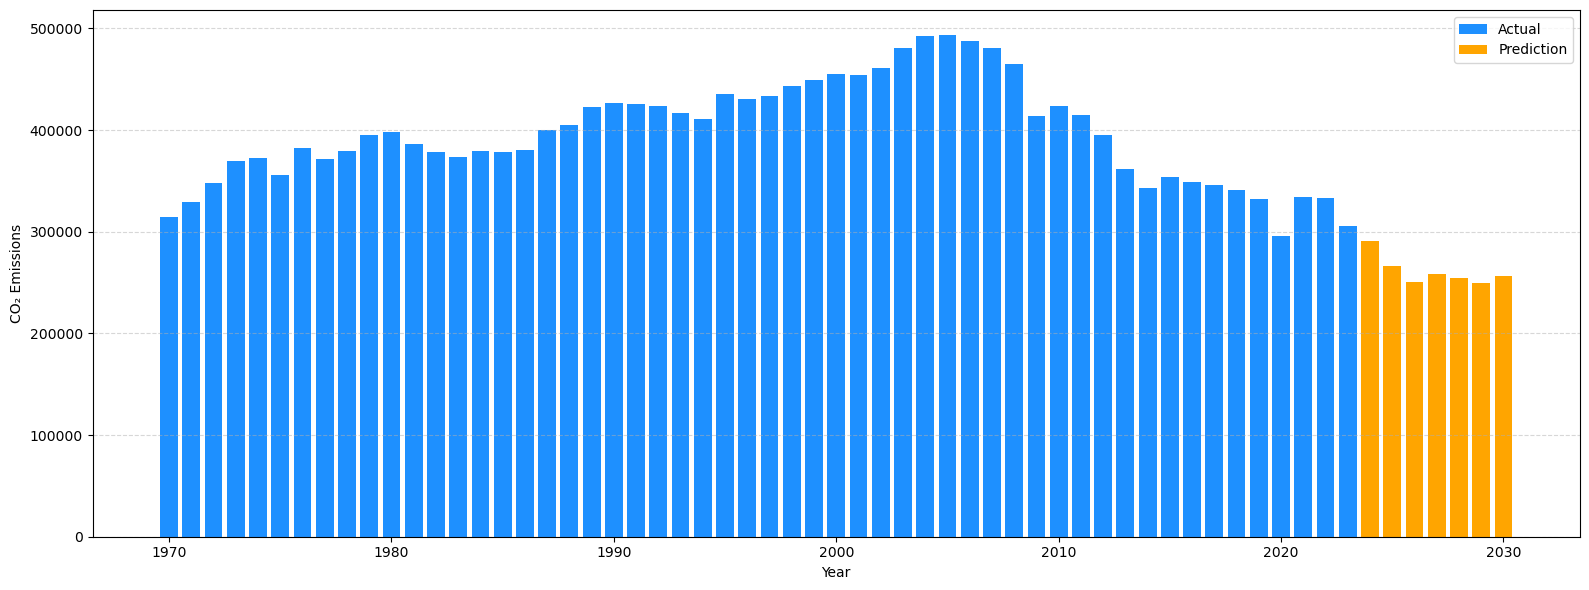

Forecasting Lithuania
Picked: sarima


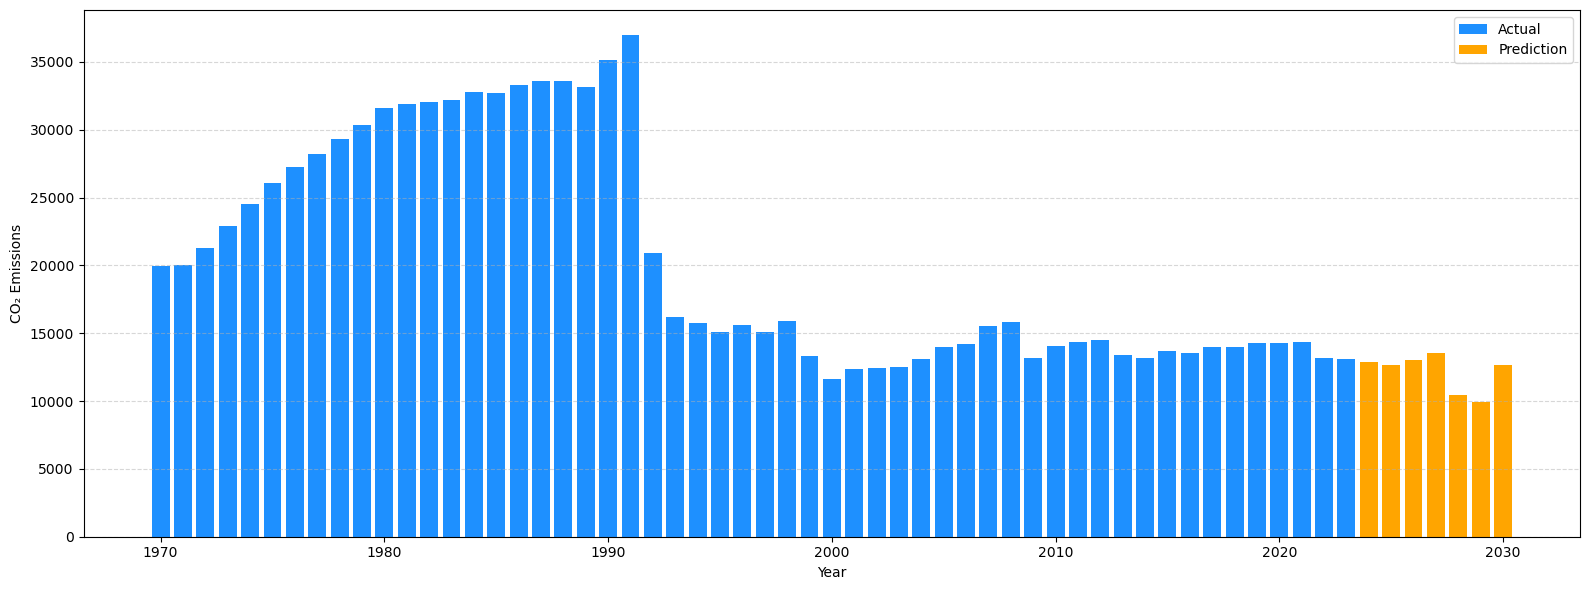

Forecasting Luxembourg
Picked: sarima


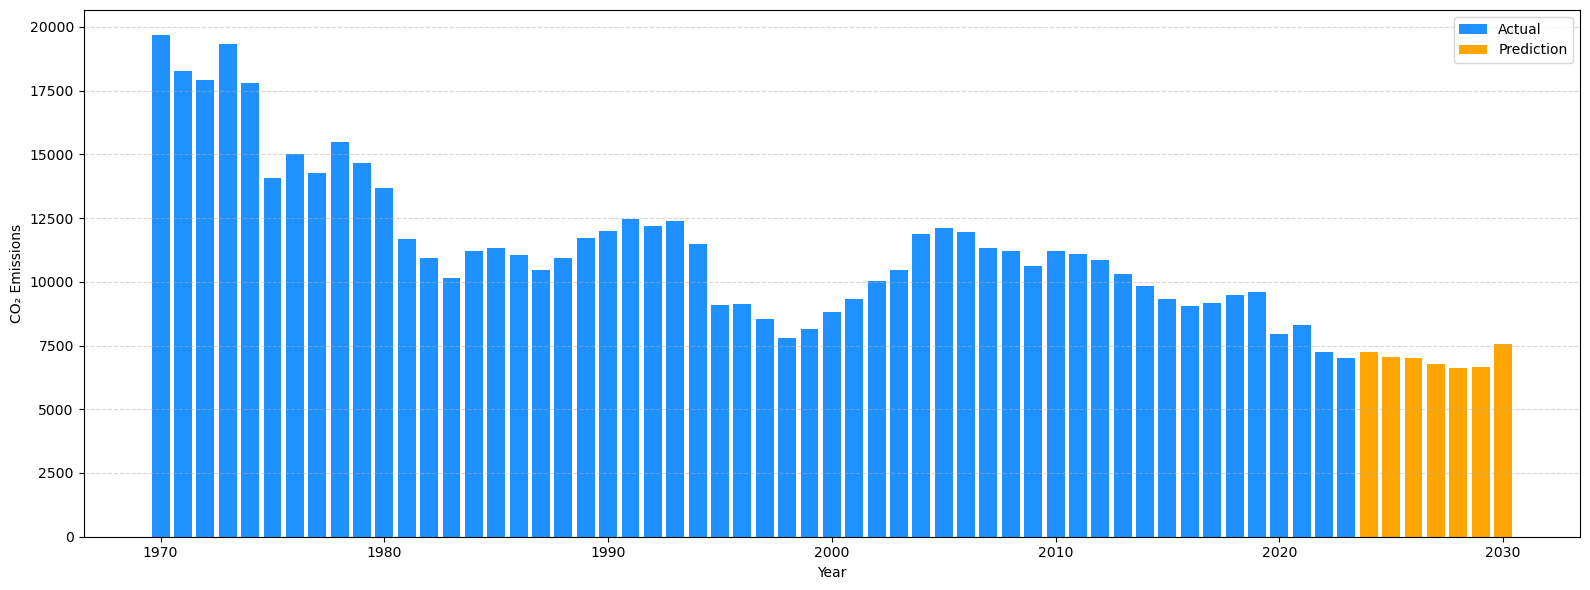

Forecasting Latvia
Picked: sarima


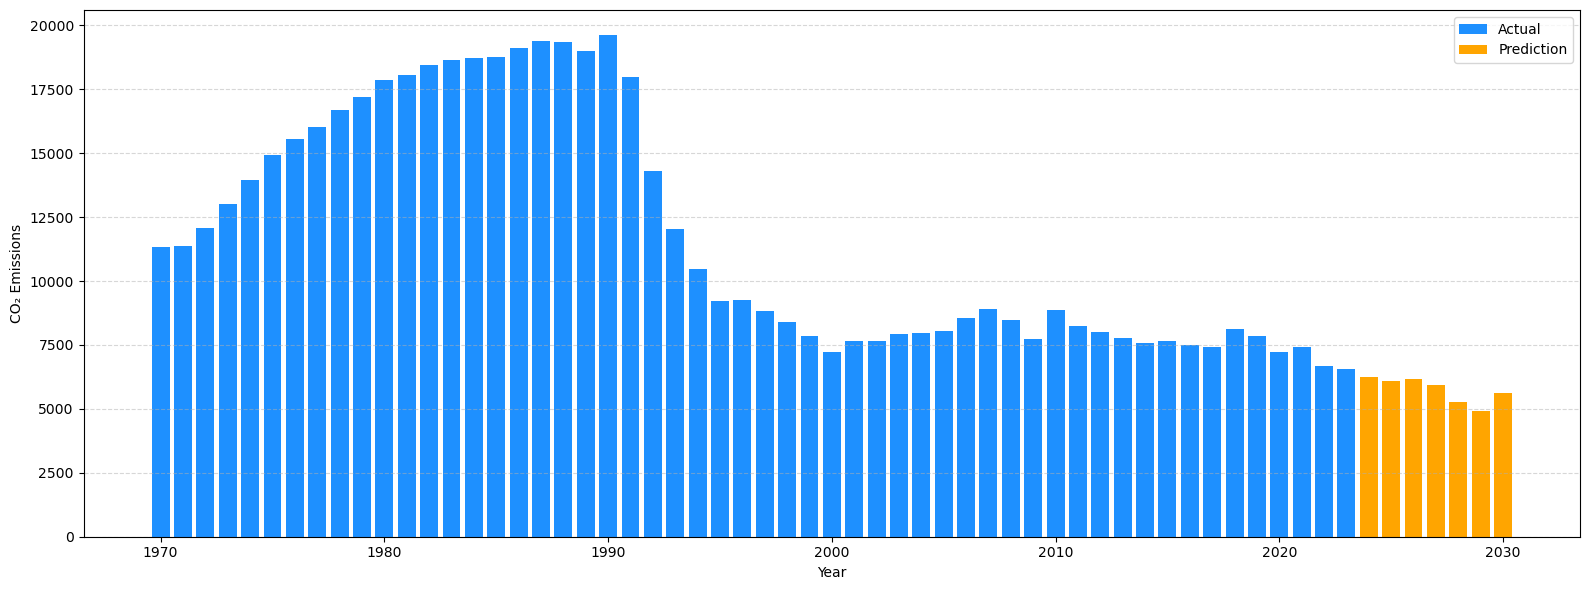

Forecasting North Macedonia
Picked: sarima


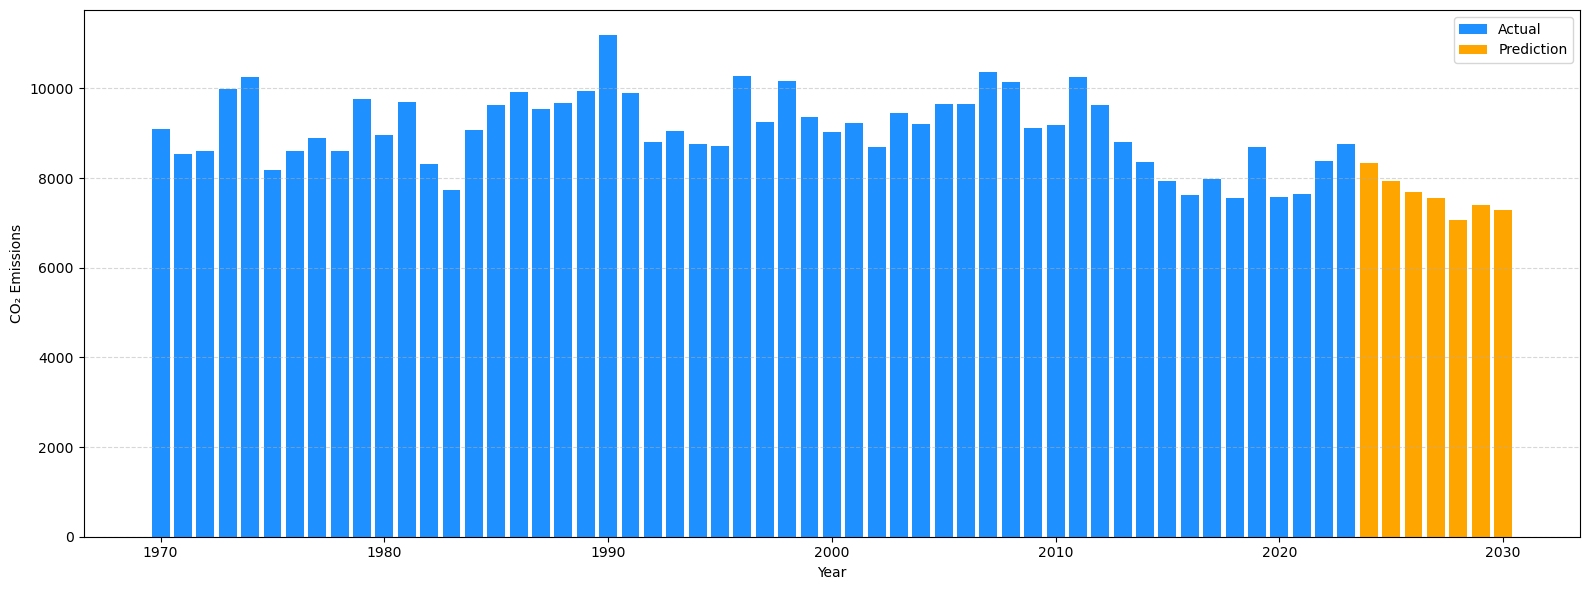

Forecasting Malta
Picked: sarima


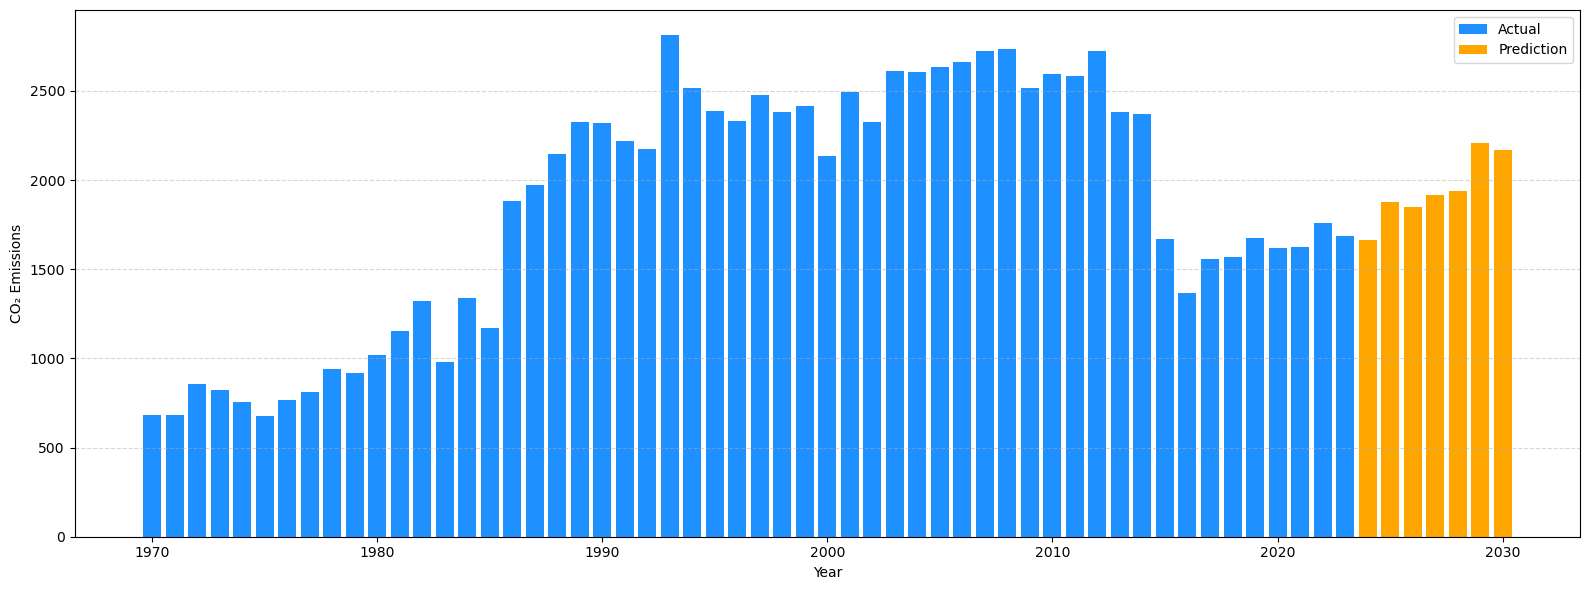

Forecasting Netherlands
Picked: sarima


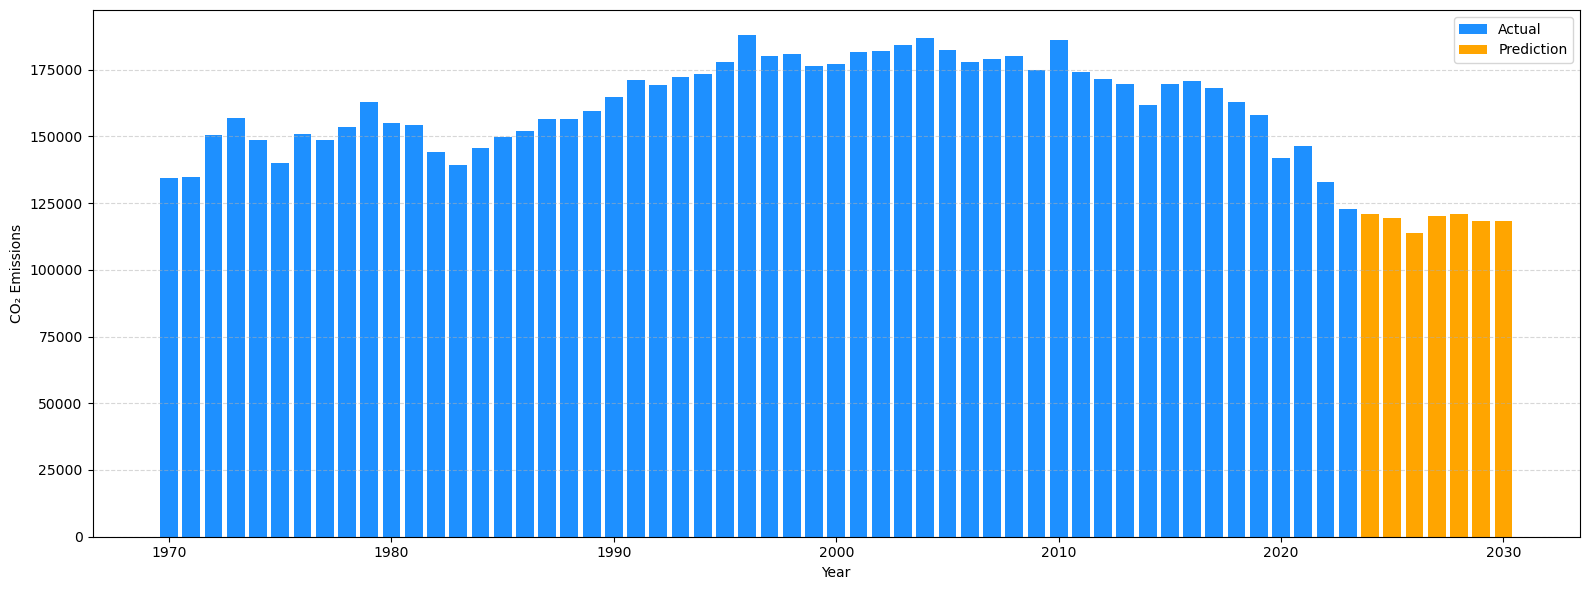

Forecasting Norway
Picked: sarima


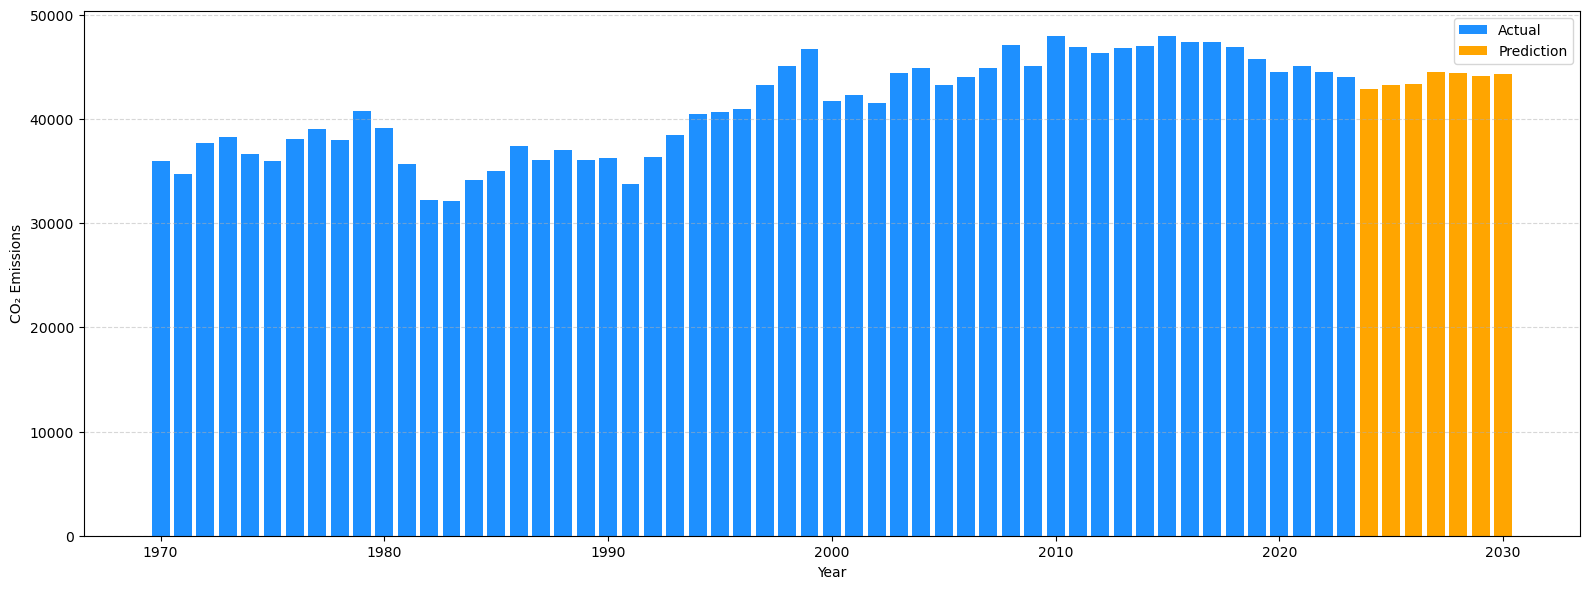

Forecasting Poland
Picked: sarima


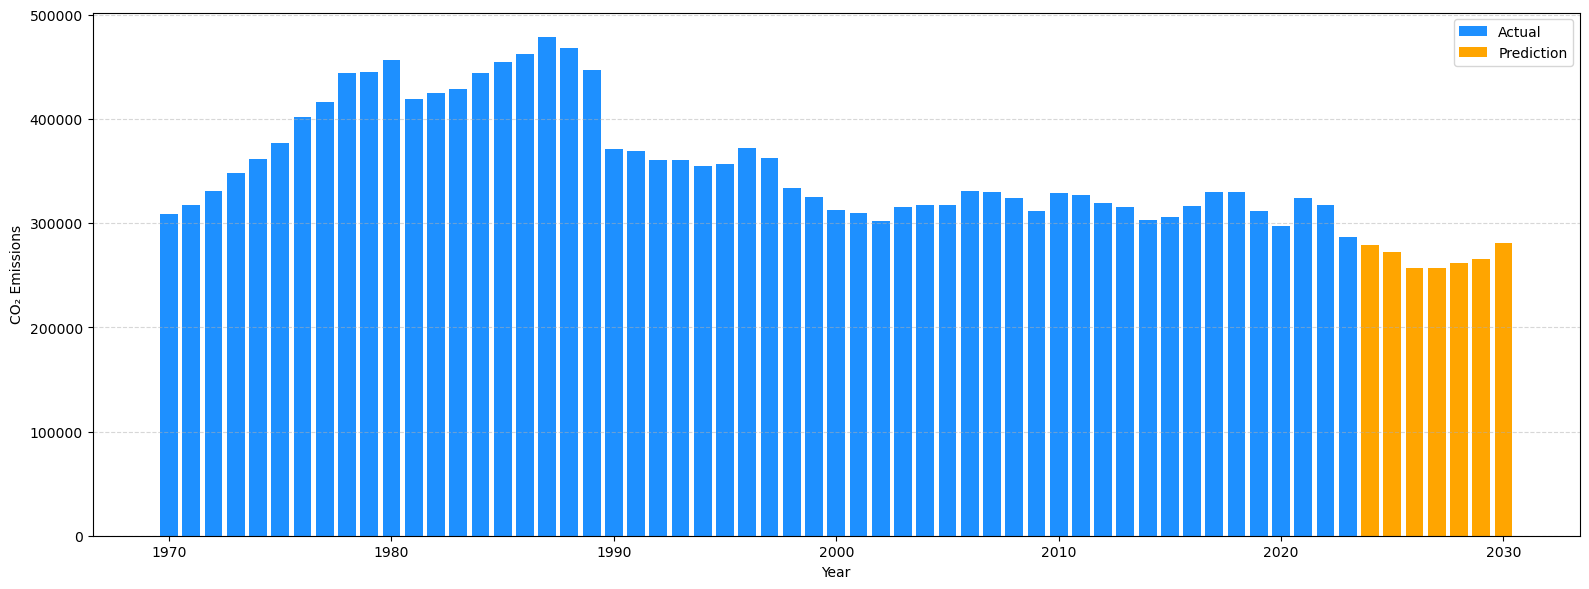

Forecasting Portugal
Picked: sarima


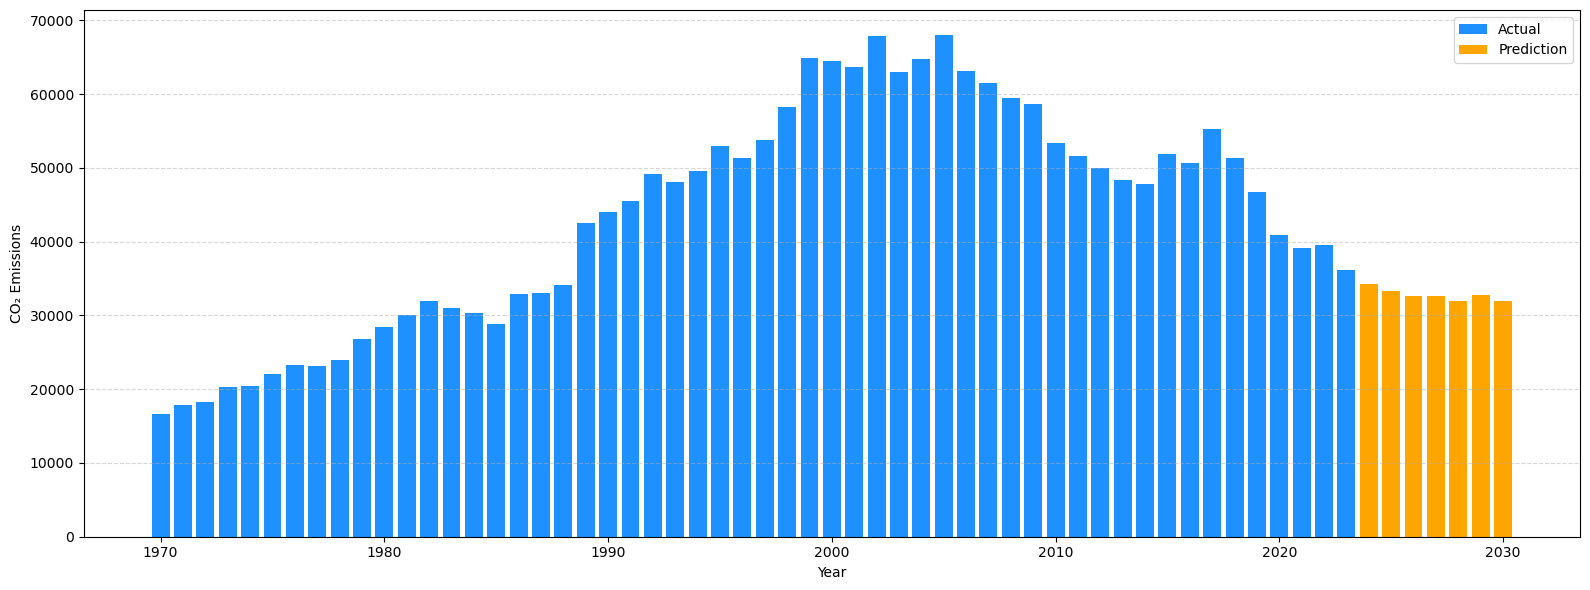

Forecasting Romania
Picked: sarima


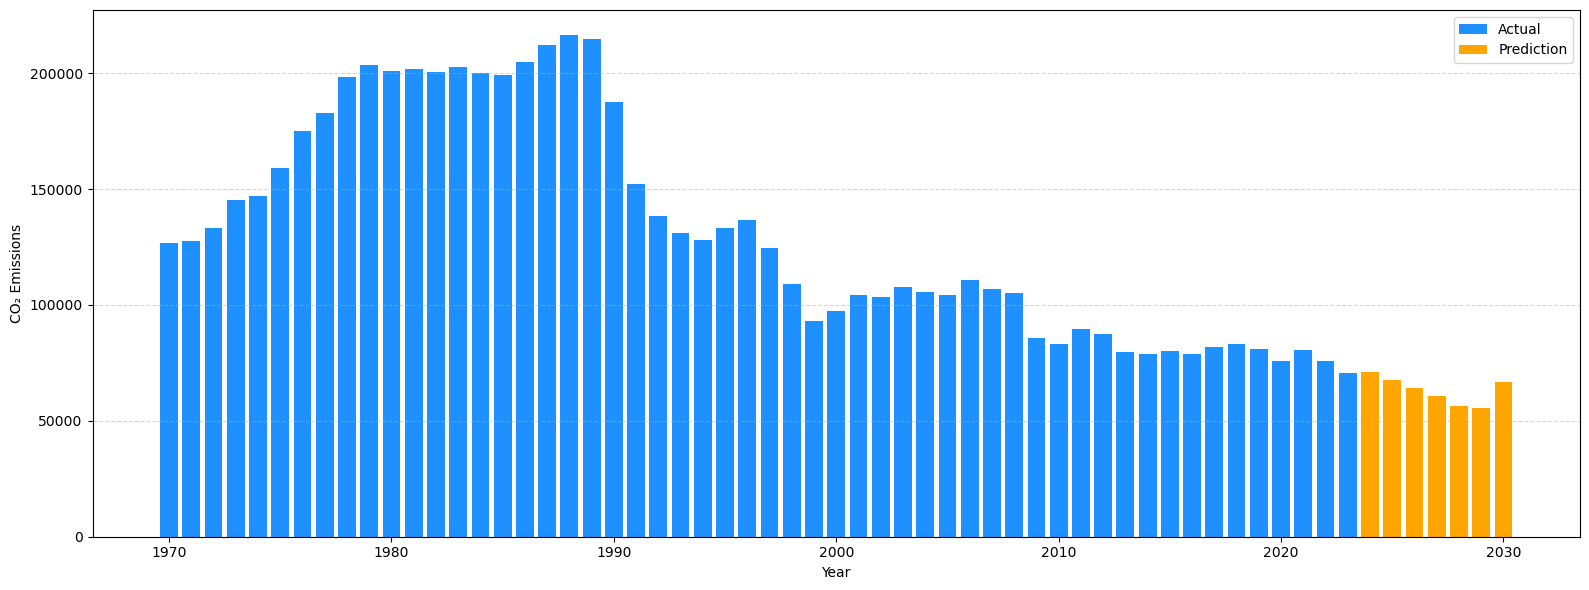

Forecasting Slovakia
Picked: sarima


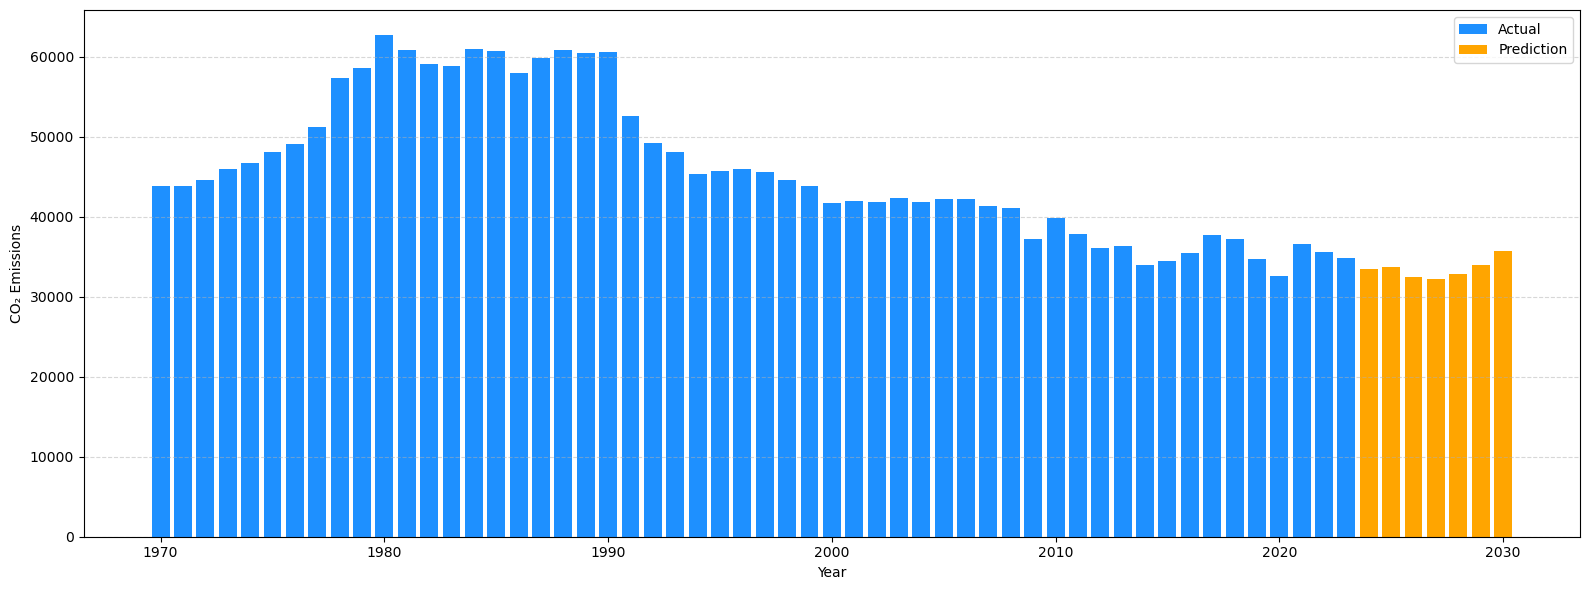

Forecasting Slovenia
Picked: sarima


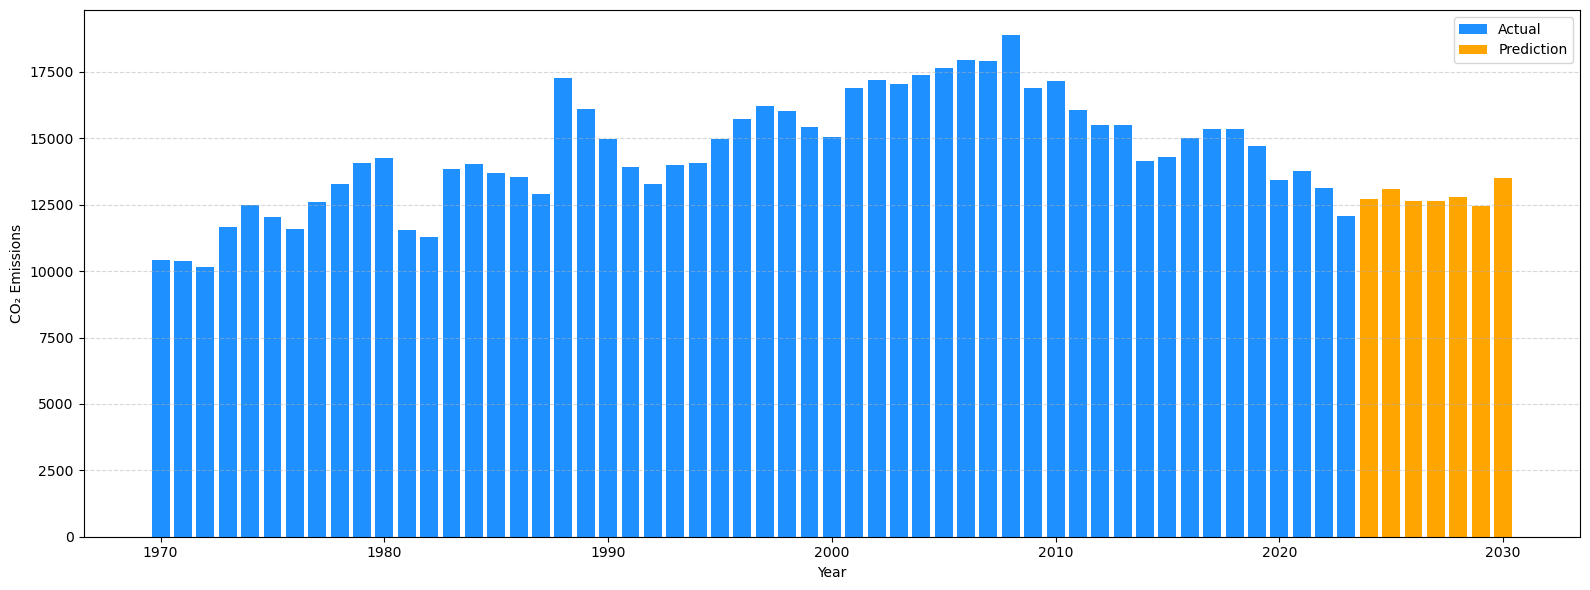

Forecasting Sweden
Picked: sarima


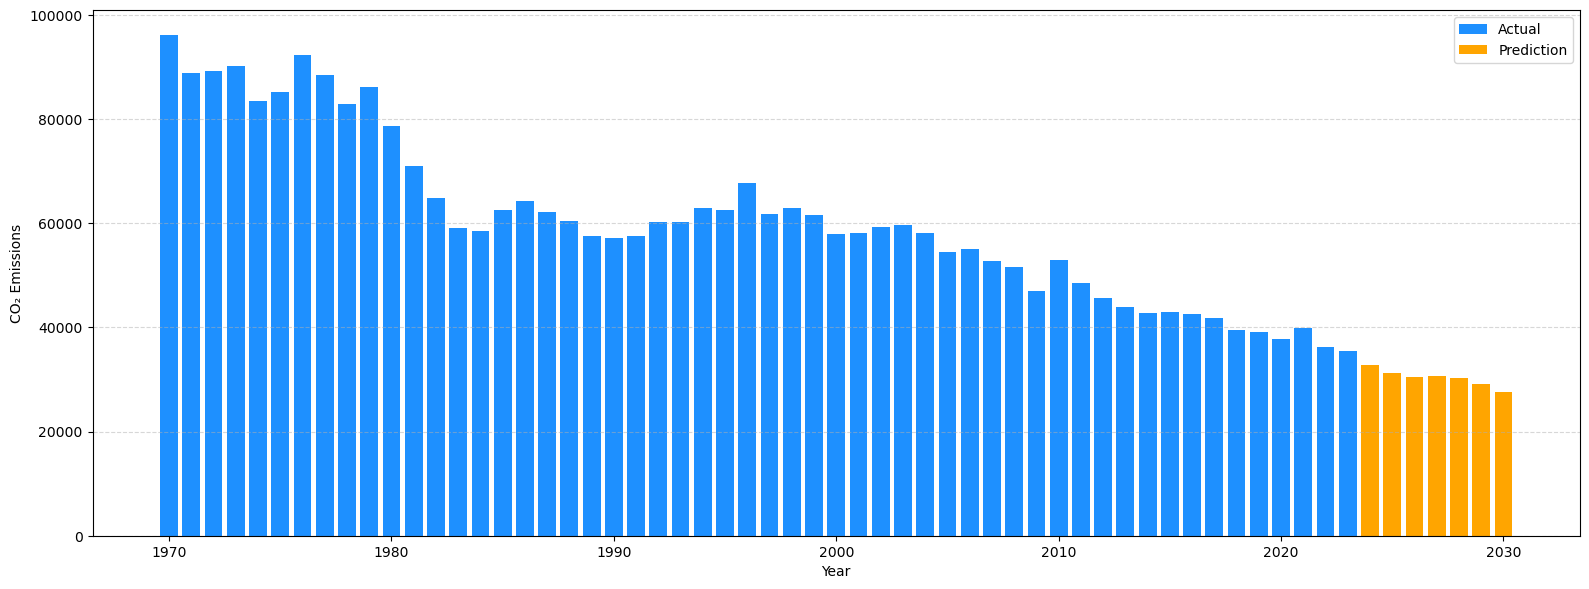

Forecasting Russia
Picked: sarima


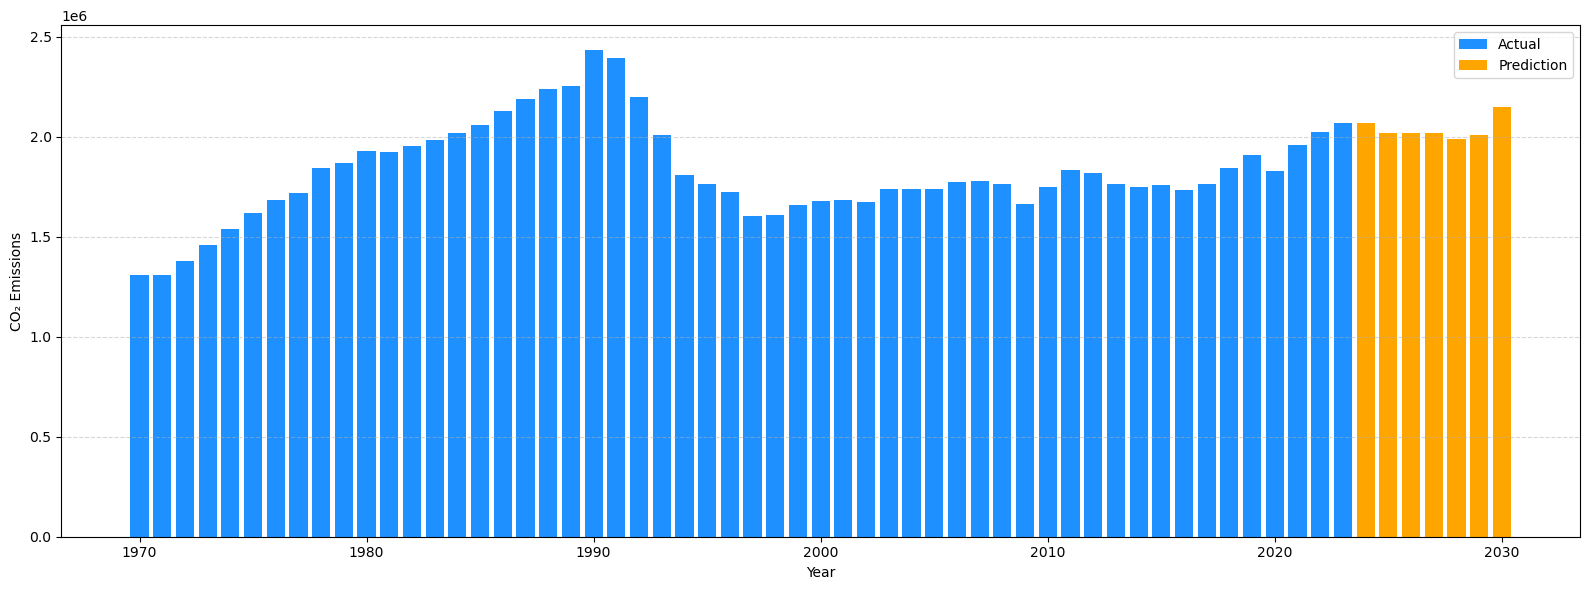

Forecasting Ukraine
Picked: sarima


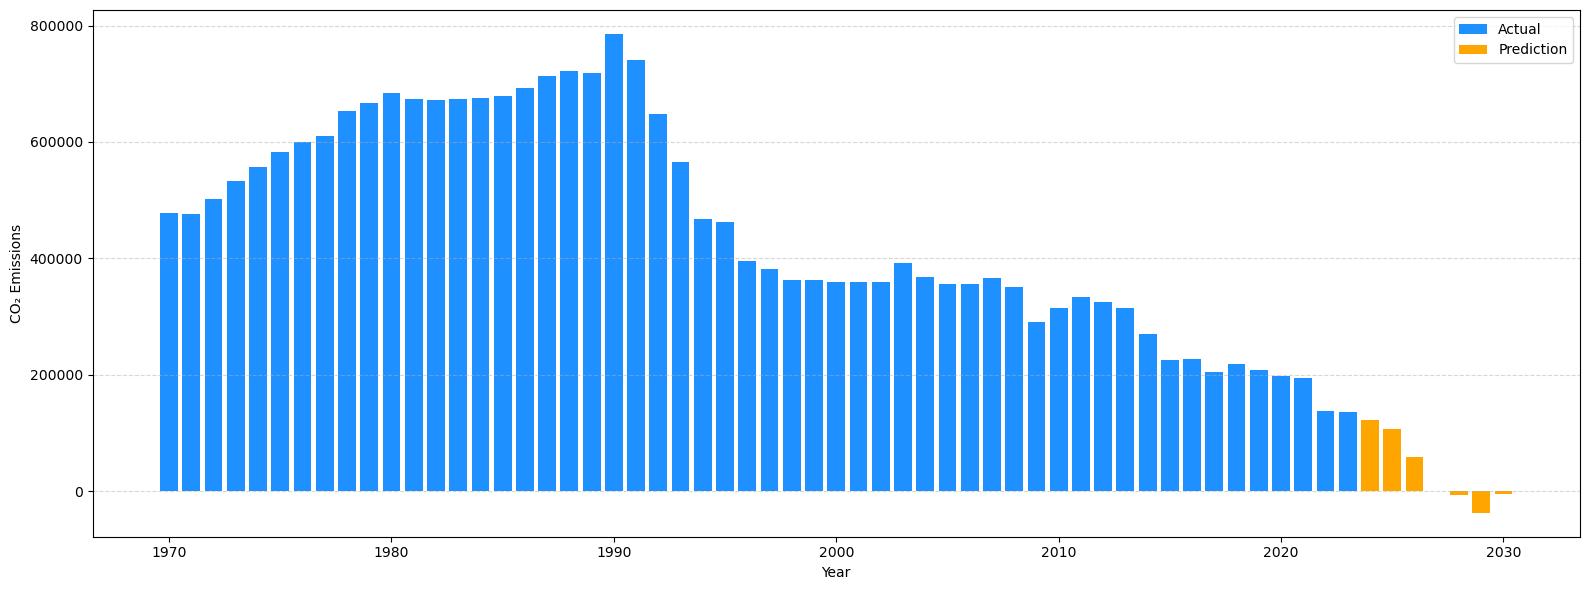

Forecasting Belarus
Picked: sarima


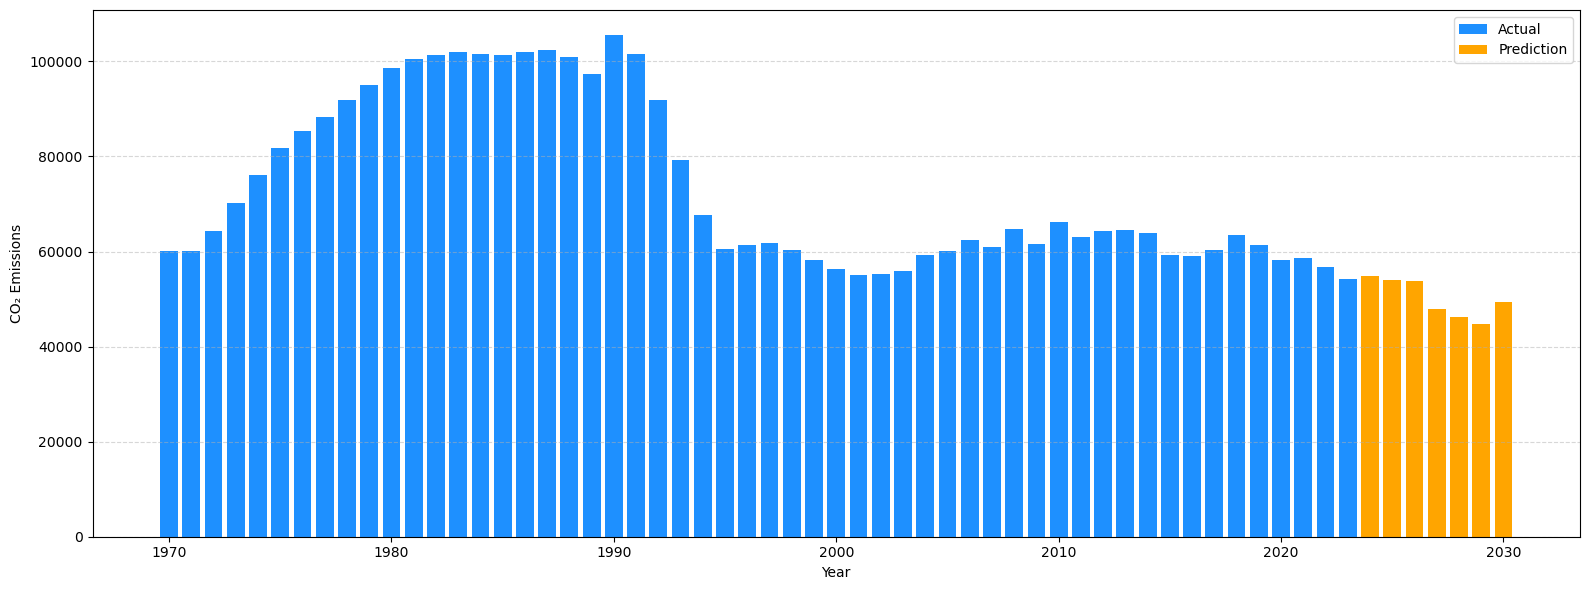

Forecasting Moldova
Picked: sarima


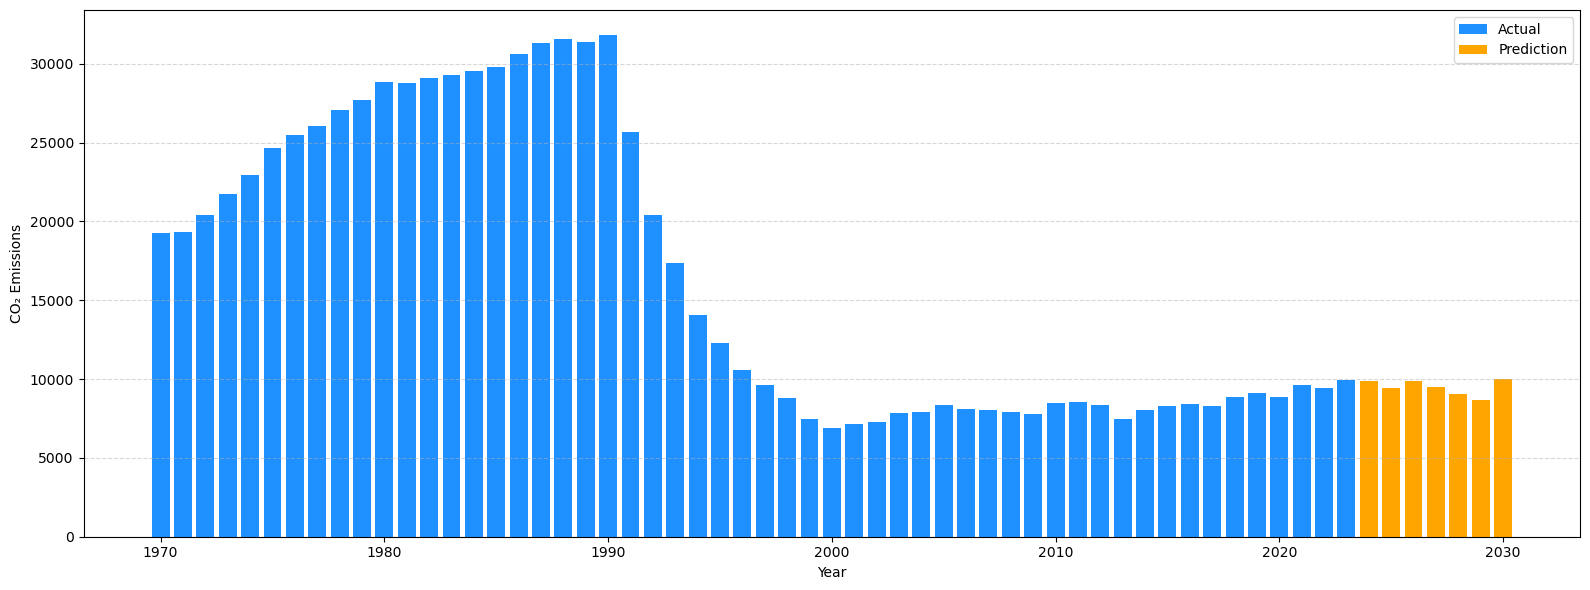

Forecasting Serbia
Picked: sarima


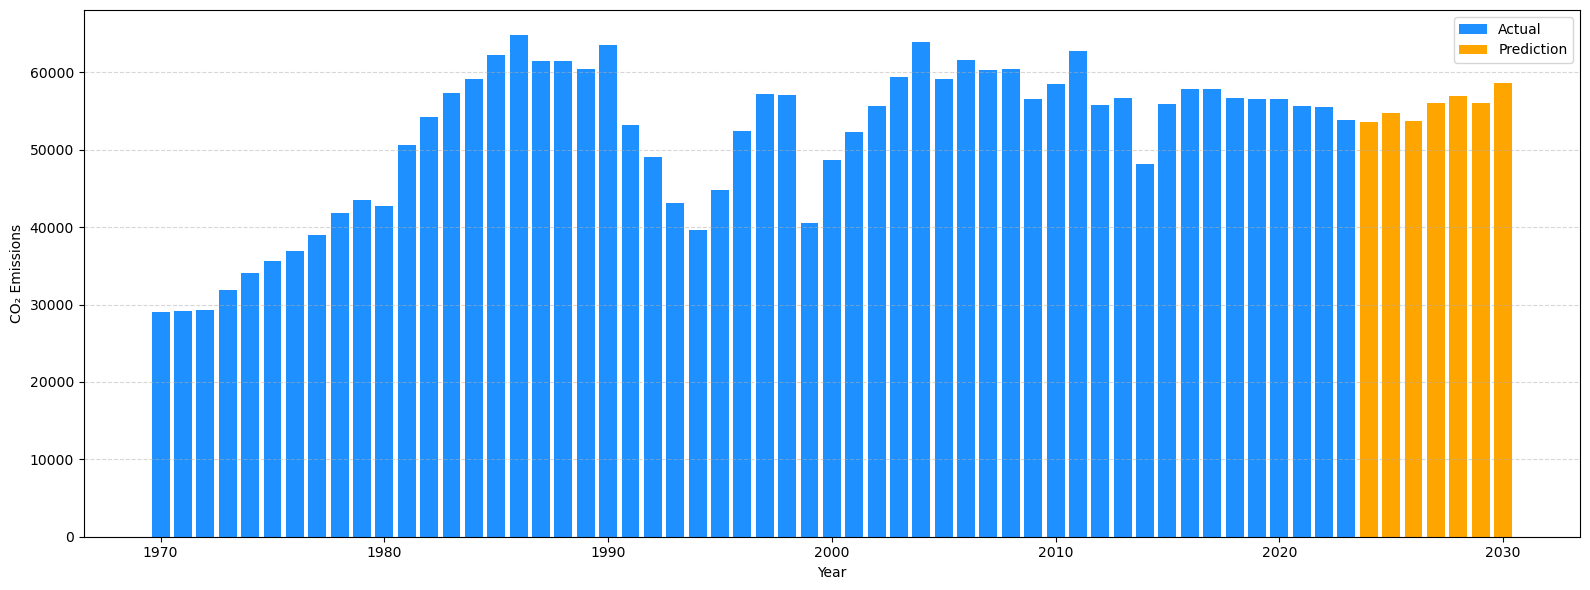

Forecasting Montenegro
Picked: sarima


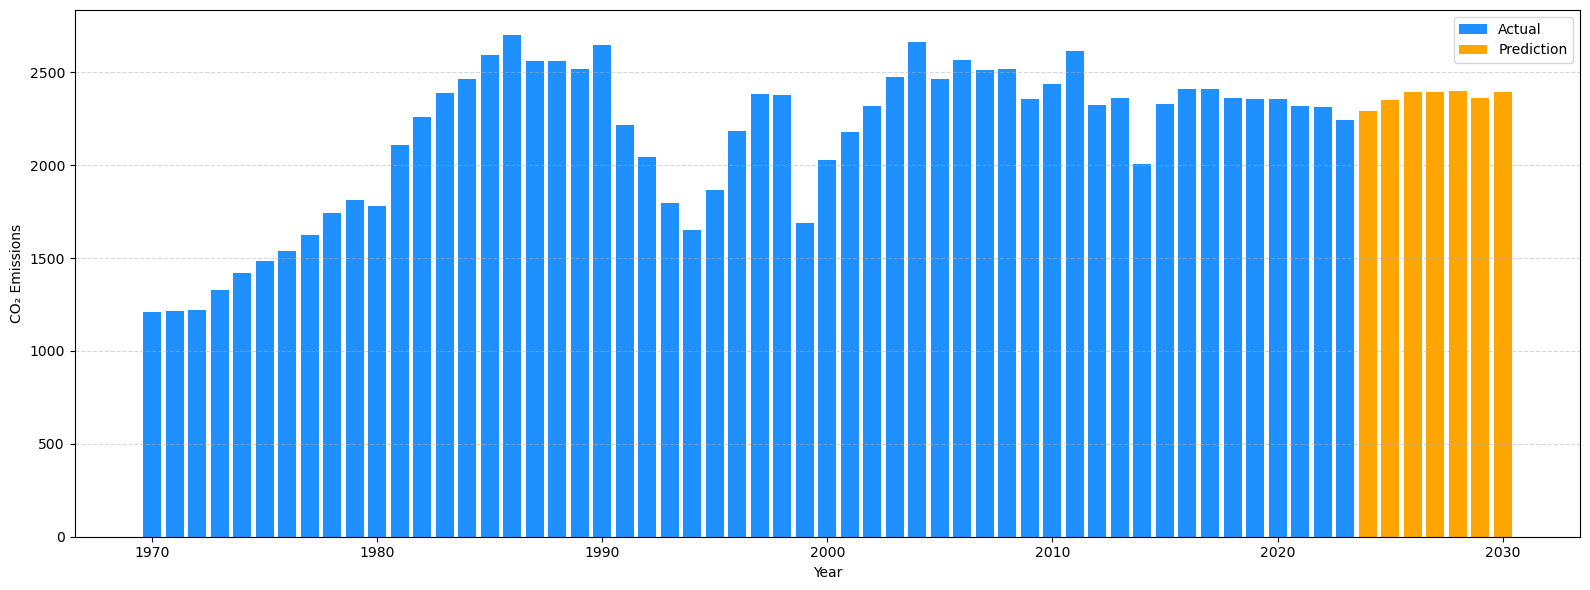

In [9]:
algorithms = {
    'sarima': 'SARIMA',
}

df_forecasts_sarima_all = pd.DataFrame()

for country in countries_list:
    print(f'Forecasting {country}')
    df = df_co2[df_co2['Name'] == country][init_cols].copy()
    df.rename(columns={'Year': 'year'}, inplace=True)
    
    # add features
    df = add_year_features(df)
    df = add_lag_features(df)
    df = add_rolling_features(df)
    
    # m, df_eval = eval_and_select_model(df, algorithms, features, eval_metric, target='CO2_emissions')
    m = 'sarima'
    print(f'Picked: {m}')
    # print(f'{df_eval}')

    year_add = []
    if 'year' not in features: year_add = ['year']
    
    X = df[['CO2_emissions'] + year_add + features]

    # print(X)
    df_forecast = predict_year_by_year(X, m, features, algorithms, year_from, year_to)
    df_forecast['Name'] = country
    
    df_forecasts_sarima_all = pd.concat([df_forecasts_sarima_all, df_forecast], ignore_index=True)

    if plot_forecasts:
        plt.figure(figsize=(16, 6))
        plt.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)
        plt.bar(df['year'], df['CO2_emissions'], label='Actual', color='dodgerblue')
        plt.bar(df_forecast['year'], df_forecast['CO2_emissions'], label='Prediction', color='orange')
    
        plt.xlabel("Year")
        plt.ylabel("CO₂ Emissions")
        plt.legend()
        plt.tight_layout()
        plt.show()

The results we got using only the Sarima algorithm look better than the previous ones. They catch the trend for most of the country's CO2 emissions, as seen in the plots.

In [11]:
df_co2.to_csv('./data/co2_emissions_transformed.csv', sep=';')
df_forecasts_sarima_all.to_csv('./data/forecasts_sarima.csv', sep=';')